In [1]:
import wget, os, gzip, pickle, random, re, sys, importlib, tqdm, math, os, gzip, re, string

from tqdm import trange
from collections import Counter

import torch

import random
from random import choice

IMDB_URL = 'http://dlvu.github.io/data/imdb.{}.pkl.gz'
IMDB_FILE = 'imdb.{}.pkl.gz'
WP_DATA = 'https://codeberg.org/pbm/former/raw/branch/master/data/enwik8.gz'

PAD, START, END, UNK = '.pad', '.start', '.end', '.unk'

SENT = '_s'
TOY = {
    '_s': ['_s _adv', '_np _vp', '_np _vp _prep _np', '_np _vp ( _prep _np )', '_np _vp _con _s','_np _vp ( _con _s )'],
    '_adv': ['briefly', 'quickly', 'impatiently'],
    '_np': ['a _noun', 'the _noun', 'a _adj _noun', 'the _adj _noun'],
    '_prep': ['on', 'with', 'to', 'for', 'at'],
    '_con': ['while', 'but'],
    '_noun': ['mouse', 'bunny', 'cat', 'dog', 'man', 'woman', 'person', 'bear', 'koala', 'judge', 'businessman',
        'businesswoman', 'lawyer', 'teacher', 'engineer'],
    '_vp': ['walked', 'walks', 'ran', 'runs', 'goes', 'went', 'hiked'],
    '_adj': ['short', 'quick', 'busy', 'nice', 'gorgeous', 'spectacular', 'reluctant', 'systematic', 'willowy', 'engaged', 'synthetic']
}

PRINTABLE = set(ord(c) for c in (string.digits + string.ascii_letters + string.punctuation + string.whitespace))

def cas(i):
    """
    Character-as-string. Filters out the ascii codes that aren't safe to print.
    :return:
    """
    assert i >= 0 and i < 256
    return '□' if i not in PRINTABLE else str(chr(i))

def t(blist):
    return torch.tensor([int(b) for b in blist], dtype=torch.uint8)

def gen_sentence(sent=SENT, g=TOY):

    symb = '_[a-z]*'

    while True:

        match = re.search(symb, sent)
        if match is None:
            return sent

        s = match.span()
        sent = sent[:s[0]] + random.choice(g[sent[s[0]:s[1]]]) + sent[s[1]:]

def load_toy(ntrain=100_000, ntest=20_000, to_torch=True, final=False, seed=0):
    """
    Generates language from a toy grammar.
    :param ntrain:
    :param ntest:
    :param to_torch: Whether to return torch tensors (if false, returns python lists)
    :param final: Whether to return the test set or the validation set (True for test)
    :return:
    """

    random.seed(seed)

    train, test = '', ''
    while len(train) < ntrain:
        train += gen_sentence() + ' . '

    random.seed(seed if final else seed + 1)
    # -- change the seed so we get different test/val sets depending on `final`

    while len(test) < ntest:
        test += gen_sentence() + ' . '

    ctr = Counter(train + test)
    i2t = [PAD, START, END, UNK] + [t for t, _ in ctr.most_common()]
    t2i = { w : i for  i, w in enumerate(i2t)}

    train = [t2i[t] for t in train]
    test  = [t2i[t] for t in test]
    
    if to_torch:
        return (t(train), t(test)), (i2t, t2i) # Torch vectors (this takes a few seconds)

    return (train, test), (i2t, t2i)

def load_wp(fname='enwik8.gz', split=(90, 5, 5), to_torch=True, final=False):
    """
    Load the enwik8 dataset from the Hutter challenge as a list or vector of bytes.
    :param fname: Filename for the downloaded data.
    :param split: Percentages for the train/val/test split.
    :param to_torch: Whether to return torch tensors (True) or python lists (False)
    :param final: If False, returns train/val if True returns train/test with the validation
    data added to the training data.
    :return:
    """

    if not os.path.exists(fname):
        # If it doesn't exist, download it
        print('Downloading')
        wget.download(WP_DATA, out=fname)
        
    with gzip.open(fname, 'r') if fname.endswith('.gz') else open(fname, 'rb') as file:

        all = file.read()
        ctr = Counter(all)

        i2t = {token : cas(token) for token, freq in ctr.most_common()}
        t2i = {w : i for i, w in enumerate(i2t)}

        split = tuple(s/sum(split) for s in split)
        split = tuple(int(s * len(all)) for s in split)

        train, val, test = all[:split[0]], all[split[0]:split[0]+split[1]], all[split[0]+split[1]:]

        if final:
            train = train + val
            wh = test
        else:
            wh = val

        if to_torch:
            return (t(train), t(wh)), (i2t, t2i)

        return (train, wh), (i2t, t2i)


def load_xor(ntrain=25_000, ntest=25_000, seed=0):

    random.seed(seed)

    i2w = [PAD, START, END, UNK, 'true', 'false'] #
    w2i = {w : i for i, w in enumerate(i2w)}

    dataset, labels = [], []
    for _ in range(ntrain + ntest):
        sentence = [
            choice((i2w[4], i2w[5])),
            choice((i2w[4], i2w[5]))
        ]

        f1, f2 = (sentence[0] == i2w[4]), (sentence[1] == i2w[4]) # true: very/great false: not/terrible
        # -- these words are the only meaningful features
        label = 0 if f1 != f2 else 1

        dataset.append([w2i[word] for word in sentence])
        labels.append(label)

    return \
        (dataset[:ntrain], labels[:ntrain]), \
        (dataset[ntrain:], labels[ntrain:]), \
        (i2w, w2i), 2

def load_imdb_synth(ntrain=25_000, ntest=25_000, seed=0):
    """
    Synthetic IMDb dataset
    :param seed:
    :param voc:
    :return:
    """

    random.seed(seed)

    adjectives = ['classic', 'silent', 'modern', 'vintage', 'independent', 'foreign', 'animated', 'documentary',
    'epic', 'dramatic', 'romantic', 'comic', 'thrilling', 'mysterious', 'gritty', 'stylized', 'iconic', 'acclaimed',
    'popular', 'forgettable', 'unreleased', 'awardwinning', 'blockbuster', 'lowbudget', 'highbudget', 'experimental',
    'mainstream', 'cult', 'notable', 'original']
    nouns = ['movie', 'film', 'motion-picture', 'feature', 'featurette', 'picture', 'flick', 'cinema', 'screenplay',
    'blockbuster', 'talkie', 'silent', 'biopic', 'short', 'docudrama', 'documentary', 'animation', 'cartoon',
    'anime', 'telefilm', 'miniseries', 'drama', 'comedy', 'thriller', 'western', 'musical', 'noir']
    verbs = ['was', 'is', 'became', 'becomes', 'seemed', 'seems']

    i2w = [PAD, START, END, UNK, 'this', 'not', 'very', 'great','terrible'] + verbs + adjectives + nouns
    w2i = {w : i for i, w in enumerate(i2w)}

    dataset, labels = [], []
    for _ in range(ntrain + ntest):
        sentence = [
            i2w[4], # this
            choice(adjectives), # old
            choice(nouns), # movie
            choice(verbs), # was
            choice((i2w[5], i2w[6])),
            choice((i2w[7], i2w[8]))
        ]

        f1, f2 = (sentence[4] == i2w[6]), (sentence[5] == i2w[7]) # true: very/great false: not/terrible
        # -- these words are the only meaningful features
        label = 0 if f1 != f2 else 1

        dataset.append([w2i[word] for word in sentence])
        labels.append(label)

    return \
        (dataset[:ntrain], labels[:ntrain]), \
        (dataset[ntrain:], labels[ntrain:]), \
        (i2w, w2i), 2


def load_imdb(final=False, val=5000, seed=0, voc=None, char=False):

    cst = 'char' if char else 'word'

    imdb_url = IMDB_URL.format(cst)
    imdb_file = IMDB_FILE.format(cst)

    if not os.path.exists(imdb_file):
        wget.download(imdb_url)

    with gzip.open(imdb_file) as file:
        sequences, labels, i2w, w2i = pickle.load(file)

    if voc is not None and voc < len(i2w):
        nw_sequences = {}

        i2w = i2w[:voc]
        w2i = {w: i for i, w in enumerate(i2w)}

        mx, unk = voc, w2i['.unk']
        for key, seqs in sequences.items():
            nw_sequences[key] = []
            for seq in seqs:
                seq = [s if s < mx else unk for s in seq]
                nw_sequences[key].append(seq)

        sequences = nw_sequences

    if final:
        return (sequences['train'], labels['train']), (sequences['test'], labels['test']), (i2w, w2i), 2

    # Make a validation split
    random.seed(seed)

    x_train, y_train = [], []
    x_val, y_val = [], []

    val_ind = set( random.sample(range(len(sequences['train'])), k=val) )
    for i, (s, l) in enumerate(zip(sequences['train'], labels['train'])):
        if i in val_ind:
            x_val.append(s)
            y_val.append(l)
        else:
            x_train.append(s)
            y_train.append(l)

    return (x_train, y_train), \
           (x_val, y_val), \
           (i2w, w2i), 2

c:\Users\stent\OneDrive\Desktop\DeepLearning-assignments\.venv\Lib\site-packages\torch\_subclasses\functional_tensor.py:279: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


# Part 1: Classification (Data Loading)

In [2]:
# Load the IMDb dataset
(x_train, y_train), (x_val, y_val), (i2w, w2i), numcls = load_imdb(final=False)

In [3]:
for i in range(5):
    print("Sequence", i)
    print([i2w[idx] for idx in x_train[i]], f"label: {y_train[i]}")
    print(x_train[i], f"label: {y_train[i]}")
    print()

Sequence 0
['this', 'movie', 'is', 'terrible', 'but', 'it', 'has', 'some', 'good', 'effects'] label: 1
[14, 19, 9, 379, 22, 11, 50, 52, 53, 290] label: 1

Sequence 1
['i', 'wouldn', 't', 'rent', 'this', 'one', 'even', 'on', 'dollar', 'rental', 'night'] label: 1
[13, 574, 25, 809, 14, 32, 63, 26, 2722, 2231, 312] label: 1

Sequence 2
['ming', 'the', 'merciless', 'does', 'a', 'little', 'bardwork', 'and', 'a', 'movie', 'most', 'foul'] label: 1
[10721, 4, 10956, 129, 6, 124, 88114, 5, 6, 19, 93, 4118] label: 1

Sequence 3
['long', 'boring', 'blasphemous', 'never', 'have', 'i', 'been', 'so', 'glad', 'to', 'see', 'ending', 'credits', 'roll'] label: 1
[198, 351, 17697, 116, 31, 13, 80, 40, 1240, 8, 69, 272, 883, 1749] label: 1

Sequence 4
['no', 'comment', 'stupid', 'movie', 'acting', 'average', 'or', 'worse', 'screenplay', 'no', 'sense', 'at', 'all', 'skip', 'it'] label: 1
[60, 913, 366, 19, 118, 836, 44, 431, 902, 60, 286, 35, 34, 1834, 11] label: 1



### Question 1

To-Do:
1. Select a batch of the IMDB dataset.
2. Determine the longest sequence in the batch.
3. Pad all other sequences in the batch with the pad token index (w2i[".pad"]).
4. Convert the result to a tensor of type torch.long.

In [ ]:
import torch

def prepare_batch(sequences, labels, batch_size, w2i):
    """
    Prepare batches with padding for transformer input.
    
    Args:
        sequences: List of sequences (each sequence is a list of token indices)
        labels: List of labels corresponding to sequences
        batch_size: Size of each batch
        w2i: Word to index dictionary (contains the padding token)
    
    Yields:
        Tuple of (padded_batch, labels_batch) where padded_batch is a tensor
    """
    # Get the padding token index
    pad_idx = w2i[PAD]
    
    # Process data in batches
    for i in range(0, len(sequences), batch_size):
        # Get batch slice
        batch_sequences = sequences[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]

        # # Print raw sequence lengths
        # print(f"Batch {i//batch_size} lengths:", [len(seq) for seq in batch_sequences])
        
        # Find max length in this batch
        max_len = max(len(seq) for seq in batch_sequences)
        print(f"Max sequence length in batch {i//batch_size}: {max_len}")
        
        # Pad sequences to max length
        padded_batch = []
        for seq in batch_sequences:
            # Pad sequence to max_len
            padded_seq = seq + [pad_idx] * (max_len - len(seq))
            padded_batch.append(padded_seq)
        
        # Convert to tensors
        batch_tensor = torch.tensor(padded_batch, dtype=torch.long)
        labels_tensor = torch.tensor(batch_labels, dtype=torch.long)
        
        yield batch_tensor, labels_tensor


# Example usage
batch_size = 32
batches = list(prepare_batch(x_train[:100], y_train[:100], batch_size, w2i)) # Using first 100 samples for demonstration

# Show first batch
first_batch, first_labels = batches[0]
print(f"The batch shape of the first batch: {first_batch.shape}")
print(f"The labels shape of the first batch: {first_labels.shape}")
print(f"Padding token index: {w2i[PAD]}")
print(f"\nThe first sequence of first batch:")
print(first_batch[0])
print(f"\nThe actual words of the first sequence of the first batch: {[i2w[idx.item()] for idx in first_batch[0]]}")

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30]
Max sequence length in batch 0: 30
Batch 1 lengths: [30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35]
Max sequence length in batch 1: 35
Batch 2 lengths: [35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38]
Max sequence length in batch 2: 38
Batch 3 lengths: [38, 38, 38, 38]
Max sequence length in batch 3: 38
The batch shape of the first batch: torch.Size([32, 30])
The labels shape of the first batch: torch.Size([32])
Padding token index: 0

The first sequence of first batch:
tensor([ 14,  19,   9, 379,  22,  11,  50,  52,  53, 290,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])

The actual words of the first sequence of 

# Part 2: Classification (Baseline Model)

Baseline Model: The simplest seq2seq model; a linear layer applied to each token in the sequence separately.

### Question 2

Only define the model (embedding -> pooling -> linear layer)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleClassifier(nn.Module):
    """
    Simple classification model with embedding layer and global pooling.

    Architecture:
    1. Embedding layer: converts token indices to embedding vectors
    2. Global pooling: pools along the time dimension
    3. Linear layer: projects to number of classes
    """

    def __init__(self, vocab_size, emb_size, num_classes, pooling="max"):
        """
        Args:
            vocab_size: Number of tokens in vocabulary
            emb_size: Size of embedding vectors (300)
            num_classes: Number of output classes
            pooling: Type of pooling ('max', 'mean', or 'sum')
        """
        super(SimpleClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.linear = nn.Linear(emb_size, num_classes)
        self.pooling = pooling

    def forward(self, x):
        """
        Forward pass.

        Args:
            x: Input tensor of shape (batch, time) with dtype=torch.long
            time = padded sequence length

        Returns:
            Output tensor of shape (batch, num_classes) with dtype=torch.float
        """
        # Step 1: Embedding layer - Converts token indices into embeddings
        # Input: (batch, time) -> Output: (batch, time, emb)
        embedded = self.embedding(x)

        # Step 2: Global pooling along time dimension (dim=1) - Reduces the entire sequence into one vector using a pooling method
        # Clarification: (batch, time, emb) -> (dim=0, dim=1, dim=2)
        # Input: (batch, time, emb) -> Output: (batch, emb)
        if self.pooling == "max":
            pooled, _ = torch.max(embedded, dim=1)  # max pooling
        elif self.pooling == "mean":
            pooled = torch.mean(embedded, dim=1)  # mean pooling
        elif self.pooling == "sum":
            pooled = torch.sum(embedded, dim=1)  # sum pooling
        
        elif self.pooling == "select":
            # Example: select the first time step
            pooled = embedded[:, 0, :]  # select pooling
        else:
            raise ValueError(f"Unknown pooling type: {self.pooling}")

        # Step 3: Classifier layer - Projects pooled vector to number of classes
        # Input: (batch, emb) -> Output: (batch, num_classes)
        output = self.linear(pooled)

        # Note: We don't apply softmax here - it's included in cross_entropy loss
        return output


# Model hyperparameters
emb_size = 300
vocab_size = len(i2w)  # Get vocabulary size from i2w
num_classes = numcls  # Number of classes (2 for binary classification)

# Create model
model = SimpleClassifier(vocab_size, emb_size, num_classes, pooling="mean")

print(f"Model created:")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Embedding size: {emb_size}")
print(f"  Number of classes: {num_classes}")
print(f"\nModel architecture:")
print(model)

# Test with a small batch
test_batch, test_labels = next(
    prepare_batch(x_train, y_train, batch_size=500, w2i=w2i)
)
print(f"\nTest batch shape: {test_batch.shape}")
output = model(test_batch)
print(f"Output shape: {output.shape}")
print(f"Output dtype: {output.dtype}")

# Calculate loss using cross_entropy (includes softmax)
loss = F.cross_entropy(output, test_labels)
print(f"\nLoss: {loss.item():.4f}")

# Calculate accuracy
predictions = torch.argmax(output, dim=1)
accuracy = (predictions == test_labels).float().mean()
print(f"Accuracy: {accuracy.item():.4f}")

Model created:
  Vocabulary size: 99430
  Embedding size: 300
  Number of classes: 2

Model architecture:
SimpleClassifier(
  (embedding): Embedding(99430, 300)
  (linear): Linear(in_features=300, out_features=2, bias=True)
)
Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 

### Question 3

A continuation of Q2

Steps:
1. Train our baseline model (write a training loop) on the IMDb dataset
2. Try different global pooling methods (max, mean, sum, select)
3. Compare their performance (use a cross entropy loss and an optimizer)
4. Explain the results (track the training loss and accuracy)

**The goal is to compare how each pooling performs on sentiment classification.**

In [6]:
import torch.optim as optim
from tqdm import tqdm

# Training hyperparameters
batch_size = 500
learning_rate = 0.003

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_epoch(model, sequences, labels, batch_size, w2i, optimizer):
    """
    Train for one epoch.
    
    Args:
        model: The model to train
        sequences: Training sequences
        labels: Training labels
        batch_size: Batch size
        w2i: Word to index dictionary
        optimizer: Optimizer
        
    Returns:
        Average loss and accuracy for the epoch
    """
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    # Create batches
    num_batches = (len(sequences) + batch_size - 1) // batch_size
    
    with tqdm(total=num_batches, desc="Training", ncols=100) as pbar:
        for batch_data, batch_labels in prepare_batch(sequences, labels, batch_size, w2i):
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_data)
            
            # Calculate loss
            loss = F.cross_entropy(outputs, batch_labels)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            # Calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct = (predictions == batch_labels).sum().item()
            
            # Update statistics
            total_loss += loss.item() * batch_data.size(0)
            total_correct += correct
            total_samples += batch_data.size(0)
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{correct / batch_data.size(0):.4f}'
            })
            pbar.update(1)
    
    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    
    return avg_loss, avg_acc


# Validation function
def evaluate(model, sequences, labels, batch_size, w2i):
    """
    Evaluate the model on validation/test data.
    
    Args:
        model: The model to evaluate
        sequences: Validation sequences
        labels: Validation labels
        batch_size: Batch size
        w2i: Word to index dictionary
        
    Returns:
        Average loss and accuracy
    """
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch_data, batch_labels in prepare_batch(sequences, labels, batch_size, w2i):
            # Forward pass
            outputs = model(batch_data)
            
            # Calculate loss
            loss = F.cross_entropy(outputs, batch_labels)
            
            # Calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct = (predictions == batch_labels).sum().item()
            
            # Update statistics
            total_loss += loss.item() * batch_data.size(0)
            total_correct += correct
            total_samples += batch_data.size(0)
    
    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    
    return avg_loss, avg_acc


# Train for 1 epoch
print("Training for 1 epoch...")
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}\n")

epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_acc = train_epoch(model, x_train, y_train, batch_size, w2i, optimizer)

print(f"\nTraining Results:")
print(f"  Loss: {train_loss:.4f}")
print(f"  Accuracy: {train_acc:.4f}")

# Evaluate on validation set
print("\nEvaluating on validation set...")
val_loss, val_acc = evaluate(model, x_val, y_val, batch_size, w2i)

print(f"\nValidation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_acc:.4f}")

Training for 1 epoch...
Training samples: 20000
Validation samples: 5000
Batch size: 500
Learning rate: 0.003

Epoch 1


Training:   2%|▋                            | 1/40 [00:00<00:04,  9.36it/s, loss=0.6806, acc=0.5880]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45

Training:  12%|███▋                         | 5/40 [00:00<00:02, 13.15it/s, loss=0.6878, acc=0.5220]

Batch 3 lengths: [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86

Training:  18%|█████                        | 7/40 [00:00<00:02, 13.63it/s, loss=0.6924, acc=0.4700]

Batch 6 lengths: [114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 11

Training:  28%|███████▋                    | 11/40 [00:00<00:02, 13.89it/s, loss=0.6855, acc=0.5280]

Batch 9 lengths: [127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 12

Training:  32%|█████████                   | 13/40 [00:01<00:01, 13.68it/s, loss=0.6593, acc=0.7120]

Batch 12 lengths: [138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 1

Training:  42%|███████████▉                | 17/40 [00:01<00:01, 13.18it/s, loss=0.6497, acc=0.6300]

Batch 15 lengths: [151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 1

Training:  48%|█████████████▎              | 19/40 [00:01<00:01, 12.82it/s, loss=0.6417, acc=0.6660]

Batch 18 lengths: [167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 1

Training:  57%|████████████████            | 23/40 [00:01<00:01, 12.29it/s, loss=0.6455, acc=0.6660]

Batch 21 lengths: [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 1

Training:  62%|█████████████████▌          | 25/40 [00:02<00:01, 11.94it/s, loss=0.6342, acc=0.7140]

Batch 24 lengths: [213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 2

Training:  72%|████████████████████▎       | 29/40 [00:02<00:00, 11.62it/s, loss=0.6273, acc=0.7400]

Batch 27 lengths: [247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 2

Training:  78%|█████████████████████▋      | 31/40 [00:02<00:00, 11.15it/s, loss=0.6158, acc=0.7880]

Batch 30 lengths: [293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 3

Training:  82%|███████████████████████     | 33/40 [00:02<00:00, 10.90it/s, loss=0.6263, acc=0.7000]

Batch 33 lengths: [359, 359, 359, 359, 359, 359, 359, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 364, 364, 364, 364, 364, 364, 364, 364, 364, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 371, 371, 371, 3

Training:  88%|████████████████████████▌   | 35/40 [00:03<00:00, 10.34it/s, loss=0.6220, acc=0.7360]

Batch 35 lengths: [426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 427, 427, 427, 427, 427, 427, 427, 427, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 436, 436, 436, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 442, 442, 442, 442, 4

Training:  95%|██████████████████████████▌ | 38/40 [00:03<00:00,  8.68it/s, loss=0.6092, acc=0.7640]

Batch 37 lengths: [528, 528, 529, 529, 529, 529, 530, 530, 530, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 533, 533, 533, 533, 533, 534, 534, 534, 534, 534, 534, 534, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 536, 536, 536, 536, 536, 536, 537, 537, 537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 539, 539, 539, 539, 539, 539, 539, 539, 539, 540, 540, 540, 540, 540, 541, 541, 541, 541, 541, 541, 542, 542, 542, 542, 542, 542, 542, 542, 543, 543, 543, 543, 544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 545, 546, 546, 546, 546, 546, 546, 546, 547, 547, 547, 547, 548, 548, 549, 549, 549, 549, 549, 549, 550, 550, 550, 550, 550, 551, 551, 551, 551, 551, 552, 552, 552, 552, 552, 552, 553, 553, 553, 553, 553, 553, 554, 554, 554, 554, 554, 554, 555, 555, 555, 555, 555, 555, 555, 555, 555, 556, 556, 556, 556, 556, 557, 557, 557, 557, 557, 557, 557, 557, 557, 558, 558, 558, 558, 558, 559, 559, 559, 560, 560, 560, 560, 5

Training:  98%|███████████████████████████▎| 39/40 [00:03<00:00,  7.95it/s, loss=0.6141, acc=0.7480]

Batch 39 lengths: [764, 764, 765, 766, 766, 767, 768, 768, 769, 770, 771, 771, 771, 771, 771, 772, 773, 774, 774, 776, 776, 777, 777, 777, 778, 778, 779, 780, 781, 781, 781, 782, 783, 783, 783, 783, 783, 784, 785, 785, 785, 785, 785, 785, 785, 786, 786, 786, 788, 788, 789, 789, 789, 790, 790, 791, 791, 792, 792, 792, 792, 792, 793, 794, 794, 794, 795, 795, 795, 796, 797, 797, 798, 799, 799, 799, 800, 800, 801, 801, 801, 802, 803, 804, 805, 805, 806, 806, 806, 807, 807, 807, 808, 808, 809, 809, 809, 809, 809, 810, 810, 811, 811, 811, 812, 812, 812, 812, 813, 813, 814, 814, 814, 815, 816, 816, 816, 816, 816, 817, 817, 818, 819, 819, 819, 820, 821, 821, 821, 821, 821, 822, 822, 823, 824, 825, 825, 826, 826, 827, 829, 829, 829, 830, 830, 830, 830, 832, 832, 833, 833, 833, 834, 834, 834, 835, 836, 837, 838, 838, 840, 842, 843, 843, 843, 844, 845, 845, 846, 846, 846, 846, 847, 847, 849, 849, 850, 850, 851, 851, 851, 851, 852, 853, 854, 854, 854, 854, 855, 855, 856, 857, 857, 857, 858, 859, 8

Training: 100%|████████████████████████████| 40/40 [00:03<00:00, 10.05it/s, loss=0.7852, acc=0.4640]


Epoch 2


Training:   5%|█▍                           | 2/40 [00:00<00:02, 17.27it/s, loss=0.5417, acc=0.7420]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45

Training:  15%|████▎                        | 6/40 [00:00<00:02, 15.00it/s, loss=0.5671, acc=0.7040]

Batch 4 lengths: [93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10

Training:  20%|█████▊                       | 8/40 [00:00<00:02, 14.41it/s, loss=0.5481, acc=0.7500]

Batch 7 lengths: [119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 12

Training:  30%|████████▍                   | 12/40 [00:00<00:02, 13.42it/s, loss=0.5253, acc=0.7920]

Batch 10 lengths: [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 1

Training:  35%|█████████▊                  | 14/40 [00:01<00:01, 13.35it/s, loss=0.5282, acc=0.7940]

Batch 13 lengths: [142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 1

Training:  45%|████████████▌               | 18/40 [00:01<00:01, 13.48it/s, loss=0.5221, acc=0.7760]

Batch 16 lengths: [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 1

Training:  50%|██████████████              | 20/40 [00:01<00:01, 12.97it/s, loss=0.5143, acc=0.7680]

Batch 19 lengths: [173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 176, 176, 1

Training:  60%|████████████████▊           | 24/40 [00:01<00:01, 12.73it/s, loss=0.5310, acc=0.7720]

Batch 22 lengths: [195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 1

Training:  65%|██████████████████▏         | 26/40 [00:02<00:01, 12.40it/s, loss=0.5209, acc=0.7900]

Batch 25 lengths: [223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 2

Training:  75%|█████████████████████       | 30/40 [00:02<00:00, 12.03it/s, loss=0.4990, acc=0.8320]

Batch 28 lengths: [260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 2

Training:  80%|██████████████████████▍     | 32/40 [00:02<00:00, 11.50it/s, loss=0.4956, acc=0.8220]

Batch 31 lengths: [312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 320, 320, 320, 320, 320, 320, 320, 3

Training:  88%|████████████████████████▌   | 35/40 [00:02<00:00, 11.02it/s, loss=0.5170, acc=0.7960]

Batch 34 lengths: [388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 390, 390, 390, 390, 390, 390, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 393, 393, 393, 393, 393, 393, 393, 393, 393, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 397, 397, 397, 397, 397, 397, 397, 397, 397, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 401, 401, 401, 401, 401, 401, 401, 401, 401, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 4

Training:  90%|█████████████████████████▏  | 36/40 [00:03<00:00, 10.30it/s, loss=0.4961, acc=0.8060]

Batch 36 lengths: [470, 470, 470, 470, 470, 471, 471, 471, 471, 471, 471, 471, 471, 472, 472, 472, 472, 473, 473, 473, 473, 473, 473, 473, 473, 473, 473, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 475, 475, 475, 475, 475, 475, 475, 475, 475, 475, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 477, 477, 477, 477, 477, 477, 477, 478, 478, 478, 478, 478, 478, 478, 478, 478, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 480, 480, 480, 480, 480, 480, 480, 480, 480, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 483, 483, 483, 483, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 485, 485, 485, 485, 485, 485, 485, 485, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 488, 488, 488, 488, 488, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 4

Training:  98%|███████████████████████████▎| 39/40 [00:03<00:00,  8.28it/s, loss=0.5199, acc=0.7420]

Batch 38 lengths: [615, 616, 616, 617, 617, 617, 617, 617, 617, 617, 617, 617, 618, 618, 618, 618, 618, 619, 619, 619, 619, 619, 620, 620, 620, 620, 620, 620, 620, 621, 622, 622, 622, 622, 622, 622, 622, 622, 623, 623, 623, 624, 624, 624, 624, 625, 625, 625, 625, 625, 626, 626, 626, 626, 627, 627, 627, 627, 627, 628, 628, 628, 628, 629, 629, 629, 630, 630, 630, 630, 630, 630, 630, 630, 631, 631, 631, 631, 633, 633, 633, 633, 633, 633, 633, 633, 633, 634, 634, 634, 634, 634, 635, 635, 635, 635, 635, 636, 636, 636, 636, 636, 636, 636, 637, 637, 637, 637, 638, 638, 638, 639, 639, 639, 639, 640, 640, 640, 640, 640, 641, 641, 641, 641, 641, 641, 642, 642, 642, 642, 642, 642, 642, 643, 643, 643, 643, 643, 643, 644, 644, 644, 645, 645, 645, 645, 645, 646, 646, 647, 647, 648, 648, 648, 648, 649, 649, 649, 649, 650, 650, 650, 650, 650, 651, 652, 652, 652, 652, 652, 652, 653, 653, 653, 653, 654, 654, 654, 655, 655, 656, 656, 656, 656, 656, 656, 656, 657, 657, 658, 658, 658, 659, 659, 659, 660, 6

Training: 100%|████████████████████████████| 40/40 [00:03<00:00, 10.59it/s, loss=1.7671, acc=0.5400]


Epoch 3


Training:   5%|█▍                           | 2/40 [00:00<00:02, 16.61it/s, loss=0.4321, acc=0.8120]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45

Training:  15%|████▎                        | 6/40 [00:00<00:02, 15.82it/s, loss=0.4360, acc=0.8280]

Batch 4 lengths: [93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10

Training:  25%|███████                     | 10/40 [00:00<00:01, 15.89it/s, loss=0.3681, acc=0.8640]

Batch 8 lengths: [124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 12

Training:  35%|█████████▊                  | 14/40 [00:00<00:01, 15.09it/s, loss=0.4039, acc=0.8360]

Batch 12 lengths: [138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 1

Training:  40%|███████████▏                | 16/40 [00:01<00:01, 14.91it/s, loss=0.4073, acc=0.8200]

Batch 15 lengths: [151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 1

Training:  50%|██████████████              | 20/40 [00:01<00:01, 13.58it/s, loss=0.3918, acc=0.8640]

Batch 18 lengths: [167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 1

Training:  55%|███████████████▍            | 22/40 [00:01<00:01, 13.19it/s, loss=0.4051, acc=0.8500]

Batch 21 lengths: [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 1

Training:  65%|██████████████████▏         | 26/40 [00:01<00:01, 12.51it/s, loss=0.3886, acc=0.8680]

Batch 24 lengths: [213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 2

Training:  70%|███████████████████▌        | 28/40 [00:02<00:01, 11.50it/s, loss=0.4273, acc=0.8200]

Batch 27 lengths: [247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 2

Training:  75%|█████████████████████       | 30/40 [00:02<00:00, 10.96it/s, loss=0.3965, acc=0.8740]

Batch 29 lengths: [275, 275, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 281, 281, 281, 2

Training:  80%|██████████████████████▍     | 32/40 [00:02<00:00, 10.42it/s, loss=0.4052, acc=0.8780]

Batch 31 lengths: [312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 320, 320, 320, 320, 320, 320, 320, 3

Training:  85%|███████████████████████▊    | 34/40 [00:02<00:00, 10.00it/s, loss=0.4144, acc=0.8680]

Batch 33 lengths: [359, 359, 359, 359, 359, 359, 359, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 364, 364, 364, 364, 364, 364, 364, 364, 364, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 371, 371, 371, 3

Training:  90%|█████████████████████████▏  | 36/40 [00:02<00:00,  9.32it/s, loss=0.4406, acc=0.8420]

Batch 35 lengths: [426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 427, 427, 427, 427, 427, 427, 427, 427, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 436, 436, 436, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 442, 442, 442, 442, 4

Training:  95%|██████████████████████████▌ | 38/40 [00:03<00:00,  8.34it/s, loss=0.4187, acc=0.8460]

Batch 37 lengths: [528, 528, 529, 529, 529, 529, 530, 530, 530, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 533, 533, 533, 533, 533, 534, 534, 534, 534, 534, 534, 534, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 536, 536, 536, 536, 536, 536, 537, 537, 537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 539, 539, 539, 539, 539, 539, 539, 539, 539, 540, 540, 540, 540, 540, 541, 541, 541, 541, 541, 541, 542, 542, 542, 542, 542, 542, 542, 542, 543, 543, 543, 543, 544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 545, 546, 546, 546, 546, 546, 546, 546, 547, 547, 547, 547, 548, 548, 549, 549, 549, 549, 549, 549, 550, 550, 550, 550, 550, 551, 551, 551, 551, 551, 552, 552, 552, 552, 552, 552, 553, 553, 553, 553, 553, 553, 554, 554, 554, 554, 554, 554, 555, 555, 555, 555, 555, 555, 555, 555, 555, 556, 556, 556, 556, 556, 557, 557, 557, 557, 557, 557, 557, 557, 557, 558, 558, 558, 558, 558, 559, 559, 559, 560, 560, 560, 560, 5

Training:  98%|███████████████████████████▎| 39/40 [00:03<00:00,  7.60it/s, loss=0.4614, acc=0.7920]

Batch 39 lengths: [764, 764, 765, 766, 766, 767, 768, 768, 769, 770, 771, 771, 771, 771, 771, 772, 773, 774, 774, 776, 776, 777, 777, 777, 778, 778, 779, 780, 781, 781, 781, 782, 783, 783, 783, 783, 783, 784, 785, 785, 785, 785, 785, 785, 785, 786, 786, 786, 788, 788, 789, 789, 789, 790, 790, 791, 791, 792, 792, 792, 792, 792, 793, 794, 794, 794, 795, 795, 795, 796, 797, 797, 798, 799, 799, 799, 800, 800, 801, 801, 801, 802, 803, 804, 805, 805, 806, 806, 806, 807, 807, 807, 808, 808, 809, 809, 809, 809, 809, 810, 810, 811, 811, 811, 812, 812, 812, 812, 813, 813, 814, 814, 814, 815, 816, 816, 816, 816, 816, 817, 817, 818, 819, 819, 819, 820, 821, 821, 821, 821, 821, 822, 822, 823, 824, 825, 825, 826, 826, 827, 829, 829, 829, 830, 830, 830, 830, 832, 832, 833, 833, 833, 834, 834, 834, 835, 836, 837, 838, 838, 840, 842, 843, 843, 843, 844, 845, 845, 846, 846, 846, 846, 847, 847, 849, 849, 850, 850, 851, 851, 851, 851, 852, 853, 854, 854, 854, 854, 855, 855, 856, 857, 857, 857, 858, 859, 8

Training: 100%|████████████████████████████| 40/40 [00:03<00:00, 10.52it/s, loss=2.1050, acc=0.4640]


Epoch 4


Training:   5%|█▍                           | 2/40 [00:00<00:02, 17.61it/s, loss=0.3116, acc=0.8840]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45

Training:  15%|████▎                        | 6/40 [00:00<00:02, 15.59it/s, loss=0.4022, acc=0.8060]

Batch 4 lengths: [93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10

Training:  25%|███████                     | 10/40 [00:00<00:01, 15.34it/s, loss=0.3740, acc=0.8280]

Batch 7 lengths: [119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 12

Training:  30%|████████▍                   | 12/40 [00:00<00:01, 14.92it/s, loss=0.3342, acc=0.8760]

Batch 11 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 1

Training:  40%|███████████▏                | 16/40 [00:01<00:01, 14.21it/s, loss=0.3109, acc=0.8980]

Batch 14 lengths: [147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 1

Training:  45%|████████████▌               | 18/40 [00:01<00:01, 13.79it/s, loss=0.3360, acc=0.8780]

Batch 17 lengths: [161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 1

Training:  55%|███████████████▍            | 22/40 [00:01<00:01, 13.05it/s, loss=0.3461, acc=0.8700]

Batch 20 lengths: [180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 1

Training:  60%|████████████████▊           | 24/40 [00:01<00:01, 12.54it/s, loss=0.3444, acc=0.8940]

Batch 23 lengths: [203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 2

Training:  70%|███████████████████▌        | 28/40 [00:02<00:01, 11.37it/s, loss=0.3561, acc=0.8620]

Batch 26 lengths: [234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 2

Training:  75%|█████████████████████       | 30/40 [00:02<00:00, 10.98it/s, loss=0.3331, acc=0.8940]

Batch 29 lengths: [275, 275, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 281, 281, 281, 2

Training:  85%|███████████████████████▊    | 34/40 [00:02<00:00, 10.65it/s, loss=0.3579, acc=0.8820]

Batch 32 lengths: [333, 333, 333, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 3

Training:  90%|█████████████████████████▏  | 36/40 [00:02<00:00,  9.58it/s, loss=0.3708, acc=0.8720]

Batch 35 lengths: [426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 427, 427, 427, 427, 427, 427, 427, 427, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 436, 436, 436, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 442, 442, 442, 442, 4

Training:  95%|██████████████████████████▌ | 38/40 [00:03<00:00,  8.73it/s, loss=0.3539, acc=0.8880]

Batch 37 lengths: [528, 528, 529, 529, 529, 529, 530, 530, 530, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 533, 533, 533, 533, 533, 534, 534, 534, 534, 534, 534, 534, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 536, 536, 536, 536, 536, 536, 537, 537, 537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 539, 539, 539, 539, 539, 539, 539, 539, 539, 540, 540, 540, 540, 540, 541, 541, 541, 541, 541, 541, 542, 542, 542, 542, 542, 542, 542, 542, 543, 543, 543, 543, 544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 545, 546, 546, 546, 546, 546, 546, 546, 547, 547, 547, 547, 548, 548, 549, 549, 549, 549, 549, 549, 550, 550, 550, 550, 550, 551, 551, 551, 551, 551, 552, 552, 552, 552, 552, 552, 553, 553, 553, 553, 553, 553, 554, 554, 554, 554, 554, 554, 555, 555, 555, 555, 555, 555, 555, 555, 555, 556, 556, 556, 556, 556, 557, 557, 557, 557, 557, 557, 557, 557, 557, 558, 558, 558, 558, 558, 559, 559, 559, 560, 560, 560, 560, 5

Training:  98%|███████████████████████████▎| 39/40 [00:03<00:00,  8.06it/s, loss=0.3780, acc=0.8500]

Batch 39 lengths: [764, 764, 765, 766, 766, 767, 768, 768, 769, 770, 771, 771, 771, 771, 771, 772, 773, 774, 774, 776, 776, 777, 777, 777, 778, 778, 779, 780, 781, 781, 781, 782, 783, 783, 783, 783, 783, 784, 785, 785, 785, 785, 785, 785, 785, 786, 786, 786, 788, 788, 789, 789, 789, 790, 790, 791, 791, 792, 792, 792, 792, 792, 793, 794, 794, 794, 795, 795, 795, 796, 797, 797, 798, 799, 799, 799, 800, 800, 801, 801, 801, 802, 803, 804, 805, 805, 806, 806, 806, 807, 807, 807, 808, 808, 809, 809, 809, 809, 809, 810, 810, 811, 811, 811, 812, 812, 812, 812, 813, 813, 814, 814, 814, 815, 816, 816, 816, 816, 816, 817, 817, 818, 819, 819, 819, 820, 821, 821, 821, 821, 821, 822, 822, 823, 824, 825, 825, 826, 826, 827, 829, 829, 829, 830, 830, 830, 830, 832, 832, 833, 833, 833, 834, 834, 834, 835, 836, 837, 838, 838, 840, 842, 843, 843, 843, 844, 845, 845, 846, 846, 846, 846, 847, 847, 849, 849, 850, 850, 851, 851, 851, 851, 852, 853, 854, 854, 854, 854, 855, 855, 856, 857, 857, 857, 858, 859, 8

Training: 100%|████████████████████████████| 40/40 [00:03<00:00, 10.56it/s, loss=1.5817, acc=0.5400]


Epoch 5


Training:   5%|█▍                           | 2/40 [00:00<00:02, 17.12it/s, loss=0.2616, acc=0.8920]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45

Training:  15%|████▎                        | 6/40 [00:00<00:02, 15.86it/s, loss=0.2870, acc=0.9080]

Batch 4 lengths: [93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10

Training:  20%|█████▊                       | 8/40 [00:00<00:02, 15.59it/s, loss=0.2719, acc=0.9000]

Batch 7 lengths: [119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 12

Training:  30%|████████▍                   | 12/40 [00:00<00:01, 14.31it/s, loss=0.2494, acc=0.9240]

Batch 10 lengths: [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 1

Training:  35%|█████████▊                  | 14/40 [00:01<00:01, 13.47it/s, loss=0.2489, acc=0.9160]

Batch 13 lengths: [142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 1

Training:  45%|████████████▌               | 18/40 [00:01<00:01, 13.45it/s, loss=0.2385, acc=0.9280]

Batch 16 lengths: [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 1

Training:  50%|██████████████              | 20/40 [00:01<00:01, 13.26it/s, loss=0.2669, acc=0.9060]

Batch 19 lengths: [173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 176, 176, 1

Training:  60%|████████████████▊           | 24/40 [00:01<00:01, 12.71it/s, loss=0.2901, acc=0.8960]

Batch 22 lengths: [195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 1

Training:  65%|██████████████████▏         | 26/40 [00:01<00:01, 10.80it/s, loss=0.2604, acc=0.9220]

Batch 25 lengths: [223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 2

Training:  70%|███████████████████▌        | 28/40 [00:02<00:01, 10.76it/s, loss=0.2870, acc=0.9000]

Batch 27 lengths: [247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 2

Training:  80%|██████████████████████▍     | 32/40 [00:02<00:00, 10.49it/s, loss=0.2889, acc=0.9200]

Batch 30 lengths: [293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 3

Training:  85%|███████████████████████▊    | 34/40 [00:02<00:00, 10.17it/s, loss=0.2969, acc=0.9180]

Batch 33 lengths: [359, 359, 359, 359, 359, 359, 359, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 364, 364, 364, 364, 364, 364, 364, 364, 364, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 371, 371, 371, 3

Training:  90%|█████████████████████████▏  | 36/40 [00:03<00:00,  9.31it/s, loss=0.3375, acc=0.8940]

Batch 35 lengths: [426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 427, 427, 427, 427, 427, 427, 427, 427, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 436, 436, 436, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 442, 442, 442, 442, 4

Training:  95%|██████████████████████████▌ | 38/40 [00:03<00:00,  8.47it/s, loss=0.3134, acc=0.9120]

Batch 37 lengths: [528, 528, 529, 529, 529, 529, 530, 530, 530, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 533, 533, 533, 533, 533, 534, 534, 534, 534, 534, 534, 534, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 536, 536, 536, 536, 536, 536, 537, 537, 537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 539, 539, 539, 539, 539, 539, 539, 539, 539, 540, 540, 540, 540, 540, 541, 541, 541, 541, 541, 541, 542, 542, 542, 542, 542, 542, 542, 542, 543, 543, 543, 543, 544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 545, 546, 546, 546, 546, 546, 546, 546, 547, 547, 547, 547, 548, 548, 549, 549, 549, 549, 549, 549, 550, 550, 550, 550, 550, 551, 551, 551, 551, 551, 552, 552, 552, 552, 552, 552, 553, 553, 553, 553, 553, 553, 554, 554, 554, 554, 554, 554, 555, 555, 555, 555, 555, 555, 555, 555, 555, 556, 556, 556, 556, 556, 557, 557, 557, 557, 557, 557, 557, 557, 557, 558, 558, 558, 558, 558, 559, 559, 559, 560, 560, 560, 560, 5

Training:  98%|███████████████████████████▎| 39/40 [00:03<00:00,  7.73it/s, loss=0.3497, acc=0.8880]

Batch 39 lengths: [764, 764, 765, 766, 766, 767, 768, 768, 769, 770, 771, 771, 771, 771, 771, 772, 773, 774, 774, 776, 776, 777, 777, 777, 778, 778, 779, 780, 781, 781, 781, 782, 783, 783, 783, 783, 783, 784, 785, 785, 785, 785, 785, 785, 785, 786, 786, 786, 788, 788, 789, 789, 789, 790, 790, 791, 791, 792, 792, 792, 792, 792, 793, 794, 794, 794, 795, 795, 795, 796, 797, 797, 798, 799, 799, 799, 800, 800, 801, 801, 801, 802, 803, 804, 805, 805, 806, 806, 806, 807, 807, 807, 808, 808, 809, 809, 809, 809, 809, 810, 810, 811, 811, 811, 812, 812, 812, 812, 813, 813, 814, 814, 814, 815, 816, 816, 816, 816, 816, 817, 817, 818, 819, 819, 819, 820, 821, 821, 821, 821, 821, 822, 822, 823, 824, 825, 825, 826, 826, 827, 829, 829, 829, 830, 830, 830, 830, 832, 832, 833, 833, 833, 834, 834, 834, 835, 836, 837, 838, 838, 840, 842, 843, 843, 843, 844, 845, 845, 846, 846, 846, 846, 847, 847, 849, 849, 850, 850, 851, 851, 851, 851, 852, 853, 854, 854, 854, 854, 855, 855, 856, 857, 857, 857, 858, 859, 8

Training: 100%|████████████████████████████| 40/40 [00:03<00:00, 10.24it/s, loss=1.6539, acc=0.4640]



Training Results:
  Loss: 0.3106
  Accuracy: 0.8947

Evaluating on validation set...
Batch 0 lengths: [12, 13, 15, 16, 19, 20, 20, 24, 24, 26, 27, 27, 28, 29, 29, 29, 30, 30, 30, 31, 32, 34, 34, 34, 35, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 

# Part 3: Self-attention

### Question 4

**Goal: Copy our baseline model from Q2/3 and add a self-attention layer on top of the embeddings.**

So, instead of: embeddings -> global pooling -> linear -> logits

We now have (conceptually):
embeddings -> self-attention -> (optionally) pooling -> linear -> logits

### Simple vs. Full Self-Attention

**Simple self-attention**: x = Q = K = V (we use the embeddings directly - no learned transformations - no extra weight matrices)
That means:
- Attention scores = dot products between raw embeddings.
- The model cannot change how it attends based on training.
- Only the embedding layer + final linear layer have trainable parameters.

**Full self-attention**: Q = xW_Q, K = xW_K, V = xW_V (Q, K, V are learned linear projections)

- W_Q, W_K, W_V are learned matrices.
- They have shape (emb, emb) or (emb, d_k) depending on implementation.

Context:
- Queries learn what each position wants to find.
- Keys learn what information each position provides.
- Values learn what information is passed forward.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleSelfAttention(nn.Module):
    """
    Simple self-attention module (no learned Q, K, V transformations).
    
    Uses the input embeddings directly as queries, keys, and values.
    This is the "simple" version - no additional parameters (extra weight matrices) beyond what's
    in the embedding layer.
    """
    
    def __init__(self, emb_size):
        """
        Args:
            emb_size: Size of embedding vectors (used for scaling)
        """
        super(SimpleSelfAttention, self).__init__()
        self.emb_size = emb_size
        
    def forward(self, x):
        """
        Forward pass for simple self-attention.
        
        Args:
            x: Input tensor of shape (batch, time, emb)
            
        Returns:
            Output tensor of shape (batch, time, emb)
        """
        # x shape: (batch, time, emb) - it already has embeddings
        # Use x directly as queries, keys, and values (no learned transformations)
        
        # Step 1: Compute attention scores: x @ x^T
        # (batch, time, emb) @ (batch, emb, time) -> (batch, time, time)
        scores = torch.bmm(x, x.transpose(1, 2)) #bmm: batch matrix multiplication / x.transpose(1, 2): swap time and emb 
        
        # Step 2: Scale by sqrt(emb_size)
        scores = scores / (self.emb_size ** 0.5) # keeps the variance of scores stable. Without this, scores can become large in magnitude and make softmax very peaky.
        
        # Step 3: Apply softmax to get attention weights
        # (batch, time, time)
        attention_weights = F.softmax(scores, dim=-1)
        
        # Step 4: Apply attention weights to values (which is x itself)
        # (batch, time, time) @ (batch, time, emb) -> (batch, time, emb)
        output = torch.bmm(attention_weights, x)
        
        return output


class SimpleSelfAttentionClassifier(nn.Module):
    """
    Classification model with embedding, simple self-attention, and global max pooling.
    
    Architecture:
    1. Embedding layer: converts token indices to embedding vectors
    2. Simple self-attention layer: applies self-attention (no learned Q/K/V)
    3. Global max pooling: pools along the time dimension
    4. Linear layer: projects to number of classes
    """
    
    def __init__(self, vocab_size, emb_size, num_classes, max_length=256):
        """
        Args:
            vocab_size: Number of tokens in vocabulary
            emb_size: Size of embedding vectors
            num_classes: Number of output classes
            max_length: Maximum sequence length (for memory efficiency)
        """
        super(SimpleSelfAttentionClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.self_attention = SimpleSelfAttention(emb_size)
        self.linear = nn.Linear(emb_size, num_classes)
        self.max_length = max_length
        
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, time) with dtype=torch.long
            
        Returns:
            Output tensor of shape (batch, num_classes) with dtype=torch.float
        """
        # Truncate sequences if they're too long (for memory efficiency - see note)
        if x.size(1) > self.max_length:
            x = x[:, :self.max_length]
        
        # Step 1: Embedding layer
        # Input: (batch, time) -> Output: (batch, time, emb)
        embedded = self.embedding(x)
        
        # Step 2: Simple self-attention layer
        # Input: (batch, time, emb) -> Output: (batch, time, emb)
        attended = self.self_attention(embedded)
        
        # Step 3: Global max pooling along time dimension (dim=1)
        # Input: (batch, time, emb) -> Output: (batch, emb)
        pooled, _ = torch.max(attended, dim=1)
        
        # Step 4: Linear projection to number of classes
        # Input: (batch, emb) -> Output: (batch, num_classes)
        output = self.linear(pooled)
        
        # Note: We don't apply softmax here - it's included in cross_entropy loss
        return output


# Model hyperparameters
emb_size = 300
vocab_size = len(i2w)
num_classes = numcls
max_length = 256

# Create simple self-attention model
simple_attn_model = SimpleSelfAttentionClassifier(vocab_size, emb_size, num_classes, max_length)

print(f"Simple Self-Attention Model created:")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Embedding size: {emb_size}")
print(f"  Number of classes: {num_classes}")
print(f"  Max sequence length: {max_length}")
print(f"\nModel architecture:")
print(simple_attn_model)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nNumber of trainable parameters:")
print(f"  Baseline model: {count_parameters(model):,}")
print(f"  Simple self-attention model: {count_parameters(simple_attn_model):,}")
print(f"  (Note: Same as baseline - no extra learned parameters in simple attention!)")

# Test with a small batch
test_batch, test_labels = next(prepare_batch(x_train[:10], y_train[:10], batch_size=4, w2i=w2i))
print(f"\nTest batch shape: {test_batch.shape}")
output = simple_attn_model(test_batch)
print(f"Output shape: {output.shape}")
print(f"Output dtype: {output.dtype}")

# Calculate loss
loss = F.cross_entropy(output, test_labels)
print(f"\nLoss: {loss.item():.4f}")

# Calculate accuracy
predictions = torch.argmax(output, dim=1)
accuracy = (predictions == test_labels).float().mean()
print(f"Accuracy: {accuracy.item():.4f}")

Simple Self-Attention Model created:
  Vocabulary size: 99430
  Embedding size: 300
  Number of classes: 2
  Max sequence length: 256

Model architecture:
SimpleSelfAttentionClassifier(
  (embedding): Embedding(99430, 300)
  (self_attention): SimpleSelfAttention()
  (linear): Linear(in_features=300, out_features=2, bias=True)
)

Number of trainable parameters:
  Baseline model: 29,829,602
  Simple self-attention model: 29,829,602
  (Note: Same as baseline - no extra learned parameters in simple attention!)
Batch 0 lengths: [10, 11, 12, 14]
Max sequence length in batch 0: 14

Test batch shape: torch.Size([4, 14])
Output shape: torch.Size([4, 2])
Output dtype: torch.float32

Loss: 0.6359
Accuracy: 0.5000


### Question 5

TRAINING COMPARISON: Baseline vs Simple Self-Attention

1. TRAINING SIMPLE CLASSIFIER (BASELINE - NO ATTENTION)

Epoch 1/5


Training:   0%|                                                             | 0/157 [00:00<?, ?it/s]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40]
Max sequence length in batch 0: 40


Training:   1%|▏                           | 1/157 [00:00<00:25,  6.16it/s, loss=1.9965, acc=0.3750]

Batch 1 lengths: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]
Max sequence length in batch 1: 45


Training:   2%|▌                           | 3/157 [00:00<00:15,  9.78it/s, loss=0.7799, acc=0.4453]

Batch 2 lengths: [45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50]
Max sequence length in batch 2: 50
Batch 3 lengths: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 5

Training:   3%|▋                           | 4/157 [00:00<00:15,  9.84it/s, loss=0.7169, acc=0.5391]

Batch 4 lengths: [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
Max sequence length in batch 4: 56


Training:   4%|█                           | 6/157 [00:00<00:12, 11.65it/s, loss=0.9883, acc=0.6094]

Batch 5 lengths: [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60]
Max sequence length in batch 5: 60
Batch 6 lengths: [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6

Training:   5%|█▍                          | 8/157 [00:00<00:12, 12.13it/s, loss=1.1523, acc=0.4688]

Batch 8 lengths: [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71]
Max sequence length in batch 8: 71
Batch 9 lengths: [71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 7

Training:   6%|█▋                         | 10/157 [00:00<00:12, 11.78it/s, loss=0.8829, acc=0.5391]

Batch 10 lengths: [74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77]
Max sequence length in batch 10: 77


Training:   8%|██                         | 12/157 [00:01<00:12, 11.96it/s, loss=0.6954, acc=0.5703]

Batch 11 lengths: [77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81]
Max sequence length in batch 11: 81
Batch 12 lengths: [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84

Training:   8%|██                         | 12/157 [00:01<00:12, 11.96it/s, loss=0.7500, acc=0.4453]

Batch 13 lengths: [84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88]
Max sequence length in batch 13: 88


Training:  10%|██▊                        | 16/157 [00:01<00:12, 11.01it/s, loss=0.7617, acc=0.5156]

Batch 14 lengths: [88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]
Max sequence length in batch 14: 91
Batch 15 lengths: [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94

Training:  11%|███                        | 18/157 [00:01<00:12, 10.91it/s, loss=0.7017, acc=0.4922]

Batch 17 lengths: [98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102]
Max sequence length in batch 17: 102
Batch 18 lengths: [102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103,

Training:  14%|███▊                       | 22/157 [00:01<00:11, 11.87it/s, loss=0.7216, acc=0.5234]

Batch 20 lengths: [107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109]
Max sequence length in batch 20: 109
Batch 21 lengths: [109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 

Training:  15%|████▏                      | 24/157 [00:02<00:10, 12.59it/s, loss=0.7416, acc=0.5312]

Batch 23 lengths: [113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115]
Max sequence length in batch 23: 115
Batch 24 lengths: [115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 

Training:  18%|████▊                      | 28/157 [00:02<00:09, 13.57it/s, loss=0.7333, acc=0.4297]

Batch 26 lengths: [117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119]
Max sequence length in batch 26: 119
Batch 27 lengths: [119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 

Training:  20%|█████▌                     | 32/157 [00:02<00:10, 12.13it/s, loss=0.6774, acc=0.4922]

Batch 30 lengths: [122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123]
Max sequence length in batch 30: 123
Batch 31 lengths: [123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 

Training:  22%|█████▊                     | 34/157 [00:02<00:11, 10.40it/s, loss=0.7338, acc=0.4375]

Batch 33 lengths: [125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
Max sequence length in batch 33: 126
Batch 34 lengths: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 

Training:  23%|██████▏                    | 36/157 [00:03<00:11, 10.39it/s, loss=0.6898, acc=0.5703]

Batch 35 lengths: [127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
Max sequence length in batch 35: 128
Batch 36 lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 

Training:  24%|██████▌                    | 38/157 [00:03<00:11, 10.54it/s, loss=0.7607, acc=0.4766]

Batch 37 lengths: [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130]
Max sequence length in batch 37: 130
Batch 38 lengths: [130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 

Training:  27%|███████▏                   | 42/157 [00:03<00:09, 11.79it/s, loss=0.6639, acc=0.5938]

Batch 40 lengths: [132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]
Max sequence length in batch 40: 133
Batch 41 lengths: [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 

Training:  29%|███████▉                   | 46/157 [00:03<00:08, 13.42it/s, loss=0.7982, acc=0.4141]

Batch 43 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135]
Max sequence length in batch 43: 135
Batch 44 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 

Training:  31%|████████▍                  | 49/157 [00:04<00:07, 13.77it/s, loss=0.9013, acc=0.3438]

Batch 47 lengths: [138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139]
Max sequence length in batch 47: 139
Batch 48 lengths: [139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 140, 140, 

Training:  33%|████████▉                  | 52/157 [00:04<00:07, 14.61it/s, loss=0.6888, acc=0.5547]

Batch 50 lengths: [141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142]
Max sequence length in batch 50: 142
Batch 51 lengths: [142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 

Training:  36%|█████████▋                 | 56/157 [00:04<00:06, 16.00it/s, loss=0.6869, acc=0.5859]

Batch 54 lengths: [146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147]
Max sequence length in batch 54: 147
Batch 55 lengths: [147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 

Training:  38%|██████████▎                | 60/157 [00:04<00:05, 16.80it/s, loss=0.7075, acc=0.4688]

Batch 58 lengths: [151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152]
Max sequence length in batch 58: 152
Batch 59 lengths: [152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 

Training:  41%|███████████                | 64/157 [00:05<00:05, 17.14it/s, loss=0.7170, acc=0.4453]

Batch 62 lengths: [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157]
Max sequence length in batch 62: 157
Batch 63 lengths: [157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 

Training:  43%|███████████▋               | 68/157 [00:05<00:05, 17.36it/s, loss=0.7862, acc=0.3828]

Batch 66 lengths: [161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162]
Max sequence length in batch 66: 162
Batch 67 lengths: [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 163, 163, 163, 

Training:  46%|████████████▍              | 72/157 [00:05<00:04, 17.33it/s, loss=0.6857, acc=0.5469]

Batch 70 lengths: [167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168]
Max sequence length in batch 70: 168
Batch 71 lengths: [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 

Training:  48%|█████████████              | 76/157 [00:05<00:04, 16.24it/s, loss=0.6994, acc=0.5234]

Batch 74 lengths: [173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]
Max sequence length in batch 74: 174
Batch 75 lengths: [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 

Training:  51%|█████████████▊             | 80/157 [00:06<00:04, 16.72it/s, loss=0.6835, acc=0.5469]

Batch 78 lengths: [179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
Max sequence length in batch 78: 181
Batch 79 lengths: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 

Training:  54%|██████████████▍            | 84/157 [00:06<00:04, 16.90it/s, loss=0.6845, acc=0.5312]

Batch 82 lengths: [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189]
Max sequence length in batch 82: 189
Batch 83 lengths: [189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 

Training:  56%|███████████████▏           | 88/157 [00:06<00:04, 17.11it/s, loss=0.6745, acc=0.5625]

Batch 86 lengths: [195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197]
Max sequence length in batch 86: 197
Batch 87 lengths: [197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 

Training:  59%|███████████████▊           | 92/157 [00:06<00:03, 17.15it/s, loss=0.7464, acc=0.4453]

Batch 90 lengths: [204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206]
Max sequence length in batch 90: 206
Batch 91 lengths: [206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 

Training:  61%|████████████████▌          | 96/157 [00:06<00:03, 17.15it/s, loss=0.6851, acc=0.5391]

Batch 94 lengths: [213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215]
Max sequence length in batch 94: 215
Batch 95 lengths: [215, 215, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 217, 217, 217, 217, 217, 

Training:  64%|████████████████▌         | 100/157 [00:07<00:03, 16.78it/s, loss=0.6881, acc=0.5312]

Batch 98 lengths: [224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 227, 227]
Max sequence length in batch 98: 227
Batch 99 lengths: [227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 

Training:  66%|█████████████████▏        | 104/157 [00:07<00:03, 15.60it/s, loss=0.6963, acc=0.5312]

Batch 102 lengths: [236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239]
Max sequence length in batch 102: 239
Batch 103 lengths: [239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 24

Training:  69%|█████████████████▉        | 108/157 [00:07<00:03, 16.15it/s, loss=0.6886, acc=0.5469]

Batch 105 lengths: [245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248]
Max sequence length in batch 105: 248
Batch 106 lengths: [248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 25

Training:  71%|██████████████████▌       | 112/157 [00:07<00:02, 15.74it/s, loss=0.6912, acc=0.5547]

Batch 109 lengths: [259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]
Max sequence length in batch 109: 262
Batch 110 lengths: [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 26

Training:  74%|███████████████████▏      | 116/157 [00:08<00:02, 15.96it/s, loss=0.6865, acc=0.5625]

Batch 113 lengths: [274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 278, 278, 278, 278, 278, 278, 278, 278, 278]
Max sequence length in batch 113: 278
Batch 114 lengths: [278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 27

Training:  76%|███████████████████▊      | 120/157 [00:08<00:02, 16.10it/s, loss=0.6869, acc=0.5312]

Batch 117 lengths: [292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297]
Max sequence length in batch 117: 297
Batch 118 lengths: [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 29

Training:  79%|████████████████████▌     | 124/157 [00:08<00:02, 15.91it/s, loss=0.6973, acc=0.5234]

Batch 121 lengths: [311, 311, 311, 311, 311, 311, 311, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316]
Max sequence length in batch 121: 316
Batch 122 lengths: [316, 316, 316, 316, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 319, 319, 319, 31

Training:  82%|█████████████████████▏    | 128/157 [00:08<00:01, 15.70it/s, loss=0.6910, acc=0.5234]

Batch 125 lengths: [333, 333, 333, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 340, 340, 340, 340]
Max sequence length in batch 125: 340
Batch 126 lengths: [340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 34

Training:  84%|█████████████████████▊    | 132/157 [00:09<00:01, 15.36it/s, loss=0.6690, acc=0.6094]

Batch 129 lengths: [360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 364, 364, 364, 364, 364, 364, 364, 364, 364, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367]
Max sequence length in batch 129: 367
Batch 130 lengths: [367, 367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 371, 371, 371, 37

Training:  87%|██████████████████████▌   | 136/157 [00:09<00:01, 15.15it/s, loss=0.7081, acc=0.5078]

Batch 133 lengths: [389, 390, 390, 390, 390, 390, 390, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 393, 393, 393, 393, 393, 393, 393, 393, 393, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 397, 397, 397, 397, 397, 397, 397, 397, 397, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 400]
Max sequence length in batch 133: 400
Batch 134 lengths: [400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 401, 401, 401, 401, 401, 401, 401, 401, 401, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 40

Training:  89%|███████████████████████   | 139/157 [00:09<00:01, 14.83it/s, loss=0.7039, acc=0.5391]

Batch 137 lengths: [429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 436, 436, 436, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 439, 439, 439]
Max sequence length in batch 137: 439
Batch 138 lengths: [439, 439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 444, 444, 444, 444, 444, 444, 444, 44

Training:  90%|███████████████████████▌  | 142/157 [00:09<00:01, 14.61it/s, loss=0.6800, acc=0.5391]

Batch 140 lengths: [462, 462, 462, 463, 463, 463, 463, 463, 463, 463, 463, 463, 463, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 465, 465, 465, 465, 465, 465, 465, 465, 466, 466, 466, 466, 466, 466, 466, 467, 467, 467, 467, 467, 467, 467, 467, 467, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 471, 471, 471, 471, 471, 471, 471, 471, 472, 472, 472, 472, 473, 473, 473, 473, 473, 473, 473, 473, 473, 473, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 475, 475, 475, 475, 475, 475, 475, 475, 475]
Max sequence length in batch 140: 475
Batch 141 lengths: [475, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 477, 477, 477, 477, 477, 477, 477, 478, 478, 478, 478, 478, 478, 478, 478, 478, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 480, 480, 480, 480, 480, 480, 480, 480, 480, 481, 481, 481, 48

Training:  92%|███████████████████████▊  | 144/157 [00:10<00:00, 13.67it/s, loss=0.7186, acc=0.4766]

Batch 143 lengths: [502, 502, 502, 502, 502, 503, 503, 503, 503, 503, 503, 503, 503, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 505, 505, 505, 505, 505, 505, 505, 505, 505, 506, 506, 506, 506, 506, 506, 506, 507, 507, 507, 507, 507, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 509, 509, 509, 509, 509, 509, 510, 510, 510, 510, 510, 510, 510, 511, 511, 511, 511, 512, 512, 512, 512, 512, 512, 512, 512, 513, 513, 513, 513, 513, 514, 514, 514, 514, 514, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 516, 516, 516, 516, 516, 516, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 518, 518, 518]
Max sequence length in batch 143: 518
Batch 144 lengths: [518, 518, 518, 518, 518, 518, 518, 518, 518, 519, 519, 519, 519, 519, 520, 520, 520, 521, 521, 521, 521, 522, 522, 522, 522, 522, 522, 522, 522, 522, 523, 523, 523, 523, 523, 523, 523, 523, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 525, 525, 525, 525, 526, 526, 52

Training:  94%|████████████████████████▌ | 148/157 [00:10<00:00, 13.33it/s, loss=0.6717, acc=0.6172]

Batch 146 lengths: [558, 559, 559, 559, 560, 560, 560, 560, 560, 560, 560, 561, 561, 561, 561, 561, 561, 561, 561, 561, 562, 562, 562, 562, 562, 562, 563, 563, 563, 563, 563, 564, 564, 564, 564, 564, 565, 565, 565, 565, 565, 565, 566, 566, 567, 567, 567, 567, 567, 567, 567, 567, 568, 568, 568, 568, 568, 568, 568, 569, 569, 569, 569, 569, 569, 569, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 571, 571, 571, 571, 571, 571, 571, 572, 572, 572, 572, 572, 572, 573, 573, 573, 573, 573, 574, 574, 574, 574, 575, 575, 575, 575, 575, 576, 577, 577, 577, 577, 577, 578, 578, 578, 578, 578, 579, 579, 579, 580, 581, 581, 581, 581, 581, 582, 582, 582, 582]
Max sequence length in batch 146: 582
Batch 147 lengths: [582, 583, 583, 583, 583, 584, 584, 584, 584, 584, 585, 585, 585, 585, 585, 586, 586, 586, 586, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 588, 588, 588, 588, 589, 589, 589, 589, 589, 589, 589, 590, 590, 590, 590, 590, 590, 590, 591, 591, 591, 591, 591, 591, 591, 591, 59

Training:  96%|████████████████████████▊ | 150/157 [00:10<00:00, 13.24it/s, loss=0.6620, acc=0.5859]

Batch 149 lengths: [630, 630, 631, 631, 631, 631, 633, 633, 633, 633, 633, 633, 633, 633, 633, 634, 634, 634, 634, 634, 635, 635, 635, 635, 635, 636, 636, 636, 636, 636, 636, 636, 637, 637, 637, 637, 638, 638, 638, 639, 639, 639, 639, 640, 640, 640, 640, 640, 641, 641, 641, 641, 641, 641, 642, 642, 642, 642, 642, 642, 642, 643, 643, 643, 643, 643, 643, 644, 644, 644, 645, 645, 645, 645, 645, 646, 646, 647, 647, 648, 648, 648, 648, 649, 649, 649, 649, 650, 650, 650, 650, 650, 651, 652, 652, 652, 652, 652, 652, 653, 653, 653, 653, 654, 654, 654, 655, 655, 656, 656, 656, 656, 656, 656, 656, 657, 657, 658, 658, 658, 659, 659, 659, 660, 661, 661, 661, 661]
Max sequence length in batch 149: 661
Batch 150 lengths: [662, 662, 663, 663, 663, 664, 664, 664, 664, 665, 665, 665, 665, 665, 665, 665, 666, 666, 666, 667, 667, 667, 668, 669, 669, 669, 670, 670, 671, 671, 672, 672, 672, 673, 673, 673, 673, 674, 674, 674, 675, 675, 675, 675, 675, 675, 676, 676, 677, 677, 677, 677, 677, 677, 678, 678, 67

Training:  98%|█████████████████████████▌| 154/157 [00:10<00:00, 12.44it/s, loss=0.6853, acc=0.5938]

Batch 152 lengths: [748, 749, 749, 749, 749, 750, 750, 750, 751, 751, 751, 752, 752, 753, 753, 753, 753, 753, 754, 755, 755, 755, 757, 757, 758, 758, 758, 758, 759, 759, 759, 759, 761, 761, 761, 761, 761, 762, 762, 762, 762, 762, 763, 763, 764, 764, 765, 766, 766, 767, 768, 768, 769, 770, 771, 771, 771, 771, 771, 772, 773, 774, 774, 776, 776, 777, 777, 777, 778, 778, 779, 780, 781, 781, 781, 782, 783, 783, 783, 783, 783, 784, 785, 785, 785, 785, 785, 785, 785, 786, 786, 786, 788, 788, 789, 789, 789, 790, 790, 791, 791, 792, 792, 792, 792, 792, 793, 794, 794, 794, 795, 795, 795, 796, 797, 797, 798, 799, 799, 799, 800, 800, 801, 801, 801, 802, 803, 804]
Max sequence length in batch 152: 804
Batch 153 lengths: [805, 805, 806, 806, 806, 807, 807, 807, 808, 808, 809, 809, 809, 809, 809, 810, 810, 811, 811, 811, 812, 812, 812, 812, 813, 813, 814, 814, 814, 815, 816, 816, 816, 816, 816, 817, 817, 818, 819, 819, 819, 820, 821, 821, 821, 821, 821, 822, 822, 823, 824, 825, 825, 826, 826, 827, 82

Training: 100%|██████████████████████████| 157/157 [00:11<00:00, 14.16it/s, loss=0.6897, acc=0.5938]


Batch 155 lengths: [964, 965, 965, 966, 967, 968, 968, 970, 970, 970, 973, 974, 974, 977, 978, 980, 980, 983, 983, 984, 984, 985, 985, 986, 986, 987, 988, 989, 990, 990, 991, 991, 993, 993, 993, 993, 994, 994, 995, 996, 996, 996, 998, 998, 999, 999, 1001, 1002, 1003, 1004, 1004, 1004, 1005, 1005, 1005, 1005, 1009, 1009, 1009, 1009, 1009, 1010, 1010, 1011, 1012, 1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1015, 1015, 1016, 1017, 1017, 1017, 1017, 1017, 1018, 1018, 1019, 1019, 1020, 1020, 1020, 1020, 1021, 1021, 1022, 1023, 1023, 1023, 1023, 1023, 1024, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1027, 1028, 1028, 1029, 1029, 1029, 1029, 1029, 1030, 1032, 1032, 1032, 1033, 1036, 1038, 1040, 1041, 1042, 1042]
Max sequence length in batch 155: 1042
Batch 156 lengths: [1045, 1046, 1048, 1050, 1051, 1053, 1056, 1056, 1061, 1085, 1088, 1098, 1113, 1120, 1124, 1130, 1188, 1230, 1240, 1279, 1316, 1341, 1392, 1422, 1427, 1555, 1568, 1587, 1646, 1773, 1853, 2514]
Max seq

Training:   0%|                                                             | 0/157 [00:00<?, ?it/s]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40]
Max sequence length in batch 0: 40


Training:   1%|▎                           | 2/157 [00:00<00:08, 19.29it/s, loss=0.6087, acc=0.6797]

Batch 1 lengths: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]
Max sequence length in batch 1: 45
Batch 2 lengths: [45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 4

Training:   3%|▋                           | 4/157 [00:00<00:07, 19.36it/s, loss=0.6727, acc=0.5859]

Batch 4 lengths: [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
Max sequence length in batch 4: 56


Training:   4%|█                           | 6/157 [00:00<00:07, 18.92it/s, loss=0.6649, acc=0.6094]

Batch 5 lengths: [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60]
Max sequence length in batch 5: 60
Batch 6 lengths: [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6

Training:   5%|█▍                          | 8/157 [00:00<00:07, 18.78it/s, loss=0.6289, acc=0.6562]

Batch 8 lengths: [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71]
Max sequence length in batch 8: 71


Training:   6%|█▋                         | 10/157 [00:00<00:08, 17.06it/s, loss=0.6782, acc=0.5469]

Batch 9 lengths: [71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74]
Max sequence length in batch 9: 74
Batch 10 lengths: [74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 

Training:   8%|██                         | 12/157 [00:00<00:08, 17.27it/s, loss=0.7066, acc=0.5000]

Batch 12 lengths: [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84]
Max sequence length in batch 12: 84


Training:   9%|██▍                        | 14/157 [00:00<00:08, 17.60it/s, loss=0.6703, acc=0.5938]

Batch 13 lengths: [84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88]
Max sequence length in batch 13: 88
Batch 14 lengths: [88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91

Training:  10%|██▊                        | 16/157 [00:00<00:07, 17.84it/s, loss=0.6652, acc=0.5781]

Batch 16 lengths: [95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98]
Max sequence length in batch 16: 98


Training:  11%|███                        | 18/157 [00:01<00:07, 17.89it/s, loss=0.6418, acc=0.6953]

Batch 17 lengths: [98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102]
Max sequence length in batch 17: 102
Batch 18 lengths: [102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103,

Training:  13%|███▍                       | 20/157 [00:01<00:08, 16.70it/s, loss=0.6603, acc=0.6797]

Batch 20 lengths: [107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109]
Max sequence length in batch 20: 109


Training:  14%|███▊                       | 22/157 [00:01<00:07, 16.95it/s, loss=0.6634, acc=0.5859]

Batch 21 lengths: [109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]
Max sequence length in batch 21: 111
Batch 22 lengths: [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 

Training:  15%|████▏                      | 24/157 [00:01<00:07, 17.39it/s, loss=0.6672, acc=0.5938]

Batch 24 lengths: [115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116]
Max sequence length in batch 24: 116


Training:  17%|████▍                      | 26/157 [00:01<00:07, 17.57it/s, loss=0.6487, acc=0.6250]

Batch 25 lengths: [116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117]
Max sequence length in batch 25: 117
Batch 26 lengths: [117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 

Training:  18%|████▊                      | 28/157 [00:01<00:07, 17.76it/s, loss=0.6498, acc=0.6953]

Batch 28 lengths: [120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121]
Max sequence length in batch 28: 121


Training:  19%|█████▏                     | 30/157 [00:01<00:07, 16.63it/s, loss=0.7159, acc=0.4453]

Batch 29 lengths: [121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122]
Max sequence length in batch 29: 122
Batch 30 lengths: [122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 

Training:  20%|█████▌                     | 32/157 [00:01<00:07, 17.09it/s, loss=0.6572, acc=0.5938]

Batch 32 lengths: [124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125]
Max sequence length in batch 32: 125


Training:  22%|█████▊                     | 34/157 [00:01<00:07, 17.30it/s, loss=0.6929, acc=0.4844]

Batch 33 lengths: [125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
Max sequence length in batch 33: 126
Batch 34 lengths: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 

Training:  23%|██████▏                    | 36/157 [00:02<00:06, 17.44it/s, loss=0.6793, acc=0.5547]

Batch 36 lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]
Max sequence length in batch 36: 129


Training:  24%|██████▌                    | 38/157 [00:02<00:06, 17.17it/s, loss=0.6983, acc=0.5703]

Batch 37 lengths: [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130]
Max sequence length in batch 37: 130
Batch 38 lengths: [130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 

Training:  25%|██████▉                    | 40/157 [00:02<00:06, 17.39it/s, loss=0.6550, acc=0.6016]

Batch 40 lengths: [132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]
Max sequence length in batch 40: 133


Training:  27%|███████▏                   | 42/157 [00:02<00:06, 17.34it/s, loss=0.6883, acc=0.5391]

Batch 41 lengths: [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 134, 134]
Max sequence length in batch 41: 134
Batch 42 lengths: [134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 

Training:  28%|███████▌                   | 44/157 [00:02<00:06, 17.41it/s, loss=0.7535, acc=0.5000]

Batch 44 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136]
Max sequence length in batch 44: 136


Training:  29%|███████▉                   | 46/157 [00:02<00:06, 16.96it/s, loss=0.6496, acc=0.5859]

Batch 45 lengths: [136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137]
Max sequence length in batch 45: 137
Batch 46 lengths: [137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 

Training:  31%|████████▎                  | 48/157 [00:02<00:06, 16.83it/s, loss=0.7269, acc=0.4922]

Batch 48 lengths: [139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140]
Max sequence length in batch 48: 140


Training:  32%|████████▌                  | 50/157 [00:02<00:06, 17.00it/s, loss=0.6707, acc=0.5625]

Batch 49 lengths: [140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141]
Max sequence length in batch 49: 141
Batch 50 lengths: [141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 

Training:  33%|████████▉                  | 52/157 [00:02<00:06, 17.28it/s, loss=0.6223, acc=0.6328]

Batch 52 lengths: [143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144]
Max sequence length in batch 52: 144


Training:  34%|█████████▎                 | 54/157 [00:03<00:05, 17.37it/s, loss=0.8133, acc=0.4297]

Batch 53 lengths: [145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146]
Max sequence length in batch 53: 146
Batch 54 lengths: [146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 

Training:  36%|█████████▋                 | 56/157 [00:03<00:05, 17.52it/s, loss=0.6767, acc=0.5625]

Batch 56 lengths: [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149]
Max sequence length in batch 56: 149


Training:  37%|█████████▉                 | 58/157 [00:03<00:05, 17.44it/s, loss=0.7086, acc=0.5000]

Batch 57 lengths: [149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 151, 151, 151, 151, 151, 151, 151]
Max sequence length in batch 57: 151
Batch 58 lengths: [151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 

Training:  38%|██████████▎                | 60/157 [00:03<00:05, 17.51it/s, loss=0.6446, acc=0.6172]

Batch 60 lengths: [153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154]
Max sequence length in batch 60: 154


Training:  39%|██████████▋                | 62/157 [00:03<00:05, 16.72it/s, loss=0.6544, acc=0.6250]

Batch 61 lengths: [154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 156, 156, 156, 156, 156, 156, 156, 156, 156]
Max sequence length in batch 61: 156
Batch 62 lengths: [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 

Training:  41%|███████████                | 64/157 [00:03<00:05, 16.78it/s, loss=0.6411, acc=0.6094]

Batch 64 lengths: [158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159]
Max sequence length in batch 64: 159


Training:  42%|███████████▎               | 66/157 [00:03<00:05, 16.19it/s, loss=0.7228, acc=0.4375]

Batch 65 lengths: [159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161]
Max sequence length in batch 65: 161
Batch 66 lengths: [161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 

Training:  45%|████████████               | 70/157 [00:04<00:05, 15.91it/s, loss=0.6500, acc=0.6094]

Batch 68 lengths: [164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165]
Max sequence length in batch 68: 165
Batch 69 lengths: [165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 

Training:  45%|████████████               | 70/157 [00:04<00:05, 15.91it/s, loss=0.6206, acc=0.6875]

Batch 71 lengths: [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169]
Max sequence length in batch 71: 169


Training:  47%|████████████▋              | 74/157 [00:04<00:05, 16.37it/s, loss=0.6910, acc=0.5234]

Batch 72 lengths: [169, 169, 169, 169, 169, 169, 169, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171]
Max sequence length in batch 72: 171
Batch 73 lengths: [171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 

Training:  47%|████████████▋              | 74/157 [00:04<00:05, 16.37it/s, loss=0.6635, acc=0.6562]

Batch 75 lengths: [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176]
Max sequence length in batch 75: 176


Training:  50%|█████████████▍             | 78/157 [00:04<00:04, 16.35it/s, loss=0.6965, acc=0.5000]

Batch 76 lengths: [176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177]
Max sequence length in batch 76: 177
Batch 77 lengths: [177, 177, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 

Training:  50%|█████████████▍             | 78/157 [00:04<00:04, 16.35it/s, loss=0.6755, acc=0.5078]

Batch 79 lengths: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183]
Max sequence length in batch 79: 183


Training:  52%|█████████████▉             | 81/157 [00:04<00:04, 16.03it/s, loss=0.6829, acc=0.5938]

Batch 80 lengths: [183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185]
Max sequence length in batch 80: 185
Batch 81 lengths: [185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 

Training:  52%|██████████████             | 82/157 [00:04<00:04, 15.65it/s, loss=0.6889, acc=0.6172]

Batch 82 lengths: [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189]
Max sequence length in batch 82: 189
Batch 83 lengths: [189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 

Training:  54%|██████████████▍            | 84/157 [00:05<00:04, 15.96it/s, loss=0.6348, acc=0.6641]

Batch 84 lengths: [191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193]
Max sequence length in batch 84: 193
Batch 85 lengths: [193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 

Training:  55%|██████████████▊            | 86/157 [00:05<00:04, 16.14it/s, loss=0.6367, acc=0.6328]

Batch 86 lengths: [195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197]
Max sequence length in batch 86: 197
Batch 87 lengths: [197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 

Training:  56%|███████████████▏           | 88/157 [00:05<00:04, 16.15it/s, loss=0.6099, acc=0.6875]

Batch 88 lengths: [199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201]
Max sequence length in batch 88: 201
Batch 89 lengths: [201, 201, 201, 201, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 

Training:  57%|███████████████▍           | 90/157 [00:05<00:04, 16.22it/s, loss=0.6194, acc=0.6172]

Batch 90 lengths: [204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206]
Max sequence length in batch 90: 206
Batch 91 lengths: [206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 

Training:  59%|███████████████▊           | 92/157 [00:05<00:03, 16.34it/s, loss=0.6601, acc=0.6094]

Batch 92 lengths: [208, 208, 208, 208, 208, 208, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211]
Max sequence length in batch 92: 211
Batch 93 lengths: [211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 

Training:  60%|████████████████▏          | 94/157 [00:05<00:03, 16.30it/s, loss=0.6866, acc=0.5547]

Batch 94 lengths: [213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215]
Max sequence length in batch 94: 215
Batch 95 lengths: [215, 215, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 217, 217, 217, 217, 217, 

Training:  61%|████████████████▌          | 96/157 [00:05<00:03, 16.16it/s, loss=0.6382, acc=0.5859]

Batch 96 lengths: [218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221]
Max sequence length in batch 96: 221


Training:  62%|████████████████▊          | 98/157 [00:05<00:03, 15.56it/s, loss=0.6354, acc=0.7031]

Batch 97 lengths: [221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224]
Max sequence length in batch 97: 224
Batch 98 lengths: [224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 

Training:  64%|████████████████▌         | 100/157 [00:05<00:03, 15.42it/s, loss=0.6388, acc=0.6484]

Batch 99 lengths: [227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 230]
Max sequence length in batch 99: 230
Batch 100 lengths: [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231,

Training:  65%|████████████████▉         | 102/157 [00:06<00:03, 15.56it/s, loss=0.6562, acc=0.6172]

Batch 101 lengths: [233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236]
Max sequence length in batch 101: 236
Batch 102 lengths: [236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 23

Training:  66%|█████████████████▏        | 104/157 [00:06<00:03, 15.62it/s, loss=0.6504, acc=0.6484]

Batch 103 lengths: [239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 242, 242, 242, 242, 242, 242, 242, 242]
Max sequence length in batch 103: 242
Batch 104 lengths: [242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 24

Training:  68%|█████████████████▌        | 106/157 [00:06<00:03, 15.44it/s, loss=0.6479, acc=0.6172]

Batch 105 lengths: [245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248]
Max sequence length in batch 105: 248
Batch 106 lengths: [248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 25

Training:  69%|█████████████████▉        | 108/157 [00:06<00:03, 15.38it/s, loss=0.6356, acc=0.6562]

Batch 107 lengths: [252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]
Max sequence length in batch 107: 255
Batch 108 lengths: [255, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 257, 25

Training:  70%|██████████████████▏       | 110/157 [00:06<00:03, 15.49it/s, loss=0.6460, acc=0.5859]

Batch 109 lengths: [259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]
Max sequence length in batch 109: 262
Batch 110 lengths: [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 26

Training:  71%|██████████████████▍       | 111/157 [00:06<00:02, 15.49it/s, loss=0.6368, acc=0.6328]

Batch 111 lengths: [266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269]
Max sequence length in batch 111: 269


Training:  71%|██████████████████▌       | 112/157 [00:06<00:03, 14.92it/s, loss=0.6313, acc=0.6484]

Batch 112 lengths: [269, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 274, 274, 274, 274]
Max sequence length in batch 112: 274
Batch 113 lengths: [274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 27

Training:  73%|██████████████████▉       | 114/157 [00:06<00:02, 14.97it/s, loss=0.6296, acc=0.7109]

Batch 114 lengths: [278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 282, 282]
Max sequence length in batch 114: 282
Batch 115 lengths: [282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 28

Training:  74%|███████████████████▏      | 116/157 [00:07<00:02, 15.24it/s, loss=0.6271, acc=0.6797]

Batch 116 lengths: [287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292]
Max sequence length in batch 116: 292
Batch 117 lengths: [292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 29

Training:  75%|███████████████████▌      | 118/157 [00:07<00:02, 15.24it/s, loss=0.6267, acc=0.7031]

Batch 118 lengths: [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301]
Max sequence length in batch 118: 301
Batch 119 lengths: [301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 30

Training:  76%|███████████████████▊      | 120/157 [00:07<00:02, 15.34it/s, loss=0.6162, acc=0.7266]

Batch 120 lengths: [306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311]
Max sequence length in batch 120: 311


Training:  78%|████████████████████▏     | 122/157 [00:07<00:02, 12.73it/s, loss=0.6780, acc=0.5234]

Batch 121 lengths: [311, 311, 311, 311, 311, 311, 311, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316]
Max sequence length in batch 121: 316
Batch 122 lengths: [316, 316, 316, 316, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 319, 319, 319, 31

Training:  79%|████████████████████▌     | 124/157 [00:07<00:02, 13.50it/s, loss=0.6463, acc=0.6406]

Batch 124 lengths: [328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333]
Max sequence length in batch 124: 333


Training:  80%|████████████████████▊     | 126/157 [00:07<00:02, 13.94it/s, loss=0.6175, acc=0.7031]

Batch 125 lengths: [333, 333, 333, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 340, 340, 340, 340]
Max sequence length in batch 125: 340
Batch 126 lengths: [340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 34

Training:  83%|█████████████████████▌    | 130/157 [00:08<00:01, 14.02it/s, loss=0.6304, acc=0.6250]

Batch 128 lengths: [353, 353, 353, 353, 353, 353, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 360, 360, 360, 360, 360]
Max sequence length in batch 128: 360
Batch 129 lengths: [360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 363, 36

Training:  85%|██████████████████████▏   | 134/157 [00:08<00:01, 14.30it/s, loss=0.6175, acc=0.6094]

Batch 132 lengths: [382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 389, 389, 389, 389, 389, 389, 389, 389, 389]
Max sequence length in batch 132: 389
Batch 133 lengths: [389, 390, 390, 390, 390, 390, 390, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 393, 393, 393, 393, 393, 393, 393, 393, 393, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 395, 39

Training:  87%|██████████████████████▌   | 136/157 [00:08<00:01, 14.32it/s, loss=0.6383, acc=0.6641]

Batch 135 lengths: [409, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 413, 413, 413, 413, 413, 413, 413, 413, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 418, 418, 418, 418, 418, 418, 418, 418, 418, 419, 419, 419, 419, 419, 419, 419, 419, 419, 420, 420, 420, 420, 420, 420]
Max sequence length in batch 135: 420
Batch 136 lengths: [420, 420, 420, 420, 420, 420, 420, 420, 421, 421, 421, 421, 421, 421, 421, 421, 421, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 42

Training:  89%|███████████████████████▏  | 140/157 [00:08<00:01, 14.20it/s, loss=0.6491, acc=0.5859]

Batch 138 lengths: [439, 439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 444, 444, 444, 444, 444, 444, 444, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 448, 448, 448, 448, 448, 448, 448, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450]
Max sequence length in batch 138: 450
Batch 139 lengths: [450, 450, 451, 451, 451, 451, 451, 451, 451, 451, 451, 451, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 453, 453, 453, 453, 453, 453, 453, 453, 453, 453, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 455, 455, 455, 455, 455, 455, 455, 455, 455, 45

Training:  90%|███████████████████████▌  | 142/157 [00:08<00:01, 14.09it/s, loss=0.6304, acc=0.6484]

Batch 141 lengths: [475, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 477, 477, 477, 477, 477, 477, 477, 478, 478, 478, 478, 478, 478, 478, 478, 478, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 480, 480, 480, 480, 480, 480, 480, 480, 480, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 483, 483, 483, 483, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 485, 485, 485, 485, 485, 485, 485, 485, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 488, 488, 488, 488, 488]
Max sequence length in batch 141: 488
Batch 142 lengths: [489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 491, 491, 491, 491, 491, 491, 491, 491, 491, 492, 492, 492, 492, 492, 492, 492, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 494, 494, 494, 494, 494, 494, 49

Training:  93%|████████████████████████▏ | 146/157 [00:09<00:00, 13.72it/s, loss=0.6360, acc=0.6172]

Batch 144 lengths: [518, 518, 518, 518, 518, 518, 518, 518, 518, 519, 519, 519, 519, 519, 520, 520, 520, 521, 521, 521, 521, 522, 522, 522, 522, 522, 522, 522, 522, 522, 523, 523, 523, 523, 523, 523, 523, 523, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 525, 525, 525, 525, 526, 526, 526, 526, 526, 526, 526, 527, 527, 527, 527, 528, 528, 528, 528, 528, 529, 529, 529, 529, 530, 530, 530, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 533, 533, 533, 533, 533, 534, 534, 534, 534, 534, 534, 534, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 536, 536, 536, 536, 536, 536, 537, 537]
Max sequence length in batch 144: 537
Batch 145 lengths: [537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 539, 539, 539, 539, 539, 539, 539, 539, 539, 540, 540, 540, 540, 540, 541, 541, 541, 541, 541, 541, 542, 542, 542, 542, 542, 542, 542, 542, 543, 543, 543, 543, 544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 545, 546, 546, 54

Training:  94%|████████████████████████▌ | 148/157 [00:09<00:00, 13.47it/s, loss=0.6272, acc=0.6250]

Batch 147 lengths: [582, 583, 583, 583, 583, 584, 584, 584, 584, 584, 585, 585, 585, 585, 585, 586, 586, 586, 586, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 588, 588, 588, 588, 589, 589, 589, 589, 589, 589, 589, 590, 590, 590, 590, 590, 590, 590, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 592, 592, 592, 592, 592, 592, 592, 592, 593, 593, 593, 593, 593, 593, 593, 594, 594, 594, 594, 594, 595, 595, 595, 595, 596, 596, 596, 596, 596, 596, 596, 597, 597, 597, 597, 597, 598, 598, 598, 598, 598, 598, 599, 599, 599, 599, 599, 600, 600, 600, 601, 601, 601, 601, 601, 602, 602, 602, 603, 603, 603, 603, 603, 603, 603, 604]
Max sequence length in batch 147: 604
Batch 148 lengths: [604, 604, 604, 604, 604, 605, 605, 605, 605, 605, 606, 606, 606, 606, 606, 607, 607, 608, 608, 608, 608, 608, 608, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 610, 611, 611, 611, 611, 611, 612, 612, 612, 612, 613, 613, 613, 614, 614, 614, 614, 614, 614, 614, 615, 615, 61

Training:  97%|█████████████████████████▏| 152/157 [00:09<00:00, 12.75it/s, loss=0.6057, acc=0.6250]

Batch 150 lengths: [662, 662, 663, 663, 663, 664, 664, 664, 664, 665, 665, 665, 665, 665, 665, 665, 666, 666, 666, 667, 667, 667, 668, 669, 669, 669, 670, 670, 671, 671, 672, 672, 672, 673, 673, 673, 673, 674, 674, 674, 675, 675, 675, 675, 675, 675, 676, 676, 677, 677, 677, 677, 677, 677, 678, 678, 678, 678, 678, 679, 679, 680, 680, 680, 680, 682, 682, 682, 682, 682, 683, 683, 683, 684, 684, 685, 685, 686, 686, 686, 686, 687, 687, 687, 687, 687, 688, 688, 688, 688, 689, 689, 689, 690, 690, 690, 691, 691, 692, 692, 692, 692, 693, 693, 693, 693, 694, 695, 695, 695, 696, 696, 697, 697, 697, 697, 697, 697, 699, 699, 699, 699, 699, 700, 700, 700, 700, 701]
Max sequence length in batch 150: 701
Batch 151 lengths: [702, 702, 702, 702, 703, 703, 703, 704, 704, 705, 706, 706, 706, 707, 708, 708, 708, 708, 709, 709, 709, 710, 710, 711, 711, 711, 711, 712, 712, 712, 713, 713, 713, 713, 713, 713, 714, 715, 715, 715, 715, 715, 715, 716, 716, 716, 717, 717, 718, 718, 718, 718, 719, 719, 720, 720, 72

Training:  98%|█████████████████████████▌| 154/157 [00:09<00:00, 11.86it/s, loss=0.6344, acc=0.6953]

Batch 153 lengths: [805, 805, 806, 806, 806, 807, 807, 807, 808, 808, 809, 809, 809, 809, 809, 810, 810, 811, 811, 811, 812, 812, 812, 812, 813, 813, 814, 814, 814, 815, 816, 816, 816, 816, 816, 817, 817, 818, 819, 819, 819, 820, 821, 821, 821, 821, 821, 822, 822, 823, 824, 825, 825, 826, 826, 827, 829, 829, 829, 830, 830, 830, 830, 832, 832, 833, 833, 833, 834, 834, 834, 835, 836, 837, 838, 838, 840, 842, 843, 843, 843, 844, 845, 845, 846, 846, 846, 846, 847, 847, 849, 849, 850, 850, 851, 851, 851, 851, 852, 853, 854, 854, 854, 854, 855, 855, 856, 857, 857, 857, 858, 859, 859, 860, 860, 860, 861, 861, 861, 862, 863, 863, 865, 865, 865, 867, 867, 867]
Max sequence length in batch 153: 867
Batch 154 lengths: [868, 868, 868, 868, 869, 870, 870, 871, 872, 872, 873, 873, 873, 873, 874, 874, 874, 874, 876, 876, 878, 879, 880, 880, 881, 881, 883, 883, 884, 885, 885, 885, 885, 885, 887, 887, 887, 887, 887, 888, 888, 889, 889, 889, 889, 891, 893, 894, 894, 895, 897, 901, 901, 901, 903, 903, 90

Training:  99%|█████████████████████████▊| 156/157 [00:10<00:00, 10.60it/s, loss=0.6414, acc=0.6562]

Batch 155 lengths: [964, 965, 965, 966, 967, 968, 968, 970, 970, 970, 973, 974, 974, 977, 978, 980, 980, 983, 983, 984, 984, 985, 985, 986, 986, 987, 988, 989, 990, 990, 991, 991, 993, 993, 993, 993, 994, 994, 995, 996, 996, 996, 998, 998, 999, 999, 1001, 1002, 1003, 1004, 1004, 1004, 1005, 1005, 1005, 1005, 1009, 1009, 1009, 1009, 1009, 1010, 1010, 1011, 1012, 1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1015, 1015, 1016, 1017, 1017, 1017, 1017, 1017, 1018, 1018, 1019, 1019, 1020, 1020, 1020, 1020, 1021, 1021, 1022, 1023, 1023, 1023, 1023, 1023, 1024, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1027, 1028, 1028, 1029, 1029, 1029, 1029, 1029, 1030, 1032, 1032, 1032, 1033, 1036, 1038, 1040, 1041, 1042, 1042]
Max sequence length in batch 155: 1042
Batch 156 lengths: [1045, 1046, 1048, 1050, 1051, 1053, 1056, 1056, 1061, 1085, 1088, 1098, 1113, 1120, 1124, 1130, 1188, 1230, 1240, 1279, 1316, 1341, 1392, 1422, 1427, 1555, 1568, 1587, 1646, 1773, 1853, 2514]
Max seq

Training: 100%|██████████████████████████| 157/157 [00:10<00:00, 15.41it/s, loss=0.6181, acc=0.7812]


Batch 0 lengths: [12, 13, 15, 16, 19, 20, 20, 24, 24, 26, 27, 27, 28, 29, 29, 29, 30, 30, 30, 31, 32, 34, 34, 34, 35, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52]
Max sequence length in batch 0: 52
Batch 1 lengths: [52, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 6

Training:   0%|                                                             | 0/157 [00:00<?, ?it/s]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40]
Max sequence length in batch 0: 40


Training:   1%|▎                           | 2/157 [00:00<00:12, 12.35it/s, loss=0.6183, acc=0.7031]

Batch 1 lengths: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]
Max sequence length in batch 1: 45
Batch 2 lengths: [45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 4

Training:   1%|▎                           | 2/157 [00:00<00:12, 12.35it/s, loss=0.5566, acc=0.7422]

Batch 3 lengths: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]
Max sequence length in batch 3: 53


Training:   3%|▋                           | 4/157 [00:00<00:12, 12.52it/s, loss=0.6200, acc=0.6328]

Batch 4 lengths: [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
Max sequence length in batch 4: 56
Batch 5 lengths: [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 5

Training:   4%|█                           | 6/157 [00:00<00:12, 12.25it/s, loss=0.5954, acc=0.5938]

Batch 6 lengths: [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63]
Max sequence length in batch 6: 63


Training:   5%|█▍                          | 8/157 [00:00<00:12, 11.75it/s, loss=0.5792, acc=0.7031]

Batch 7 lengths: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67]
Max sequence length in batch 7: 67
Batch 8 lengths: [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 7

Training:   6%|█▋                         | 10/157 [00:00<00:14, 10.39it/s, loss=0.6333, acc=0.6484]

Batch 9 lengths: [71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74]
Max sequence length in batch 9: 74
Batch 10 lengths: [74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 

Training:   9%|██▍                        | 14/157 [00:01<00:13, 10.91it/s, loss=0.6159, acc=0.6562]

Batch 12 lengths: [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84]
Max sequence length in batch 12: 84
Batch 13 lengths: [84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87

Training:  10%|██▊                        | 16/157 [00:01<00:12, 10.96it/s, loss=0.6369, acc=0.6250]

Batch 15 lengths: [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 95, 95, 95]
Max sequence length in batch 15: 95
Batch 16 lengths: [95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98

Training:  11%|███                        | 18/157 [00:01<00:13, 10.07it/s, loss=0.5823, acc=0.7578]

Batch 18 lengths: [102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105]
Max sequence length in batch 18: 105
Batch 19 lengths: [105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 

Training:  13%|███▌                       | 21/157 [00:02<00:14,  9.59it/s, loss=0.6060, acc=0.6641]

Batch 20 lengths: [107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109]
Max sequence length in batch 20: 109
Batch 21 lengths: [109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 

Training:  15%|███▉                       | 23/157 [00:02<00:13,  9.78it/s, loss=0.5964, acc=0.7656]

Batch 22 lengths: [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113]
Max sequence length in batch 22: 113
Batch 23 lengths: [113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 

Training:  17%|████▋                      | 27/157 [00:02<00:12, 10.09it/s, loss=0.6003, acc=0.6875]

Batch 25 lengths: [116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117]
Max sequence length in batch 25: 117
Batch 26 lengths: [117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 

Training:  18%|████▉                      | 29/157 [00:02<00:14,  8.56it/s, loss=0.5761, acc=0.8125]

Batch 28 lengths: [120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121]
Max sequence length in batch 28: 121
Batch 29 lengths: [121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 

Training:  20%|█████▎                     | 31/157 [00:03<00:16,  7.78it/s, loss=0.6489, acc=0.6016]

Batch 30 lengths: [122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123]
Max sequence length in batch 30: 123
Batch 31 lengths: [123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 

Training:  20%|█████▌                     | 32/157 [00:03<00:16,  7.69it/s, loss=0.5883, acc=0.6875]

Batch 32 lengths: [124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125]
Max sequence length in batch 32: 125


Training:  22%|█████▊                     | 34/157 [00:03<00:18,  6.62it/s, loss=0.6545, acc=0.5625]

Batch 33 lengths: [125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
Max sequence length in batch 33: 126
Batch 34 lengths: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 

Training:  23%|██████▏                    | 36/157 [00:03<00:16,  7.54it/s, loss=0.6256, acc=0.6875]

Batch 35 lengths: [127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
Max sequence length in batch 35: 128
Batch 36 lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 

Training:  24%|██████▌                    | 38/157 [00:04<00:15,  7.50it/s, loss=0.6331, acc=0.6562]

Batch 37 lengths: [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130]
Max sequence length in batch 37: 130
Batch 38 lengths: [130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 

Training:  25%|██████▉                    | 40/157 [00:04<00:17,  6.78it/s, loss=0.6054, acc=0.7109]

Batch 39 lengths: [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132]
Max sequence length in batch 39: 132
Batch 40 lengths: [132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 

Training:  27%|███████▏                   | 42/157 [00:04<00:16,  7.17it/s, loss=0.5570, acc=0.6797]

Batch 41 lengths: [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 134, 134]
Max sequence length in batch 41: 134
Batch 42 lengths: [134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 

Training:  28%|███████▌                   | 44/157 [00:05<00:15,  7.44it/s, loss=0.7093, acc=0.5078]

Batch 43 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135]
Max sequence length in batch 43: 135
Batch 44 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 

Training:  29%|███████▋                   | 45/157 [00:05<00:15,  7.36it/s, loss=0.6812, acc=0.5000]

Batch 45 lengths: [136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137]
Max sequence length in batch 45: 137


Training:  31%|████████▎                  | 48/157 [00:05<00:21,  5.07it/s, loss=0.6789, acc=0.5312]

Batch 46 lengths: [137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138]
Max sequence length in batch 46: 138
Batch 47 lengths: [138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 

Training:  32%|████████▌                  | 50/157 [00:06<00:16,  6.31it/s, loss=0.8034, acc=0.3906]

Batch 49 lengths: [140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141]
Max sequence length in batch 49: 141
Batch 50 lengths: [141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 

Training:  33%|████████▉                  | 52/157 [00:06<00:14,  7.27it/s, loss=0.5770, acc=0.6797]

Batch 51 lengths: [142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143]
Max sequence length in batch 51: 143
Batch 52 lengths: [143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 

Training:  34%|█████████▎                 | 54/157 [00:06<00:13,  7.52it/s, loss=0.8353, acc=0.4297]

Batch 53 lengths: [145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146]
Max sequence length in batch 53: 146
Batch 54 lengths: [146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 

Training:  36%|█████████▋                 | 56/157 [00:06<00:12,  8.23it/s, loss=0.6086, acc=0.6953]

Batch 55 lengths: [147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148]
Max sequence length in batch 55: 148
Batch 56 lengths: [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 

Training:  37%|█████████▉                 | 58/157 [00:07<00:11,  8.68it/s, loss=0.6467, acc=0.6172]

Batch 57 lengths: [149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 151, 151, 151, 151, 151, 151, 151]
Max sequence length in batch 57: 151
Batch 58 lengths: [151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 

Training:  38%|██████████▎                | 60/157 [00:07<00:10,  8.96it/s, loss=0.6247, acc=0.6562]

Batch 59 lengths: [152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153]
Max sequence length in batch 59: 153
Batch 60 lengths: [153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 154, 154, 154, 154, 

Training:  40%|██████████▊                | 63/157 [00:07<00:09, 10.08it/s, loss=0.6146, acc=0.6641]

Batch 61 lengths: [154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 156, 156, 156, 156, 156, 156, 156, 156, 156]
Max sequence length in batch 61: 156
Batch 62 lengths: [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 

Training:  41%|███████████▏               | 65/157 [00:07<00:08, 11.26it/s, loss=0.5821, acc=0.6797]

Batch 64 lengths: [158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159]
Max sequence length in batch 64: 159
Batch 65 lengths: [159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 

Training:  44%|███████████▊               | 69/157 [00:08<00:07, 11.73it/s, loss=0.5766, acc=0.7422]

Batch 67 lengths: [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 164, 164, 164, 164, 164]
Max sequence length in batch 67: 164
Batch 68 lengths: [164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 

Training:  45%|████████████▏              | 71/157 [00:08<00:07, 11.95it/s, loss=0.6619, acc=0.6094]

Batch 70 lengths: [167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168]
Max sequence length in batch 70: 168
Batch 71 lengths: [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 

Training:  48%|████████████▉              | 75/157 [00:08<00:07, 11.36it/s, loss=0.6099, acc=0.7344]

Batch 73 lengths: [171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173]
Max sequence length in batch 73: 173
Batch 74 lengths: [173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 

Training:  49%|█████████████▏             | 77/157 [00:08<00:06, 12.06it/s, loss=0.6346, acc=0.5859]

Batch 76 lengths: [176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177]
Max sequence length in batch 76: 177
Batch 77 lengths: [177, 177, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 

Training:  52%|█████████████▉             | 81/157 [00:09<00:05, 12.76it/s, loss=0.5892, acc=0.7656]

Batch 79 lengths: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183]
Max sequence length in batch 79: 183
Batch 80 lengths: [183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 

Training:  53%|██████████████▎            | 83/157 [00:09<00:05, 12.81it/s, loss=0.5936, acc=0.7422]

Batch 82 lengths: [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189]
Max sequence length in batch 82: 189
Batch 83 lengths: [189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 

Training:  55%|██████████████▉            | 87/157 [00:09<00:05, 13.57it/s, loss=0.5831, acc=0.7188]

Batch 85 lengths: [193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195]
Max sequence length in batch 85: 195
Batch 86 lengths: [195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 

Training:  57%|███████████████▎           | 89/157 [00:09<00:04, 13.62it/s, loss=0.5991, acc=0.7109]

Batch 88 lengths: [199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201]
Max sequence length in batch 88: 201
Batch 89 lengths: [201, 201, 201, 201, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 

Training:  59%|███████████████▉           | 93/157 [00:09<00:04, 13.80it/s, loss=0.6010, acc=0.7031]

Batch 91 lengths: [206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208]
Max sequence length in batch 91: 208
Batch 92 lengths: [208, 208, 208, 208, 208, 208, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 

Training:  61%|████████████████▎          | 95/157 [00:10<00:04, 13.72it/s, loss=0.5602, acc=0.7578]

Batch 94 lengths: [213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215]
Max sequence length in batch 94: 215
Batch 95 lengths: [215, 215, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 217, 217, 217, 217, 217, 

Training:  63%|█████████████████          | 99/157 [00:10<00:04, 13.43it/s, loss=0.5760, acc=0.7500]

Batch 97 lengths: [221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224]
Max sequence length in batch 97: 224
Batch 98 lengths: [224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 

Training:  64%|████████████████▋         | 101/157 [00:10<00:04, 12.94it/s, loss=0.5869, acc=0.7109]

Batch 100 lengths: [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 233, 233]
Max sequence length in batch 100: 233
Batch 101 lengths: [233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 23

Training:  67%|█████████████████▍        | 105/157 [00:10<00:03, 13.38it/s, loss=0.5982, acc=0.6953]

Batch 103 lengths: [239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 242, 242, 242, 242, 242, 242, 242, 242]
Max sequence length in batch 103: 242
Batch 104 lengths: [242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 24

Training:  68%|█████████████████▋        | 107/157 [00:11<00:03, 13.20it/s, loss=0.5813, acc=0.7422]

Batch 106 lengths: [248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252]
Max sequence length in batch 106: 252
Batch 107 lengths: [252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 254, 254, 254, 254, 254, 254, 254, 25

Training:  71%|██████████████████▍       | 111/157 [00:11<00:03, 13.67it/s, loss=0.5673, acc=0.7734]

Batch 109 lengths: [259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]
Max sequence length in batch 109: 262
Batch 110 lengths: [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 26

Training:  72%|██████████████████▋       | 113/157 [00:11<00:03, 13.43it/s, loss=0.5581, acc=0.7812]

Batch 112 lengths: [269, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 274, 274, 274, 274]
Max sequence length in batch 112: 274
Batch 113 lengths: [274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 27

Training:  75%|███████████████████▍      | 117/157 [00:11<00:03, 12.70it/s, loss=0.5635, acc=0.7969]

Batch 115 lengths: [282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 287, 287, 287]
Max sequence length in batch 115: 287
Batch 116 lengths: [287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 289, 289, 289, 289, 28

Training:  76%|███████████████████▋      | 119/157 [00:12<00:03, 11.13it/s, loss=0.5705, acc=0.7812]

Batch 118 lengths: [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301]
Max sequence length in batch 118: 301
Batch 119 lengths: [301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 30

Training:  77%|████████████████████      | 121/157 [00:12<00:03, 10.98it/s, loss=0.5803, acc=0.7266]

Batch 120 lengths: [306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311]
Max sequence length in batch 120: 311
Batch 121 lengths: [311, 311, 311, 311, 311, 311, 311, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 31

Training:  80%|████████████████████▋     | 125/157 [00:12<00:02, 11.28it/s, loss=0.5539, acc=0.7891]

Batch 123 lengths: [322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 328, 328, 328]
Max sequence length in batch 123: 328
Batch 124 lengths: [328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 330, 330, 330, 330, 330, 330, 33

Training:  81%|█████████████████████     | 127/157 [00:12<00:02, 11.49it/s, loss=0.5998, acc=0.6875]

Batch 126 lengths: [340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346]
Max sequence length in batch 126: 346
Batch 127 lengths: [346, 346, 346, 346, 346, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 34

Training:  83%|█████████████████████▋    | 131/157 [00:13<00:02, 11.91it/s, loss=0.5804, acc=0.7344]

Batch 129 lengths: [360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 364, 364, 364, 364, 364, 364, 364, 364, 364, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367]
Max sequence length in batch 129: 367
Batch 130 lengths: [367, 367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 371, 371, 371, 37

Training:  85%|██████████████████████    | 133/157 [00:13<00:01, 12.16it/s, loss=0.6030, acc=0.6016]

Batch 132 lengths: [382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 389, 389, 389, 389, 389, 389, 389, 389, 389]
Max sequence length in batch 132: 389
Batch 133 lengths: [389, 390, 390, 390, 390, 390, 390, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 393, 393, 393, 393, 393, 393, 393, 393, 393, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 395, 39

Training:  87%|██████████████████████▋   | 137/157 [00:13<00:01, 11.75it/s, loss=0.5931, acc=0.7109]

Batch 135 lengths: [409, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 413, 413, 413, 413, 413, 413, 413, 413, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 418, 418, 418, 418, 418, 418, 418, 418, 418, 419, 419, 419, 419, 419, 419, 419, 419, 419, 420, 420, 420, 420, 420, 420]
Max sequence length in batch 135: 420
Batch 136 lengths: [420, 420, 420, 420, 420, 420, 420, 420, 421, 421, 421, 421, 421, 421, 421, 421, 421, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 42

Training:  89%|███████████████████████   | 139/157 [00:13<00:01, 11.33it/s, loss=0.5938, acc=0.6562]

Batch 138 lengths: [439, 439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 444, 444, 444, 444, 444, 444, 444, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 448, 448, 448, 448, 448, 448, 448, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450]
Max sequence length in batch 138: 450
Batch 139 lengths: [450, 450, 451, 451, 451, 451, 451, 451, 451, 451, 451, 451, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 453, 453, 453, 453, 453, 453, 453, 453, 453, 453, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 455, 455, 455, 455, 455, 455, 455, 455, 455, 45

Training:  90%|███████████████████████▎  | 141/157 [00:14<00:01, 11.15it/s, loss=0.5947, acc=0.7734]

Batch 141 lengths: [475, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 477, 477, 477, 477, 477, 477, 477, 478, 478, 478, 478, 478, 478, 478, 478, 478, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 480, 480, 480, 480, 480, 480, 480, 480, 480, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 483, 483, 483, 483, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 485, 485, 485, 485, 485, 485, 485, 485, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 488, 488, 488, 488, 488]
Max sequence length in batch 141: 488
Batch 142 lengths: [489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 491, 491, 491, 491, 491, 491, 491, 491, 491, 492, 492, 492, 492, 492, 492, 492, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 494, 494, 494, 494, 494, 494, 49

Training:  91%|███████████████████████▋  | 143/157 [00:14<00:01, 10.46it/s, loss=0.5511, acc=0.7500]

Batch 143 lengths: [502, 502, 502, 502, 502, 503, 503, 503, 503, 503, 503, 503, 503, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 505, 505, 505, 505, 505, 505, 505, 505, 505, 506, 506, 506, 506, 506, 506, 506, 507, 507, 507, 507, 507, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 509, 509, 509, 509, 509, 509, 510, 510, 510, 510, 510, 510, 510, 511, 511, 511, 511, 512, 512, 512, 512, 512, 512, 512, 512, 513, 513, 513, 513, 513, 514, 514, 514, 514, 514, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 516, 516, 516, 516, 516, 516, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 518, 518, 518]
Max sequence length in batch 143: 518
Batch 144 lengths: [518, 518, 518, 518, 518, 518, 518, 518, 518, 519, 519, 519, 519, 519, 520, 520, 520, 521, 521, 521, 521, 522, 522, 522, 522, 522, 522, 522, 522, 522, 523, 523, 523, 523, 523, 523, 523, 523, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 525, 525, 525, 525, 526, 526, 52

Training:  92%|████████████████████████  | 145/157 [00:14<00:01,  9.96it/s, loss=0.5788, acc=0.7109]

Batch 145 lengths: [537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 539, 539, 539, 539, 539, 539, 539, 539, 539, 540, 540, 540, 540, 540, 541, 541, 541, 541, 541, 541, 542, 542, 542, 542, 542, 542, 542, 542, 543, 543, 543, 543, 544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 545, 546, 546, 546, 546, 546, 546, 546, 547, 547, 547, 547, 548, 548, 549, 549, 549, 549, 549, 549, 550, 550, 550, 550, 550, 551, 551, 551, 551, 551, 552, 552, 552, 552, 552, 552, 553, 553, 553, 553, 553, 553, 554, 554, 554, 554, 554, 554, 555, 555, 555, 555, 555, 555, 555, 555, 555, 556, 556, 556, 556, 556, 557, 557, 557, 557, 557, 557, 557, 557, 557, 558, 558, 558, 558]
Max sequence length in batch 145: 558
Batch 146 lengths: [558, 559, 559, 559, 560, 560, 560, 560, 560, 560, 560, 561, 561, 561, 561, 561, 561, 561, 561, 561, 562, 562, 562, 562, 562, 562, 563, 563, 563, 563, 563, 564, 564, 564, 564, 564, 565, 565, 565, 565, 565, 565, 566, 566, 567, 567, 567, 567, 567, 567, 567, 567, 568, 568, 568, 568, 56

Training:  94%|████████████████████████▌ | 148/157 [00:14<00:00,  9.69it/s, loss=0.5632, acc=0.7031]

Batch 147 lengths: [582, 583, 583, 583, 583, 584, 584, 584, 584, 584, 585, 585, 585, 585, 585, 586, 586, 586, 586, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 588, 588, 588, 588, 589, 589, 589, 589, 589, 589, 589, 590, 590, 590, 590, 590, 590, 590, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 592, 592, 592, 592, 592, 592, 592, 592, 593, 593, 593, 593, 593, 593, 593, 594, 594, 594, 594, 594, 595, 595, 595, 595, 596, 596, 596, 596, 596, 596, 596, 597, 597, 597, 597, 597, 598, 598, 598, 598, 598, 598, 599, 599, 599, 599, 599, 600, 600, 600, 601, 601, 601, 601, 601, 602, 602, 602, 603, 603, 603, 603, 603, 603, 603, 604]
Max sequence length in batch 147: 604
Batch 148 lengths: [604, 604, 604, 604, 604, 605, 605, 605, 605, 605, 606, 606, 606, 606, 606, 607, 607, 608, 608, 608, 608, 608, 608, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 610, 611, 611, 611, 611, 611, 612, 612, 612, 612, 613, 613, 613, 614, 614, 614, 614, 614, 614, 614, 615, 615, 61

Training:  97%|█████████████████████████▏| 152/157 [00:15<00:00, 10.02it/s, loss=0.5496, acc=0.7734]

Batch 150 lengths: [662, 662, 663, 663, 663, 664, 664, 664, 664, 665, 665, 665, 665, 665, 665, 665, 666, 666, 666, 667, 667, 667, 668, 669, 669, 669, 670, 670, 671, 671, 672, 672, 672, 673, 673, 673, 673, 674, 674, 674, 675, 675, 675, 675, 675, 675, 676, 676, 677, 677, 677, 677, 677, 677, 678, 678, 678, 678, 678, 679, 679, 680, 680, 680, 680, 682, 682, 682, 682, 682, 683, 683, 683, 684, 684, 685, 685, 686, 686, 686, 686, 687, 687, 687, 687, 687, 688, 688, 688, 688, 689, 689, 689, 690, 690, 690, 691, 691, 692, 692, 692, 692, 693, 693, 693, 693, 694, 695, 695, 695, 696, 696, 697, 697, 697, 697, 697, 697, 699, 699, 699, 699, 699, 700, 700, 700, 700, 701]
Max sequence length in batch 150: 701
Batch 151 lengths: [702, 702, 702, 702, 703, 703, 703, 704, 704, 705, 706, 706, 706, 707, 708, 708, 708, 708, 709, 709, 709, 710, 710, 711, 711, 711, 711, 712, 712, 712, 713, 713, 713, 713, 713, 713, 714, 715, 715, 715, 715, 715, 715, 716, 716, 716, 717, 717, 718, 718, 718, 718, 719, 719, 720, 720, 72

Training:  98%|█████████████████████████▌| 154/157 [00:15<00:00, 10.09it/s, loss=0.5868, acc=0.7578]

Batch 153 lengths: [805, 805, 806, 806, 806, 807, 807, 807, 808, 808, 809, 809, 809, 809, 809, 810, 810, 811, 811, 811, 812, 812, 812, 812, 813, 813, 814, 814, 814, 815, 816, 816, 816, 816, 816, 817, 817, 818, 819, 819, 819, 820, 821, 821, 821, 821, 821, 822, 822, 823, 824, 825, 825, 826, 826, 827, 829, 829, 829, 830, 830, 830, 830, 832, 832, 833, 833, 833, 834, 834, 834, 835, 836, 837, 838, 838, 840, 842, 843, 843, 843, 844, 845, 845, 846, 846, 846, 846, 847, 847, 849, 849, 850, 850, 851, 851, 851, 851, 852, 853, 854, 854, 854, 854, 855, 855, 856, 857, 857, 857, 858, 859, 859, 860, 860, 860, 861, 861, 861, 862, 863, 863, 865, 865, 865, 867, 867, 867]
Max sequence length in batch 153: 867
Batch 154 lengths: [868, 868, 868, 868, 869, 870, 870, 871, 872, 872, 873, 873, 873, 873, 874, 874, 874, 874, 876, 876, 878, 879, 880, 880, 881, 881, 883, 883, 884, 885, 885, 885, 885, 885, 887, 887, 887, 887, 887, 888, 888, 889, 889, 889, 889, 891, 893, 894, 894, 895, 897, 901, 901, 901, 903, 903, 90

Training:  99%|█████████████████████████▊| 156/157 [00:15<00:00,  9.64it/s, loss=0.5916, acc=0.7656]

Batch 155 lengths: [964, 965, 965, 966, 967, 968, 968, 970, 970, 970, 973, 974, 974, 977, 978, 980, 980, 983, 983, 984, 984, 985, 985, 986, 986, 987, 988, 989, 990, 990, 991, 991, 993, 993, 993, 993, 994, 994, 995, 996, 996, 996, 998, 998, 999, 999, 1001, 1002, 1003, 1004, 1004, 1004, 1005, 1005, 1005, 1005, 1009, 1009, 1009, 1009, 1009, 1010, 1010, 1011, 1012, 1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1015, 1015, 1016, 1017, 1017, 1017, 1017, 1017, 1018, 1018, 1019, 1019, 1020, 1020, 1020, 1020, 1021, 1021, 1022, 1023, 1023, 1023, 1023, 1023, 1024, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1027, 1028, 1028, 1029, 1029, 1029, 1029, 1029, 1030, 1032, 1032, 1032, 1033, 1036, 1038, 1040, 1041, 1042, 1042]
Max sequence length in batch 155: 1042
Batch 156 lengths: [1045, 1046, 1048, 1050, 1051, 1053, 1056, 1056, 1061, 1085, 1088, 1098, 1113, 1120, 1124, 1130, 1188, 1230, 1240, 1279, 1316, 1341, 1392, 1422, 1427, 1555, 1568, 1587, 1646, 1773, 1853, 2514]
Max seq

Training: 100%|██████████████████████████| 157/157 [00:15<00:00, 10.08it/s, loss=0.5488, acc=0.7812]


Batch 0 lengths: [12, 13, 15, 16, 19, 20, 20, 24, 24, 26, 27, 27, 28, 29, 29, 29, 30, 30, 30, 31, 32, 34, 34, 34, 35, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52]
Max sequence length in batch 0: 52
Batch 1 lengths: [52, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 6

Training:   1%|▎                           | 2/157 [00:00<00:10, 14.22it/s, loss=0.5590, acc=0.7422]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40]
Max sequence length in batch 0: 40
Batch 1 lengths: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 4

Training:   4%|█                           | 6/157 [00:00<00:09, 15.46it/s, loss=0.5369, acc=0.7188]

Batch 3 lengths: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]
Max sequence length in batch 3: 53
Batch 4 lengths: [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 5

Training:   5%|█▍                          | 8/157 [00:00<00:09, 15.26it/s, loss=0.6048, acc=0.6406]

Batch 7 lengths: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67]
Max sequence length in batch 7: 67
Batch 8 lengths: [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 7

Training:   8%|██                         | 12/157 [00:00<00:09, 15.31it/s, loss=0.6042, acc=0.6719]

Batch 10 lengths: [74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77]
Max sequence length in batch 10: 77
Batch 11 lengths: [77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80

Training:  10%|██▌                        | 15/157 [00:01<00:10, 14.15it/s, loss=0.5652, acc=0.7266]

Batch 13 lengths: [84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88]
Max sequence length in batch 13: 88
Batch 14 lengths: [88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91

Training:  11%|███                        | 18/157 [00:01<00:09, 13.92it/s, loss=0.5207, acc=0.7734]

Batch 16 lengths: [95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98]
Max sequence length in batch 16: 98
Batch 17 lengths: [98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101

Training:  13%|███▍                       | 20/157 [00:01<00:09, 13.97it/s, loss=0.5631, acc=0.7422]

Batch 19 lengths: [105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107]
Max sequence length in batch 19: 107
Batch 20 lengths: [107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 

Training:  15%|████▏                      | 24/157 [00:01<00:09, 14.00it/s, loss=0.5188, acc=0.8750]

Batch 22 lengths: [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113]
Max sequence length in batch 22: 113
Batch 23 lengths: [113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 

Training:  17%|████▍                      | 26/157 [00:01<00:09, 13.93it/s, loss=0.5455, acc=0.7656]

Batch 25 lengths: [116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117]
Max sequence length in batch 25: 117
Batch 26 lengths: [117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 

Training:  19%|█████▏                     | 30/157 [00:02<00:09, 14.01it/s, loss=0.5868, acc=0.6953]

Batch 28 lengths: [120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121]
Max sequence length in batch 28: 121
Batch 29 lengths: [121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 

Training:  21%|█████▋                     | 33/157 [00:02<00:08, 14.34it/s, loss=0.5939, acc=0.6719]

Batch 31 lengths: [123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124]
Max sequence length in batch 31: 124
Batch 32 lengths: [124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 

Training:  23%|██████▏                    | 36/157 [00:02<00:08, 14.39it/s, loss=0.5325, acc=0.8047]

Batch 34 lengths: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127]
Max sequence length in batch 34: 127
Batch 35 lengths: [127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 

Training:  25%|██████▉                    | 40/157 [00:02<00:07, 14.67it/s, loss=0.5498, acc=0.7656]

Batch 37 lengths: [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130]
Max sequence length in batch 37: 130
Batch 38 lengths: [130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 

Training:  27%|███████▏                   | 42/157 [00:02<00:07, 14.56it/s, loss=0.5585, acc=0.6641]

Batch 41 lengths: [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 134, 134]
Max sequence length in batch 41: 134
Batch 42 lengths: [134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 

Training:  29%|███████▉                   | 46/157 [00:03<00:08, 12.75it/s, loss=0.5642, acc=0.7188]

Batch 44 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136]
Max sequence length in batch 44: 136
Batch 45 lengths: [136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 

Training:  31%|████████▎                  | 48/157 [00:03<00:08, 13.13it/s, loss=0.6485, acc=0.5781]

Batch 47 lengths: [138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139]
Max sequence length in batch 47: 139
Batch 48 lengths: [139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 140, 140, 

Training:  33%|████████▉                  | 52/157 [00:03<00:08, 13.09it/s, loss=0.5261, acc=0.7266]

Batch 50 lengths: [141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142]
Max sequence length in batch 50: 142
Batch 51 lengths: [142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 

Training:  34%|█████████▎                 | 54/157 [00:03<00:08, 12.52it/s, loss=0.6658, acc=0.5156]

Batch 53 lengths: [145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146]
Max sequence length in batch 53: 146
Batch 54 lengths: [146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 

Training:  37%|█████████▉                 | 58/157 [00:04<00:08, 12.27it/s, loss=0.5894, acc=0.6953]

Batch 56 lengths: [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149]
Max sequence length in batch 56: 149
Batch 57 lengths: [149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 

Training:  38%|██████████▎                | 60/157 [00:04<00:07, 12.27it/s, loss=0.5600, acc=0.7500]

Batch 59 lengths: [152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153]
Max sequence length in batch 59: 153
Batch 60 lengths: [153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 154, 154, 154, 154, 

Training:  41%|███████████                | 64/157 [00:04<00:07, 12.10it/s, loss=0.5158, acc=0.7266]

Batch 62 lengths: [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157]
Max sequence length in batch 62: 157
Batch 63 lengths: [157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 

Training:  42%|███████████▎               | 66/157 [00:04<00:07, 12.94it/s, loss=0.5797, acc=0.7266]

Batch 65 lengths: [159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161]
Max sequence length in batch 65: 161
Batch 66 lengths: [161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 

Training:  45%|████████████               | 70/157 [00:05<00:06, 13.60it/s, loss=0.5485, acc=0.7500]

Batch 68 lengths: [164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165]
Max sequence length in batch 68: 165
Batch 69 lengths: [165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 

Training:  46%|████████████▍              | 72/157 [00:05<00:06, 13.51it/s, loss=0.5396, acc=0.8047]

Batch 71 lengths: [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169]
Max sequence length in batch 71: 169
Batch 72 lengths: [169, 169, 169, 169, 169, 169, 169, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 

Training:  48%|█████████████              | 76/157 [00:05<00:05, 13.85it/s, loss=0.4905, acc=0.8125]

Batch 74 lengths: [173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]
Max sequence length in batch 74: 174
Batch 75 lengths: [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 

Training:  50%|█████████████▍             | 78/157 [00:05<00:05, 13.79it/s, loss=0.5457, acc=0.7188]

Batch 77 lengths: [177, 177, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179]
Max sequence length in batch 77: 179
Batch 78 lengths: [179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 

Training:  52%|██████████████             | 82/157 [00:05<00:05, 13.97it/s, loss=0.5813, acc=0.7734]

Batch 80 lengths: [183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185]
Max sequence length in batch 80: 185
Batch 81 lengths: [185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 

Training:  55%|██████████████▊            | 86/157 [00:06<00:04, 14.31it/s, loss=0.5730, acc=0.6875]

Batch 83 lengths: [189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191]
Max sequence length in batch 83: 191
Batch 84 lengths: [191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 192, 192, 192, 

Training:  56%|███████████████▏           | 88/157 [00:06<00:04, 14.48it/s, loss=0.5045, acc=0.8047]

Batch 86 lengths: [195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197]
Max sequence length in batch 86: 197
Batch 87 lengths: [197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 

Training:  59%|███████████████▊           | 92/157 [00:06<00:04, 14.26it/s, loss=0.5204, acc=0.7969]

Batch 90 lengths: [204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206]
Max sequence length in batch 90: 206
Batch 91 lengths: [206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 

Training:  60%|████████████████▏          | 94/157 [00:06<00:04, 14.31it/s, loss=0.5564, acc=0.7500]

Batch 93 lengths: [211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213]
Max sequence length in batch 93: 213
Batch 94 lengths: [213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 

Training:  62%|████████████████▊          | 98/157 [00:07<00:04, 14.02it/s, loss=0.5305, acc=0.7812]

Batch 96 lengths: [218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221]
Max sequence length in batch 96: 221
Batch 97 lengths: [221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 

Training:  64%|████████████████▌         | 100/157 [00:07<00:04, 13.39it/s, loss=0.5173, acc=0.8047]

Batch 99 lengths: [227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 230]
Max sequence length in batch 99: 230
Batch 100 lengths: [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231,

Training:  66%|█████████████████▏        | 104/157 [00:07<00:04, 12.57it/s, loss=0.5374, acc=0.7578]

Batch 102 lengths: [236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239]
Max sequence length in batch 102: 239
Batch 103 lengths: [239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 24

Training:  68%|█████████████████▌        | 106/157 [00:07<00:03, 12.85it/s, loss=0.5219, acc=0.7969]

Batch 105 lengths: [245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248]
Max sequence length in batch 105: 248
Batch 106 lengths: [248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 25

Training:  70%|██████████████████▏       | 110/157 [00:08<00:03, 12.56it/s, loss=0.5238, acc=0.8125]

Batch 108 lengths: [255, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 259, 259]
Max sequence length in batch 108: 259
Batch 109 lengths: [259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 26

Training:  71%|██████████████████▌       | 112/157 [00:08<00:03, 12.57it/s, loss=0.5241, acc=0.7969]

Batch 111 lengths: [266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269]
Max sequence length in batch 111: 269
Batch 112 lengths: [269, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 272, 272, 27

Training:  74%|███████████████████▏      | 116/157 [00:08<00:03, 12.76it/s, loss=0.5074, acc=0.8047]

Batch 114 lengths: [278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 282, 282]
Max sequence length in batch 114: 282
Batch 115 lengths: [282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 28

Training:  75%|███████████████████▌      | 118/157 [00:08<00:03, 12.89it/s, loss=0.5066, acc=0.8359]

Batch 117 lengths: [292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297]
Max sequence length in batch 117: 297
Batch 118 lengths: [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 29

Training:  78%|████████████████████▏     | 122/157 [00:09<00:02, 12.78it/s, loss=0.5226, acc=0.7812]

Batch 120 lengths: [306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311]
Max sequence length in batch 120: 311
Batch 121 lengths: [311, 311, 311, 311, 311, 311, 311, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 31

Training:  79%|████████████████████▌     | 124/157 [00:09<00:02, 12.10it/s, loss=0.4858, acc=0.8203]

Batch 123 lengths: [322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 328, 328, 328]
Max sequence length in batch 123: 328
Batch 124 lengths: [328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 330, 330, 330, 330, 330, 330, 33

Training:  82%|█████████████████████▏    | 128/157 [00:09<00:02, 12.17it/s, loss=0.5444, acc=0.7734]

Batch 126 lengths: [340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346]
Max sequence length in batch 126: 346
Batch 127 lengths: [346, 346, 346, 346, 346, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 34

Training:  83%|█████████████████████▌    | 130/157 [00:09<00:02, 11.88it/s, loss=0.5259, acc=0.7734]

Batch 129 lengths: [360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 364, 364, 364, 364, 364, 364, 364, 364, 364, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367]
Max sequence length in batch 129: 367
Batch 130 lengths: [367, 367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 371, 371, 371, 37

Training:  84%|█████████████████████▊    | 132/157 [00:10<00:02, 11.69it/s, loss=0.5465, acc=0.7188]

Batch 132 lengths: [382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 389, 389, 389, 389, 389, 389, 389, 389, 389]
Max sequence length in batch 132: 389
Batch 133 lengths: [389, 390, 390, 390, 390, 390, 390, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 393, 393, 393, 393, 393, 393, 393, 393, 393, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 395, 39

Training:  85%|██████████████████████▏   | 134/157 [00:10<00:02, 10.71it/s, loss=0.4995, acc=0.7812]

Batch 134 lengths: [400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 401, 401, 401, 401, 401, 401, 401, 401, 401, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 406, 406, 406, 406, 406, 406, 406, 406, 406, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409]
Max sequence length in batch 134: 409
Batch 135 lengths: [409, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 413, 413, 413, 413, 413, 413, 413, 413, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 41

Training:  87%|██████████████████████▌   | 136/157 [00:10<00:02,  9.87it/s, loss=0.5471, acc=0.7578]

Batch 136 lengths: [420, 420, 420, 420, 420, 420, 420, 420, 421, 421, 421, 421, 421, 421, 421, 421, 421, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 427, 427, 427, 427, 427, 427, 427, 427, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 429, 429, 429, 429]
Max sequence length in batch 136: 429


Training:  88%|██████████████████████▊   | 138/157 [00:10<00:02,  8.01it/s, loss=0.4809, acc=0.8359]

Batch 137 lengths: [429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 436, 436, 436, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 439, 439, 439]
Max sequence length in batch 137: 439
Batch 138 lengths: [439, 439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 444, 444, 444, 444, 444, 444, 444, 44

Training:  89%|███████████████████████▏  | 140/157 [00:11<00:02,  8.35it/s, loss=0.5208, acc=0.7422]

Batch 139 lengths: [450, 450, 451, 451, 451, 451, 451, 451, 451, 451, 451, 451, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 453, 453, 453, 453, 453, 453, 453, 453, 453, 453, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 455, 455, 455, 455, 455, 455, 455, 455, 455, 455, 456, 456, 456, 456, 456, 456, 456, 457, 457, 457, 457, 457, 457, 457, 457, 458, 458, 458, 458, 458, 458, 458, 458, 459, 459, 459, 459, 459, 459, 459, 459, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462]
Max sequence length in batch 139: 462
Batch 140 lengths: [462, 462, 462, 463, 463, 463, 463, 463, 463, 463, 463, 463, 463, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 465, 465, 465, 465, 465, 465, 465, 465, 466, 466, 466, 466, 466, 466, 466, 467, 467, 467, 467, 467, 467, 467, 467, 467, 468, 468, 468, 468, 468, 468, 468, 468, 46

Training:  91%|███████████████████████▋  | 143/157 [00:11<00:01,  9.10it/s, loss=0.4834, acc=0.8281]

Batch 142 lengths: [489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 491, 491, 491, 491, 491, 491, 491, 491, 491, 492, 492, 492, 492, 492, 492, 492, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 498, 498, 499, 499, 499, 499, 499, 499, 499, 499, 499, 500, 500, 500, 500, 500, 500, 500, 500, 500, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 502, 502]
Max sequence length in batch 142: 502
Batch 143 lengths: [502, 502, 502, 502, 502, 503, 503, 503, 503, 503, 503, 503, 503, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 505, 505, 505, 505, 505, 505, 505, 505, 505, 506, 506, 506, 506, 506, 506, 506, 507, 507, 507, 507, 507, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 508, 508, 50

Training:  93%|████████████████████████▏ | 146/157 [00:11<00:01,  9.56it/s, loss=0.5213, acc=0.7734]

Batch 144 lengths: [518, 518, 518, 518, 518, 518, 518, 518, 518, 519, 519, 519, 519, 519, 520, 520, 520, 521, 521, 521, 521, 522, 522, 522, 522, 522, 522, 522, 522, 522, 523, 523, 523, 523, 523, 523, 523, 523, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 525, 525, 525, 525, 526, 526, 526, 526, 526, 526, 526, 527, 527, 527, 527, 528, 528, 528, 528, 528, 529, 529, 529, 529, 530, 530, 530, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 533, 533, 533, 533, 533, 534, 534, 534, 534, 534, 534, 534, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 536, 536, 536, 536, 536, 536, 537, 537]
Max sequence length in batch 144: 537
Batch 145 lengths: [537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 539, 539, 539, 539, 539, 539, 539, 539, 539, 540, 540, 540, 540, 540, 541, 541, 541, 541, 541, 541, 542, 542, 542, 542, 542, 542, 542, 542, 543, 543, 543, 543, 544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 545, 546, 546, 54

Training:  94%|████████████████████████▌ | 148/157 [00:11<00:00,  9.62it/s, loss=0.4941, acc=0.7578]

Batch 147 lengths: [582, 583, 583, 583, 583, 584, 584, 584, 584, 584, 585, 585, 585, 585, 585, 586, 586, 586, 586, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 588, 588, 588, 588, 589, 589, 589, 589, 589, 589, 589, 590, 590, 590, 590, 590, 590, 590, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 592, 592, 592, 592, 592, 592, 592, 592, 593, 593, 593, 593, 593, 593, 593, 594, 594, 594, 594, 594, 595, 595, 595, 595, 596, 596, 596, 596, 596, 596, 596, 597, 597, 597, 597, 597, 598, 598, 598, 598, 598, 598, 599, 599, 599, 599, 599, 600, 600, 600, 601, 601, 601, 601, 601, 602, 602, 602, 603, 603, 603, 603, 603, 603, 603, 604]
Max sequence length in batch 147: 604
Batch 148 lengths: [604, 604, 604, 604, 604, 605, 605, 605, 605, 605, 606, 606, 606, 606, 606, 607, 607, 608, 608, 608, 608, 608, 608, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 610, 611, 611, 611, 611, 611, 612, 612, 612, 612, 613, 613, 613, 614, 614, 614, 614, 614, 614, 614, 615, 615, 61

Training:  96%|█████████████████████████ | 151/157 [00:12<00:00,  9.44it/s, loss=0.5087, acc=0.7578]

Batch 150 lengths: [662, 662, 663, 663, 663, 664, 664, 664, 664, 665, 665, 665, 665, 665, 665, 665, 666, 666, 666, 667, 667, 667, 668, 669, 669, 669, 670, 670, 671, 671, 672, 672, 672, 673, 673, 673, 673, 674, 674, 674, 675, 675, 675, 675, 675, 675, 676, 676, 677, 677, 677, 677, 677, 677, 678, 678, 678, 678, 678, 679, 679, 680, 680, 680, 680, 682, 682, 682, 682, 682, 683, 683, 683, 684, 684, 685, 685, 686, 686, 686, 686, 687, 687, 687, 687, 687, 688, 688, 688, 688, 689, 689, 689, 690, 690, 690, 691, 691, 692, 692, 692, 692, 693, 693, 693, 693, 694, 695, 695, 695, 696, 696, 697, 697, 697, 697, 697, 697, 699, 699, 699, 699, 699, 700, 700, 700, 700, 701]
Max sequence length in batch 150: 701
Batch 151 lengths: [702, 702, 702, 702, 703, 703, 703, 704, 704, 705, 706, 706, 706, 707, 708, 708, 708, 708, 709, 709, 709, 710, 710, 711, 711, 711, 711, 712, 712, 712, 713, 713, 713, 713, 713, 713, 714, 715, 715, 715, 715, 715, 715, 716, 716, 716, 717, 717, 718, 718, 718, 718, 719, 719, 720, 720, 72

Training:  97%|█████████████████████████▎| 153/157 [00:12<00:00,  9.32it/s, loss=0.5401, acc=0.7656]

Batch 152 lengths: [748, 749, 749, 749, 749, 750, 750, 750, 751, 751, 751, 752, 752, 753, 753, 753, 753, 753, 754, 755, 755, 755, 757, 757, 758, 758, 758, 758, 759, 759, 759, 759, 761, 761, 761, 761, 761, 762, 762, 762, 762, 762, 763, 763, 764, 764, 765, 766, 766, 767, 768, 768, 769, 770, 771, 771, 771, 771, 771, 772, 773, 774, 774, 776, 776, 777, 777, 777, 778, 778, 779, 780, 781, 781, 781, 782, 783, 783, 783, 783, 783, 784, 785, 785, 785, 785, 785, 785, 785, 786, 786, 786, 788, 788, 789, 789, 789, 790, 790, 791, 791, 792, 792, 792, 792, 792, 793, 794, 794, 794, 795, 795, 795, 796, 797, 797, 798, 799, 799, 799, 800, 800, 801, 801, 801, 802, 803, 804]
Max sequence length in batch 152: 804
Batch 153 lengths: [805, 805, 806, 806, 806, 807, 807, 807, 808, 808, 809, 809, 809, 809, 809, 810, 810, 811, 811, 811, 812, 812, 812, 812, 813, 813, 814, 814, 814, 815, 816, 816, 816, 816, 816, 817, 817, 818, 819, 819, 819, 820, 821, 821, 821, 821, 821, 822, 822, 823, 824, 825, 825, 826, 826, 827, 82

Training:  99%|█████████████████████████▋| 155/157 [00:12<00:00,  9.18it/s, loss=0.5281, acc=0.7969]

Batch 154 lengths: [868, 868, 868, 868, 869, 870, 870, 871, 872, 872, 873, 873, 873, 873, 874, 874, 874, 874, 876, 876, 878, 879, 880, 880, 881, 881, 883, 883, 884, 885, 885, 885, 885, 885, 887, 887, 887, 887, 887, 888, 888, 889, 889, 889, 889, 891, 893, 894, 894, 895, 897, 901, 901, 901, 903, 903, 904, 904, 905, 907, 907, 909, 909, 909, 910, 911, 911, 912, 914, 914, 914, 915, 916, 916, 917, 917, 918, 918, 919, 920, 922, 923, 924, 924, 926, 929, 931, 932, 932, 933, 933, 933, 933, 934, 934, 934, 935, 936, 940, 940, 940, 941, 942, 942, 944, 945, 945, 947, 948, 948, 949, 950, 951, 952, 953, 954, 957, 957, 958, 958, 958, 962, 962, 963, 963, 964, 964, 964]
Max sequence length in batch 154: 964
Batch 155 lengths: [964, 965, 965, 966, 967, 968, 968, 970, 970, 970, 973, 974, 974, 977, 978, 980, 980, 983, 983, 984, 984, 985, 985, 986, 986, 987, 988, 989, 990, 990, 991, 991, 993, 993, 993, 993, 994, 994, 995, 996, 996, 996, 998, 998, 999, 999, 1001, 1002, 1003, 1004, 1004, 1004, 1005, 1005, 1005

Training: 100%|██████████████████████████| 157/157 [00:12<00:00, 12.31it/s, loss=0.4747, acc=0.8750]


Batch 156 lengths: [1045, 1046, 1048, 1050, 1051, 1053, 1056, 1056, 1061, 1085, 1088, 1098, 1113, 1120, 1124, 1130, 1188, 1230, 1240, 1279, 1316, 1341, 1392, 1422, 1427, 1555, 1568, 1587, 1646, 1773, 1853, 2514]
Max sequence length in batch 156: 2514
Batch 0 lengths: [12, 13, 15, 16, 19, 20, 20, 24, 24, 26, 27, 27, 28, 29, 29, 29, 30, 30, 30, 31, 32, 34, 34, 34, 35, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52]
Max sequence length in batch 0: 52
Batch 1 lengths: [52, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56

Training:   0%|                                                             | 0/157 [00:00<?, ?it/s]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40]
Max sequence length in batch 0: 40


Training:   1%|▎                           | 2/157 [00:00<00:10, 14.91it/s, loss=0.4954, acc=0.8281]

Batch 1 lengths: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]
Max sequence length in batch 1: 45
Batch 2 lengths: [45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 4

Training:   1%|▎                           | 2/157 [00:00<00:10, 14.91it/s, loss=0.4280, acc=0.9141]

Batch 3 lengths: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]
Max sequence length in batch 3: 53


Training:   3%|▋                           | 4/157 [00:00<00:11, 13.57it/s, loss=0.5013, acc=0.7734]

Batch 4 lengths: [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
Max sequence length in batch 4: 56
Batch 5 lengths: [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 5

Training:   4%|█                           | 6/157 [00:00<00:12, 12.44it/s, loss=0.4759, acc=0.7891]

Batch 6 lengths: [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63]
Max sequence length in batch 6: 63


Training:   5%|█▍                          | 8/157 [00:00<00:11, 13.29it/s, loss=0.5465, acc=0.7188]

Batch 7 lengths: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67]
Max sequence length in batch 7: 67
Batch 8 lengths: [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 7

Training:   6%|█▋                         | 10/157 [00:00<00:10, 13.94it/s, loss=0.4728, acc=0.8047]

Batch 10 lengths: [74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77]
Max sequence length in batch 10: 77


Training:   8%|██                         | 12/157 [00:00<00:10, 14.46it/s, loss=0.5291, acc=0.7578]

Batch 11 lengths: [77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81]
Max sequence length in batch 11: 81
Batch 12 lengths: [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84

Training:   9%|██▍                        | 14/157 [00:00<00:09, 14.58it/s, loss=0.4901, acc=0.7891]

Batch 14 lengths: [88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]
Max sequence length in batch 14: 91


Training:  10%|██▊                        | 16/157 [00:01<00:10, 13.34it/s, loss=0.4988, acc=0.8047]

Batch 15 lengths: [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 95, 95, 95]
Max sequence length in batch 15: 95
Batch 16 lengths: [95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98

Training:  11%|███                        | 18/157 [00:01<00:09, 14.11it/s, loss=0.4523, acc=0.8750]

Batch 17 lengths: [98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102]
Max sequence length in batch 17: 102


Training:  11%|███                        | 18/157 [00:01<00:09, 14.11it/s, loss=0.4522, acc=0.8281]

Batch 18 lengths: [102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105]
Max sequence length in batch 18: 105
Batch 19 lengths: [105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 

Training:  13%|███▍                       | 20/157 [00:01<00:09, 13.75it/s, loss=0.4855, acc=0.8125]

Batch 20 lengths: [107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109]
Max sequence length in batch 20: 109


Training:  14%|███▊                       | 22/157 [00:01<00:09, 14.46it/s, loss=0.4935, acc=0.8125]

Batch 21 lengths: [109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]
Max sequence length in batch 21: 111
Batch 22 lengths: [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 

Training:  15%|████▏                      | 24/157 [00:01<00:08, 15.23it/s, loss=0.4396, acc=0.8750]

Batch 24 lengths: [115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116]
Max sequence length in batch 24: 116


Training:  17%|████▍                      | 26/157 [00:01<00:08, 15.05it/s, loss=0.4866, acc=0.8203]

Batch 25 lengths: [116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117]
Max sequence length in batch 25: 117
Batch 26 lengths: [117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 

Training:  18%|████▊                      | 28/157 [00:01<00:08, 15.61it/s, loss=0.4762, acc=0.8125]

Batch 28 lengths: [120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121]
Max sequence length in batch 28: 121


Training:  19%|█████▏                     | 30/157 [00:02<00:07, 16.05it/s, loss=0.5253, acc=0.7500]

Batch 29 lengths: [121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122]
Max sequence length in batch 29: 122
Batch 30 lengths: [122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 

Training:  20%|█████▌                     | 32/157 [00:02<00:07, 16.31it/s, loss=0.4551, acc=0.8047]

Batch 32 lengths: [124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125]
Max sequence length in batch 32: 125


Training:  22%|█████▊                     | 34/157 [00:02<00:07, 16.55it/s, loss=0.4835, acc=0.8125]

Batch 33 lengths: [125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
Max sequence length in batch 33: 126
Batch 34 lengths: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 

Training:  23%|██████▏                    | 36/157 [00:02<00:07, 16.67it/s, loss=0.5178, acc=0.7734]

Batch 36 lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]
Max sequence length in batch 36: 129


Training:  24%|██████▌                    | 38/157 [00:02<00:07, 16.49it/s, loss=0.5084, acc=0.7734]

Batch 37 lengths: [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130]
Max sequence length in batch 37: 130
Batch 38 lengths: [130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 

Training:  25%|██████▋                    | 39/157 [00:02<00:07, 16.49it/s, loss=0.4911, acc=0.7969]

Batch 39 lengths: [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132]
Max sequence length in batch 39: 132


Training:  27%|███████▏                   | 42/157 [00:02<00:07, 15.91it/s, loss=0.4257, acc=0.8516]

Batch 40 lengths: [132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]
Max sequence length in batch 40: 133
Batch 41 lengths: [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 

Training:  27%|███████▏                   | 42/157 [00:02<00:07, 15.91it/s, loss=0.4711, acc=0.7734]

Batch 43 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135]
Max sequence length in batch 43: 135


Training:  29%|███████▉                   | 46/157 [00:03<00:06, 16.14it/s, loss=0.5001, acc=0.7734]

Batch 44 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136]
Max sequence length in batch 44: 136
Batch 45 lengths: [136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 

Training:  29%|███████▉                   | 46/157 [00:03<00:06, 16.14it/s, loss=0.4752, acc=0.8281]

Batch 47 lengths: [138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139]
Max sequence length in batch 47: 139


Training:  31%|████████▎                  | 48/157 [00:03<00:06, 16.09it/s, loss=0.5623, acc=0.6719]

Batch 48 lengths: [139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140]
Max sequence length in batch 48: 140
Batch 49 lengths: [140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 141, 141, 

Training:  32%|████████▌                  | 50/157 [00:03<00:07, 14.44it/s, loss=0.6433, acc=0.6406]

Batch 50 lengths: [141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142]
Max sequence length in batch 50: 142


Training:  33%|████████▉                  | 52/157 [00:03<00:07, 14.93it/s, loss=0.4541, acc=0.7812]

Batch 51 lengths: [142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143]
Max sequence length in batch 51: 143
Batch 52 lengths: [143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 

Training:  34%|█████████▎                 | 54/157 [00:03<00:06, 15.43it/s, loss=0.6394, acc=0.6094]

Batch 54 lengths: [146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147]
Max sequence length in batch 54: 147


Training:  36%|█████████▋                 | 56/157 [00:03<00:06, 15.78it/s, loss=0.4608, acc=0.8281]

Batch 55 lengths: [147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148]
Max sequence length in batch 55: 148
Batch 56 lengths: [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 

Training:  37%|█████████▉                 | 58/157 [00:03<00:06, 15.96it/s, loss=0.5204, acc=0.7578]

Batch 58 lengths: [151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152]
Max sequence length in batch 58: 152


Training:  38%|██████████▎                | 60/157 [00:04<00:06, 15.50it/s, loss=0.4953, acc=0.7969]

Batch 59 lengths: [152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153]
Max sequence length in batch 59: 153
Batch 60 lengths: [153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 154, 154, 154, 154, 

Training:  39%|██████████▋                | 62/157 [00:04<00:06, 15.72it/s, loss=0.4809, acc=0.8125]

Batch 62 lengths: [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157]
Max sequence length in batch 62: 157


Training:  41%|███████████                | 64/157 [00:04<00:05, 15.99it/s, loss=0.4596, acc=0.8125]

Batch 63 lengths: [157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158]
Max sequence length in batch 63: 158
Batch 64 lengths: [158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 

Training:  42%|███████████▎               | 66/157 [00:04<00:05, 16.14it/s, loss=0.4567, acc=0.8281]

Batch 66 lengths: [161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162]
Max sequence length in batch 66: 162


Training:  43%|███████████▋               | 68/157 [00:04<00:05, 16.13it/s, loss=0.4525, acc=0.8281]

Batch 67 lengths: [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 164, 164, 164, 164, 164]
Max sequence length in batch 67: 164
Batch 68 lengths: [164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 

Training:  45%|████████████               | 70/157 [00:04<00:05, 16.23it/s, loss=0.4734, acc=0.8203]

Batch 70 lengths: [167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168]
Max sequence length in batch 70: 168


Training:  46%|████████████▍              | 72/157 [00:04<00:05, 15.62it/s, loss=0.4834, acc=0.8203]

Batch 71 lengths: [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169]
Max sequence length in batch 71: 169
Batch 72 lengths: [169, 169, 169, 169, 169, 169, 169, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 

Training:  47%|████████████▋              | 74/157 [00:04<00:05, 15.84it/s, loss=0.5029, acc=0.7578]

Batch 73 lengths: [171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173]
Max sequence length in batch 73: 173
Batch 74 lengths: [173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 

Training:  48%|█████████████              | 76/157 [00:04<00:05, 15.86it/s, loss=0.4334, acc=0.8594]

Batch 75 lengths: [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176]
Max sequence length in batch 75: 176
Batch 76 lengths: [176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 177, 177, 177, 177, 177, 177, 

Training:  50%|█████████████▍             | 78/157 [00:05<00:04, 16.01it/s, loss=0.5117, acc=0.7969]

Batch 77 lengths: [177, 177, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179]
Max sequence length in batch 77: 179
Batch 78 lengths: [179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 

Training:  51%|█████████████▊             | 80/157 [00:05<00:04, 16.07it/s, loss=0.4670, acc=0.8125]

Batch 79 lengths: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183]
Max sequence length in batch 79: 183
Batch 80 lengths: [183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 

Training:  52%|█████████████▉             | 81/157 [00:05<00:04, 16.07it/s, loss=0.5217, acc=0.7891]

Batch 81 lengths: [185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187]
Max sequence length in batch 81: 187


Training:  53%|██████████████▎            | 83/157 [00:05<00:04, 15.48it/s, loss=0.4798, acc=0.8047]

Batch 82 lengths: [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189]
Max sequence length in batch 82: 189
Batch 83 lengths: [189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 

Training:  54%|██████████████▍            | 84/157 [00:05<00:04, 15.53it/s, loss=0.4604, acc=0.8281]

Batch 84 lengths: [191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193]
Max sequence length in batch 84: 193
Batch 85 lengths: [193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 

Training:  55%|██████████████▊            | 86/157 [00:05<00:04, 15.77it/s, loss=0.4540, acc=0.8516]

Batch 86 lengths: [195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197]
Max sequence length in batch 86: 197
Batch 87 lengths: [197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 

Training:  56%|███████████████▏           | 88/157 [00:05<00:04, 15.84it/s, loss=0.4444, acc=0.8359]

Batch 88 lengths: [199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201]
Max sequence length in batch 88: 201
Batch 89 lengths: [201, 201, 201, 201, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 

Training:  57%|███████████████▍           | 90/157 [00:05<00:04, 15.83it/s, loss=0.4471, acc=0.8359]

Batch 90 lengths: [204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206]
Max sequence length in batch 90: 206
Batch 91 lengths: [206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 

Training:  59%|███████████████▊           | 92/157 [00:06<00:04, 15.72it/s, loss=0.4885, acc=0.7891]

Batch 92 lengths: [208, 208, 208, 208, 208, 208, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211]
Max sequence length in batch 92: 211


Training:  60%|████████████████▏          | 94/157 [00:06<00:04, 15.10it/s, loss=0.4946, acc=0.7969]

Batch 93 lengths: [211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213]
Max sequence length in batch 93: 213
Batch 94 lengths: [213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 

Training:  61%|████████████████▌          | 96/157 [00:06<00:03, 15.27it/s, loss=0.4325, acc=0.8516]

Batch 95 lengths: [215, 215, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218]
Max sequence length in batch 95: 218
Batch 96 lengths: [218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 

Training:  62%|████████████████▊          | 98/157 [00:06<00:03, 15.35it/s, loss=0.4679, acc=0.8359]

Batch 97 lengths: [221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224]
Max sequence length in batch 97: 224
Batch 98 lengths: [224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 

Training:  64%|████████████████▌         | 100/157 [00:06<00:03, 15.41it/s, loss=0.4709, acc=0.8516]

Batch 99 lengths: [227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 230]
Max sequence length in batch 99: 230
Batch 100 lengths: [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231,

Training:  64%|████████████████▋         | 101/157 [00:06<00:03, 15.41it/s, loss=0.4584, acc=0.8516]

Batch 101 lengths: [233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236]
Max sequence length in batch 101: 236


Training:  66%|█████████████████▏        | 104/157 [00:06<00:03, 14.91it/s, loss=0.4755, acc=0.8359]

Batch 102 lengths: [236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239]
Max sequence length in batch 102: 239
Batch 103 lengths: [239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 24

Training:  66%|█████████████████▏        | 104/157 [00:06<00:03, 14.91it/s, loss=0.4796, acc=0.8125]

Batch 105 lengths: [245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248]
Max sequence length in batch 105: 248


Training:  69%|█████████████████▉        | 108/157 [00:07<00:03, 14.99it/s, loss=0.4706, acc=0.7969]

Batch 106 lengths: [248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252]
Max sequence length in batch 106: 252
Batch 107 lengths: [252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 254, 254, 254, 254, 254, 254, 254, 25

Training:  69%|█████████████████▉        | 108/157 [00:07<00:03, 14.99it/s, loss=0.4521, acc=0.8438]

Batch 109 lengths: [259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]
Max sequence length in batch 109: 262


Training:  71%|██████████████████▌       | 112/157 [00:07<00:03, 14.90it/s, loss=0.4544, acc=0.8750]

Batch 110 lengths: [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 266, 266, 266]
Max sequence length in batch 110: 266
Batch 111 lengths: [266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 26

Training:  73%|██████████████████▉       | 114/157 [00:07<00:03, 14.16it/s, loss=0.4646, acc=0.8516]

Batch 113 lengths: [274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 278, 278, 278, 278, 278, 278, 278, 278, 278]
Max sequence length in batch 113: 278
Batch 114 lengths: [278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 27

Training:  75%|███████████████████▌      | 118/157 [00:07<00:02, 14.34it/s, loss=0.4419, acc=0.8516]

Batch 116 lengths: [287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292]
Max sequence length in batch 116: 292
Batch 117 lengths: [292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 29

Training:  77%|████████████████████      | 121/157 [00:08<00:02, 14.37it/s, loss=0.4666, acc=0.8281]

Batch 119 lengths: [301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 306, 306, 306, 306, 306, 306]
Max sequence length in batch 119: 306
Batch 120 lengths: [306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 308, 308, 308, 308, 308, 308, 308, 308, 30

Training:  79%|████████████████████▌     | 124/157 [00:08<00:02, 14.41it/s, loss=0.4161, acc=0.8906]

Batch 122 lengths: [316, 316, 316, 316, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322]
Max sequence length in batch 122: 322
Batch 123 lengths: [322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 32

Training:  80%|████████████████████▊     | 126/157 [00:08<00:02, 14.39it/s, loss=0.4493, acc=0.8750]

Batch 125 lengths: [333, 333, 333, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 340, 340, 340, 340]
Max sequence length in batch 125: 340
Batch 126 lengths: [340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 34

Training:  83%|█████████████████████▌    | 130/157 [00:08<00:01, 13.86it/s, loss=0.4804, acc=0.8281]

Batch 128 lengths: [353, 353, 353, 353, 353, 353, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 360, 360, 360, 360, 360]
Max sequence length in batch 128: 360
Batch 129 lengths: [360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 363, 36

Training:  84%|█████████████████████▊    | 132/157 [00:08<00:01, 13.06it/s, loss=0.4855, acc=0.7734]

Batch 131 lengths: [375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 382, 382]
Max sequence length in batch 131: 382
Batch 132 lengths: [382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 385, 385, 385, 385, 385, 385, 385, 385, 38

Training:  87%|██████████████████████▌   | 136/157 [00:09<00:01, 13.07it/s, loss=0.4910, acc=0.8203]

Batch 134 lengths: [400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 401, 401, 401, 401, 401, 401, 401, 401, 401, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 406, 406, 406, 406, 406, 406, 406, 406, 406, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409]
Max sequence length in batch 134: 409
Batch 135 lengths: [409, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 413, 413, 413, 413, 413, 413, 413, 413, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 41

Training:  88%|██████████████████████▊   | 138/157 [00:09<00:01, 13.02it/s, loss=0.5180, acc=0.7422]

Batch 137 lengths: [429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 436, 436, 436, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 439, 439, 439]
Max sequence length in batch 137: 439
Batch 138 lengths: [439, 439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 444, 444, 444, 444, 444, 444, 444, 44

Training:  90%|███████████████████████▌  | 142/157 [00:09<00:01, 12.94it/s, loss=0.4870, acc=0.7891]

Batch 140 lengths: [462, 462, 462, 463, 463, 463, 463, 463, 463, 463, 463, 463, 463, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 465, 465, 465, 465, 465, 465, 465, 465, 466, 466, 466, 466, 466, 466, 466, 467, 467, 467, 467, 467, 467, 467, 467, 467, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 471, 471, 471, 471, 471, 471, 471, 471, 472, 472, 472, 472, 473, 473, 473, 473, 473, 473, 473, 473, 473, 473, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 475, 475, 475, 475, 475, 475, 475, 475, 475]
Max sequence length in batch 140: 475
Batch 141 lengths: [475, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 477, 477, 477, 477, 477, 477, 477, 478, 478, 478, 478, 478, 478, 478, 478, 478, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 480, 480, 480, 480, 480, 480, 480, 480, 480, 481, 481, 481, 48

Training:  92%|███████████████████████▊  | 144/157 [00:09<00:01, 12.97it/s, loss=0.4903, acc=0.7812]

Batch 143 lengths: [502, 502, 502, 502, 502, 503, 503, 503, 503, 503, 503, 503, 503, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 505, 505, 505, 505, 505, 505, 505, 505, 505, 506, 506, 506, 506, 506, 506, 506, 507, 507, 507, 507, 507, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 509, 509, 509, 509, 509, 509, 510, 510, 510, 510, 510, 510, 510, 511, 511, 511, 511, 512, 512, 512, 512, 512, 512, 512, 512, 513, 513, 513, 513, 513, 514, 514, 514, 514, 514, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 516, 516, 516, 516, 516, 516, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 518, 518, 518]
Max sequence length in batch 143: 518
Batch 144 lengths: [518, 518, 518, 518, 518, 518, 518, 518, 518, 519, 519, 519, 519, 519, 520, 520, 520, 521, 521, 521, 521, 522, 522, 522, 522, 522, 522, 522, 522, 522, 523, 523, 523, 523, 523, 523, 523, 523, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 525, 525, 525, 525, 526, 526, 52

Training:  94%|████████████████████████▌ | 148/157 [00:10<00:00, 12.08it/s, loss=0.4390, acc=0.8359]

Batch 146 lengths: [558, 559, 559, 559, 560, 560, 560, 560, 560, 560, 560, 561, 561, 561, 561, 561, 561, 561, 561, 561, 562, 562, 562, 562, 562, 562, 563, 563, 563, 563, 563, 564, 564, 564, 564, 564, 565, 565, 565, 565, 565, 565, 566, 566, 567, 567, 567, 567, 567, 567, 567, 567, 568, 568, 568, 568, 568, 568, 568, 569, 569, 569, 569, 569, 569, 569, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 571, 571, 571, 571, 571, 571, 571, 572, 572, 572, 572, 572, 572, 573, 573, 573, 573, 573, 574, 574, 574, 574, 575, 575, 575, 575, 575, 576, 577, 577, 577, 577, 577, 578, 578, 578, 578, 578, 579, 579, 579, 580, 581, 581, 581, 581, 581, 582, 582, 582, 582]
Max sequence length in batch 146: 582
Batch 147 lengths: [582, 583, 583, 583, 583, 584, 584, 584, 584, 584, 585, 585, 585, 585, 585, 586, 586, 586, 586, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 588, 588, 588, 588, 589, 589, 589, 589, 589, 589, 589, 590, 590, 590, 590, 590, 590, 590, 591, 591, 591, 591, 591, 591, 591, 591, 59

Training:  96%|████████████████████████▊ | 150/157 [00:10<00:00, 12.00it/s, loss=0.4571, acc=0.7969]

Batch 149 lengths: [630, 630, 631, 631, 631, 631, 633, 633, 633, 633, 633, 633, 633, 633, 633, 634, 634, 634, 634, 634, 635, 635, 635, 635, 635, 636, 636, 636, 636, 636, 636, 636, 637, 637, 637, 637, 638, 638, 638, 639, 639, 639, 639, 640, 640, 640, 640, 640, 641, 641, 641, 641, 641, 641, 642, 642, 642, 642, 642, 642, 642, 643, 643, 643, 643, 643, 643, 644, 644, 644, 645, 645, 645, 645, 645, 646, 646, 647, 647, 648, 648, 648, 648, 649, 649, 649, 649, 650, 650, 650, 650, 650, 651, 652, 652, 652, 652, 652, 652, 653, 653, 653, 653, 654, 654, 654, 655, 655, 656, 656, 656, 656, 656, 656, 656, 657, 657, 658, 658, 658, 659, 659, 659, 660, 661, 661, 661, 661]
Max sequence length in batch 149: 661
Batch 150 lengths: [662, 662, 663, 663, 663, 664, 664, 664, 664, 665, 665, 665, 665, 665, 665, 665, 666, 666, 666, 667, 667, 667, 668, 669, 669, 669, 670, 670, 671, 671, 672, 672, 672, 673, 673, 673, 673, 674, 674, 674, 675, 675, 675, 675, 675, 675, 676, 676, 677, 677, 677, 677, 677, 677, 678, 678, 67

Training:  98%|█████████████████████████▌| 154/157 [00:10<00:00, 11.37it/s, loss=0.4652, acc=0.8047]

Batch 152 lengths: [748, 749, 749, 749, 749, 750, 750, 750, 751, 751, 751, 752, 752, 753, 753, 753, 753, 753, 754, 755, 755, 755, 757, 757, 758, 758, 758, 758, 759, 759, 759, 759, 761, 761, 761, 761, 761, 762, 762, 762, 762, 762, 763, 763, 764, 764, 765, 766, 766, 767, 768, 768, 769, 770, 771, 771, 771, 771, 771, 772, 773, 774, 774, 776, 776, 777, 777, 777, 778, 778, 779, 780, 781, 781, 781, 782, 783, 783, 783, 783, 783, 784, 785, 785, 785, 785, 785, 785, 785, 786, 786, 786, 788, 788, 789, 789, 789, 790, 790, 791, 791, 792, 792, 792, 792, 792, 793, 794, 794, 794, 795, 795, 795, 796, 797, 797, 798, 799, 799, 799, 800, 800, 801, 801, 801, 802, 803, 804]
Max sequence length in batch 152: 804
Batch 153 lengths: [805, 805, 806, 806, 806, 807, 807, 807, 808, 808, 809, 809, 809, 809, 809, 810, 810, 811, 811, 811, 812, 812, 812, 812, 813, 813, 814, 814, 814, 815, 816, 816, 816, 816, 816, 817, 817, 818, 819, 819, 819, 820, 821, 821, 821, 821, 821, 822, 822, 823, 824, 825, 825, 826, 826, 827, 82

Training:  99%|█████████████████████████▊| 156/157 [00:10<00:00, 10.22it/s, loss=0.4864, acc=0.8516]

Batch 155 lengths: [964, 965, 965, 966, 967, 968, 968, 970, 970, 970, 973, 974, 974, 977, 978, 980, 980, 983, 983, 984, 984, 985, 985, 986, 986, 987, 988, 989, 990, 990, 991, 991, 993, 993, 993, 993, 994, 994, 995, 996, 996, 996, 998, 998, 999, 999, 1001, 1002, 1003, 1004, 1004, 1004, 1005, 1005, 1005, 1005, 1009, 1009, 1009, 1009, 1009, 1010, 1010, 1011, 1012, 1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1015, 1015, 1016, 1017, 1017, 1017, 1017, 1017, 1018, 1018, 1019, 1019, 1020, 1020, 1020, 1020, 1021, 1021, 1022, 1023, 1023, 1023, 1023, 1023, 1024, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1027, 1028, 1028, 1029, 1029, 1029, 1029, 1029, 1030, 1032, 1032, 1032, 1033, 1036, 1038, 1040, 1041, 1042, 1042]
Max sequence length in batch 155: 1042
Batch 156 lengths: [1045, 1046, 1048, 1050, 1051, 1053, 1056, 1056, 1061, 1085, 1088, 1098, 1113, 1120, 1124, 1130, 1188, 1230, 1240, 1279, 1316, 1341, 1392, 1422, 1427, 1555, 1568, 1587, 1646, 1773, 1853, 2514]
Max seq

Training: 100%|██████████████████████████| 157/157 [00:10<00:00, 14.35it/s, loss=0.4002, acc=0.9062]


Batch 0 lengths: [12, 13, 15, 16, 19, 20, 20, 24, 24, 26, 27, 27, 28, 29, 29, 29, 30, 30, 30, 31, 32, 34, 34, 34, 35, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52]
Max sequence length in batch 0: 52
Batch 1 lengths: [52, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 6

Training:   1%|▎                           | 2/157 [00:00<00:13, 11.54it/s, loss=0.8823, acc=0.5703]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40]
Max sequence length in batch 0: 40
Batch 1 lengths: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 4

Training:   3%|▋                           | 4/157 [00:00<00:13, 11.72it/s, loss=0.7952, acc=0.4297]

Batch 3 lengths: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]
Max sequence length in batch 3: 53
Batch 4 lengths: [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 5

Training:   5%|█▍                          | 8/157 [00:00<00:12, 12.23it/s, loss=0.6946, acc=0.5781]

Batch 6 lengths: [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63]
Max sequence length in batch 6: 63
Batch 7 lengths: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 6

Training:   6%|█▋                         | 10/157 [00:00<00:12, 12.15it/s, loss=0.7568, acc=0.5469]

Batch 9 lengths: [71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74]
Max sequence length in batch 9: 74
Batch 10 lengths: [74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 

Training:   8%|██                         | 12/157 [00:01<00:12, 12.02it/s, loss=0.6796, acc=0.5859]

Batch 12 lengths: [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84]
Max sequence length in batch 12: 84
Batch 13 lengths: [84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87

Training:  10%|██▊                        | 16/157 [00:01<00:13, 10.63it/s, loss=0.7134, acc=0.4844]

Batch 14 lengths: [88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]
Max sequence length in batch 14: 91
Batch 15 lengths: [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94

Training:  11%|███                        | 18/157 [00:01<00:13, 10.46it/s, loss=0.7028, acc=0.5391]

Batch 17 lengths: [98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102]
Max sequence length in batch 17: 102
Batch 18 lengths: [102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103,

Training:  13%|███▍                       | 20/157 [00:01<00:13, 10.00it/s, loss=0.7007, acc=0.5547]

Batch 19 lengths: [105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107]
Max sequence length in batch 19: 107
Batch 20 lengths: [107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 

Training:  14%|███▊                       | 22/157 [00:02<00:14,  9.14it/s, loss=0.6853, acc=0.5625]

Batch 21 lengths: [109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]
Max sequence length in batch 21: 111
Batch 22 lengths: [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 

Training:  15%|████▏                      | 24/157 [00:02<00:13,  9.60it/s, loss=0.6846, acc=0.5547]

Batch 23 lengths: [113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115]
Max sequence length in batch 23: 115
Batch 24 lengths: [115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 

Training:  17%|████▋                      | 27/157 [00:02<00:13,  9.47it/s, loss=0.7138, acc=0.5234]

Batch 26 lengths: [117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119]
Max sequence length in batch 26: 119
Batch 27 lengths: [119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 

Training:  18%|████▉                      | 29/157 [00:02<00:15,  8.41it/s, loss=0.7240, acc=0.4609]

Batch 28 lengths: [120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121]
Max sequence length in batch 28: 121
Batch 29 lengths: [121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 

Training:  20%|█████▎                     | 31/157 [00:03<00:15,  8.24it/s, loss=0.7752, acc=0.3984]

Batch 30 lengths: [122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123]
Max sequence length in batch 30: 123
Batch 31 lengths: [123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 

Training:  21%|█████▋                     | 33/157 [00:03<00:14,  8.51it/s, loss=0.6856, acc=0.5156]

Batch 32 lengths: [124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125]
Max sequence length in batch 32: 125
Batch 33 lengths: [125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 

Training:  22%|██████                     | 35/157 [00:03<00:14,  8.52it/s, loss=0.7309, acc=0.4531]

Batch 34 lengths: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127]
Max sequence length in batch 34: 127
Batch 35 lengths: [127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 

Training:  24%|██████▎                    | 37/157 [00:03<00:15,  7.87it/s, loss=0.6922, acc=0.5469]

Batch 36 lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]
Max sequence length in batch 36: 129
Batch 37 lengths: [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 

Training:  25%|██████▋                    | 39/157 [00:04<00:13,  8.66it/s, loss=0.7234, acc=0.4375]

Batch 38 lengths: [130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]
Max sequence length in batch 38: 131
Batch 39 lengths: [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 

Training:  26%|███████                    | 41/157 [00:04<00:13,  8.70it/s, loss=0.6683, acc=0.5703]

Batch 40 lengths: [132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]
Max sequence length in batch 40: 133
Batch 41 lengths: [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 

Training:  27%|███████▍                   | 43/157 [00:04<00:12,  8.84it/s, loss=0.7457, acc=0.5312]

Batch 42 lengths: [134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 135, 135, 135, 135, 135, 135, 135]
Max sequence length in batch 42: 135
Batch 43 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 

Training:  29%|███████▋                   | 45/157 [00:04<00:12,  9.02it/s, loss=0.7438, acc=0.4375]

Batch 44 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136]
Max sequence length in batch 44: 136
Batch 45 lengths: [136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 

Training:  30%|████████                   | 47/157 [00:04<00:12,  8.98it/s, loss=0.7007, acc=0.5391]

Batch 46 lengths: [137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138]
Max sequence length in batch 46: 138
Batch 47 lengths: [138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 

Training:  31%|████████▍                  | 49/157 [00:05<00:12,  8.58it/s, loss=0.8189, acc=0.4688]

Batch 48 lengths: [139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140]
Max sequence length in batch 48: 140
Batch 49 lengths: [140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 141, 141, 

Training:  32%|████████▊                  | 51/157 [00:05<00:13,  7.88it/s, loss=0.6944, acc=0.5234]

Batch 50 lengths: [141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142]
Max sequence length in batch 50: 142
Batch 51 lengths: [142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 

Training:  34%|█████████                  | 53/157 [00:05<00:12,  8.07it/s, loss=0.6938, acc=0.5859]

Batch 52 lengths: [143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144]
Max sequence length in batch 52: 144
Batch 53 lengths: [145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 

Training:  35%|█████████▍                 | 55/157 [00:05<00:12,  8.37it/s, loss=0.8781, acc=0.4297]

Batch 54 lengths: [146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147]
Max sequence length in batch 54: 147
Batch 55 lengths: [147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 

Training:  36%|█████████▊                 | 57/157 [00:06<00:11,  8.44it/s, loss=0.6753, acc=0.5469]

Batch 56 lengths: [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149]
Max sequence length in batch 56: 149
Batch 57 lengths: [149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 

Training:  38%|██████████▏                | 59/157 [00:06<00:12,  7.71it/s, loss=0.7379, acc=0.5000]

Batch 58 lengths: [151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152]
Max sequence length in batch 58: 152
Batch 59 lengths: [152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 

Training:  39%|██████████▍                | 61/157 [00:06<00:12,  7.66it/s, loss=0.7736, acc=0.4375]

Batch 60 lengths: [153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154]
Max sequence length in batch 60: 154
Batch 61 lengths: [154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 

Training:  40%|██████████▊                | 63/157 [00:06<00:11,  7.89it/s, loss=0.7078, acc=0.4766]

Batch 62 lengths: [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157]
Max sequence length in batch 62: 157
Batch 63 lengths: [157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 

Training:  41%|███████████▏               | 65/157 [00:07<00:11,  7.78it/s, loss=0.6589, acc=0.6172]

Batch 64 lengths: [158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159]
Max sequence length in batch 64: 159
Batch 65 lengths: [159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 

Training:  43%|███████████▌               | 67/157 [00:07<00:12,  7.39it/s, loss=0.7846, acc=0.4141]

Batch 66 lengths: [161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162]
Max sequence length in batch 66: 162
Batch 67 lengths: [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 163, 163, 163, 

Training:  44%|███████████▊               | 69/157 [00:07<00:12,  7.21it/s, loss=0.7141, acc=0.4766]

Batch 68 lengths: [164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165]
Max sequence length in batch 68: 165
Batch 69 lengths: [165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 

Training:  45%|████████████▏              | 71/157 [00:08<00:11,  7.24it/s, loss=0.6446, acc=0.6562]

Batch 70 lengths: [167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168]
Max sequence length in batch 70: 168
Batch 71 lengths: [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 

Training:  46%|████████████▌              | 73/157 [00:08<00:11,  7.06it/s, loss=0.6840, acc=0.5312]

Batch 72 lengths: [169, 169, 169, 169, 169, 169, 169, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171]
Max sequence length in batch 72: 171
Batch 73 lengths: [171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 

Training:  48%|████████████▉              | 75/157 [00:08<00:11,  6.92it/s, loss=0.6923, acc=0.5234]

Batch 74 lengths: [173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]
Max sequence length in batch 74: 174
Batch 75 lengths: [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 

Training:  49%|█████████████▏             | 77/157 [00:08<00:12,  6.39it/s, loss=0.6463, acc=0.6484]

Batch 76 lengths: [176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177]
Max sequence length in batch 76: 177
Batch 77 lengths: [177, 177, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 

Training:  50%|█████████████▍             | 78/157 [00:09<00:12,  6.09it/s, loss=0.6989, acc=0.5078]

Batch 78 lengths: [179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
Max sequence length in batch 78: 181


Training:  51%|█████████████▊             | 80/157 [00:09<00:13,  5.56it/s, loss=0.7166, acc=0.4922]

Batch 79 lengths: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183]
Max sequence length in batch 79: 183
Batch 80 lengths: [183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 

Training:  52%|██████████████             | 82/157 [00:09<00:12,  5.99it/s, loss=0.6849, acc=0.5391]

Batch 81 lengths: [185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187]
Max sequence length in batch 81: 187
Batch 82 lengths: [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 188, 

Training:  54%|██████████████▍            | 84/157 [00:10<00:12,  5.87it/s, loss=0.6862, acc=0.5625]

Batch 83 lengths: [189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191]
Max sequence length in batch 83: 191
Batch 84 lengths: [191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 192, 192, 192, 

Training:  55%|██████████████▊            | 86/157 [00:10<00:11,  6.19it/s, loss=0.6840, acc=0.5625]

Batch 85 lengths: [193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195]
Max sequence length in batch 85: 195
Batch 86 lengths: [195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 

Training:  56%|███████████████▏           | 88/157 [00:10<00:10,  6.29it/s, loss=0.6669, acc=0.6328]

Batch 87 lengths: [197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199]
Max sequence length in batch 87: 199
Batch 88 lengths: [199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 

Training:  57%|███████████████▍           | 90/157 [00:11<00:10,  6.42it/s, loss=0.6928, acc=0.5625]

Batch 89 lengths: [201, 201, 201, 201, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 204]
Max sequence length in batch 89: 204
Batch 90 lengths: [204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 

Training:  58%|███████████████▋           | 91/157 [00:11<00:10,  6.35it/s, loss=0.6779, acc=0.5938]

Batch 91 lengths: [206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208]
Max sequence length in batch 91: 208


Training:  59%|███████████████▉           | 93/157 [00:11<00:11,  5.80it/s, loss=0.6935, acc=0.5625]

Batch 92 lengths: [208, 208, 208, 208, 208, 208, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211]
Max sequence length in batch 92: 211
Batch 93 lengths: [211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 

Training:  61%|████████████████▎          | 95/157 [00:12<00:10,  5.69it/s, loss=0.7371, acc=0.4141]

Batch 94 lengths: [213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215]
Max sequence length in batch 94: 215
Batch 95 lengths: [215, 215, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 217, 217, 217, 217, 217, 

Training:  62%|████████████████▋          | 97/157 [00:12<00:10,  5.83it/s, loss=0.6853, acc=0.5625]

Batch 96 lengths: [218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221]
Max sequence length in batch 96: 221
Batch 97 lengths: [221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 

Training:  63%|█████████████████          | 99/157 [00:12<00:09,  6.32it/s, loss=0.6670, acc=0.5781]

Batch 98 lengths: [224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 227, 227]
Max sequence length in batch 98: 227
Batch 99 lengths: [227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 

Training:  64%|████████████████▋         | 101/157 [00:12<00:08,  6.26it/s, loss=0.7006, acc=0.5312]

Batch 100 lengths: [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 233, 233]
Max sequence length in batch 100: 233
Batch 101 lengths: [233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 23

Training:  66%|█████████████████         | 103/157 [00:13<00:08,  6.42it/s, loss=0.6867, acc=0.5234]

Batch 102 lengths: [236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239]
Max sequence length in batch 102: 239
Batch 103 lengths: [239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 24

Training:  67%|█████████████████▍        | 105/157 [00:13<00:08,  6.39it/s, loss=0.6840, acc=0.5703]

Batch 104 lengths: [242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245]
Max sequence length in batch 104: 245
Batch 105 lengths: [245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 24

Training:  68%|█████████████████▋        | 107/157 [00:13<00:08,  6.16it/s, loss=0.6759, acc=0.5703]

Batch 106 lengths: [248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252]
Max sequence length in batch 106: 252
Batch 107 lengths: [252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 254, 254, 254, 254, 254, 254, 254, 25

Training:  69%|██████████████████        | 109/157 [00:14<00:08,  5.68it/s, loss=0.6755, acc=0.5547]

Batch 108 lengths: [255, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 259, 259]
Max sequence length in batch 108: 259
Batch 109 lengths: [259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 26

Training:  70%|██████████████████▏       | 110/157 [00:14<00:08,  5.34it/s, loss=0.6649, acc=0.6172]

Batch 110 lengths: [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 266, 266, 266]
Max sequence length in batch 110: 266


Training:  71%|██████████████████▍       | 111/157 [00:14<00:08,  5.22it/s, loss=0.6659, acc=0.6250]

Batch 111 lengths: [266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269]
Max sequence length in batch 111: 269


Training:  71%|██████████████████▌       | 112/157 [00:14<00:08,  5.10it/s, loss=0.6659, acc=0.6250]

Batch 112 lengths: [269, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 274, 274, 274, 274]
Max sequence length in batch 112: 274


Training:  72%|██████████████████▋       | 113/157 [00:15<00:08,  4.93it/s, loss=0.6823, acc=0.5625]

Batch 113 lengths: [274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 278, 278, 278, 278, 278, 278, 278, 278, 278]
Max sequence length in batch 113: 278


Training:  73%|██████████████████▉       | 114/157 [00:15<00:08,  4.79it/s, loss=0.7162, acc=0.5312]

Batch 114 lengths: [278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 282, 282]
Max sequence length in batch 114: 282


Training:  73%|███████████████████       | 115/157 [00:15<00:08,  4.69it/s, loss=0.6773, acc=0.5781]

Batch 115 lengths: [282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 287, 287, 287]
Max sequence length in batch 115: 287


Training:  75%|███████████████████▍      | 117/157 [00:16<00:08,  4.59it/s, loss=0.6712, acc=0.6094]

Batch 116 lengths: [287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292]
Max sequence length in batch 116: 292
Batch 117 lengths: [292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 29

Training:  75%|███████████████████▌      | 118/157 [00:16<00:08,  4.63it/s, loss=0.6849, acc=0.5000]

Batch 118 lengths: [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301]
Max sequence length in batch 118: 301


Training:  76%|███████████████████▋      | 119/157 [00:16<00:08,  4.65it/s, loss=0.6824, acc=0.5781]

Batch 119 lengths: [301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 306, 306, 306, 306, 306, 306]
Max sequence length in batch 119: 306


Training:  76%|███████████████████▊      | 120/157 [00:16<00:07,  4.70it/s, loss=0.6824, acc=0.5781]

Batch 120 lengths: [306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311]
Max sequence length in batch 120: 311


Training:  77%|████████████████████      | 121/157 [00:16<00:07,  4.51it/s, loss=0.6910, acc=0.5625]

Batch 121 lengths: [311, 311, 311, 311, 311, 311, 311, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316]
Max sequence length in batch 121: 316


Training:  78%|████████████████████▎     | 123/157 [00:17<00:07,  4.63it/s, loss=0.7261, acc=0.4688]

Batch 122 lengths: [316, 316, 316, 316, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322]
Max sequence length in batch 122: 322
Batch 123 lengths: [322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 32

Training:  79%|████████████████████▌     | 124/157 [00:17<00:06,  4.82it/s, loss=0.6868, acc=0.5234]

Batch 124 lengths: [328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333]
Max sequence length in batch 124: 333


Training:  80%|████████████████████▋     | 125/157 [00:17<00:06,  4.65it/s, loss=0.6991, acc=0.5312]

Batch 125 lengths: [333, 333, 333, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 340, 340, 340, 340]
Max sequence length in batch 125: 340


Training:  80%|████████████████████▊     | 126/157 [00:17<00:06,  4.54it/s, loss=0.6526, acc=0.6250]

Batch 126 lengths: [340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346]
Max sequence length in batch 126: 346


Training:  82%|█████████████████████▏    | 128/157 [00:18<00:06,  4.69it/s, loss=0.6993, acc=0.5234]

Batch 127 lengths: [346, 346, 346, 346, 346, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 353, 353, 353, 353, 353, 353, 353, 353, 353]
Max sequence length in batch 127: 353
Batch 128 lengths: [353, 353, 353, 353, 353, 353, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 35

Training:  82%|█████████████████████▎    | 129/157 [00:18<00:05,  4.77it/s, loss=0.6861, acc=0.5469]

Batch 129 lengths: [360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 364, 364, 364, 364, 364, 364, 364, 364, 364, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367]
Max sequence length in batch 129: 367


Training:  83%|█████████████████████▌    | 130/157 [00:18<00:05,  4.67it/s, loss=0.6876, acc=0.5547]

Batch 130 lengths: [367, 367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374]
Max sequence length in batch 130: 374


Training:  83%|█████████████████████▋    | 131/157 [00:19<00:05,  4.41it/s, loss=0.6781, acc=0.5547]

Batch 131 lengths: [375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 382, 382]
Max sequence length in batch 131: 382


Training:  84%|█████████████████████▊    | 132/157 [00:19<00:05,  4.55it/s, loss=0.6781, acc=0.5547]

Batch 132 lengths: [382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 389, 389, 389, 389, 389, 389, 389, 389, 389]
Max sequence length in batch 132: 389


Training:  85%|██████████████████████    | 133/157 [00:19<00:05,  4.60it/s, loss=0.6947, acc=0.5469]

Batch 133 lengths: [389, 390, 390, 390, 390, 390, 390, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 393, 393, 393, 393, 393, 393, 393, 393, 393, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 397, 397, 397, 397, 397, 397, 397, 397, 397, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 400]
Max sequence length in batch 133: 400


Training:  85%|██████████████████████▏   | 134/157 [00:19<00:05,  4.28it/s, loss=0.6870, acc=0.5703]

Batch 134 lengths: [400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 401, 401, 401, 401, 401, 401, 401, 401, 401, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 406, 406, 406, 406, 406, 406, 406, 406, 406, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409]
Max sequence length in batch 134: 409


Training:  86%|██████████████████████▎   | 135/157 [00:19<00:04,  4.41it/s, loss=0.6870, acc=0.5703]

Batch 135 lengths: [409, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 413, 413, 413, 413, 413, 413, 413, 413, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 418, 418, 418, 418, 418, 418, 418, 418, 418, 419, 419, 419, 419, 419, 419, 419, 419, 419, 420, 420, 420, 420, 420, 420]
Max sequence length in batch 135: 420


Training:  87%|██████████████████████▌   | 136/157 [00:20<00:04,  4.27it/s, loss=0.6941, acc=0.5234]

Batch 136 lengths: [420, 420, 420, 420, 420, 420, 420, 420, 421, 421, 421, 421, 421, 421, 421, 421, 421, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 427, 427, 427, 427, 427, 427, 427, 427, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 429, 429, 429, 429]
Max sequence length in batch 136: 429


Training:  87%|██████████████████████▋   | 137/157 [00:20<00:05,  3.94it/s, loss=0.6832, acc=0.5547]

Batch 137 lengths: [429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 436, 436, 436, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 439, 439, 439]
Max sequence length in batch 137: 439


Training:  89%|███████████████████████   | 139/157 [00:20<00:04,  4.37it/s, loss=0.7081, acc=0.5469]

Batch 138 lengths: [439, 439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 444, 444, 444, 444, 444, 444, 444, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 448, 448, 448, 448, 448, 448, 448, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450]
Max sequence length in batch 138: 450
Batch 139 lengths: [450, 450, 451, 451, 451, 451, 451, 451, 451, 451, 451, 451, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 453, 453, 453, 453, 453, 453, 453, 453, 453, 453, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 455, 455, 455, 455, 455, 455, 455, 455, 455, 45

Training:  89%|███████████████████████▏  | 140/157 [00:21<00:03,  4.32it/s, loss=0.7075, acc=0.5312]

Batch 140 lengths: [462, 462, 462, 463, 463, 463, 463, 463, 463, 463, 463, 463, 463, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 465, 465, 465, 465, 465, 465, 465, 465, 466, 466, 466, 466, 466, 466, 466, 467, 467, 467, 467, 467, 467, 467, 467, 467, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 471, 471, 471, 471, 471, 471, 471, 471, 472, 472, 472, 472, 473, 473, 473, 473, 473, 473, 473, 473, 473, 473, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 475, 475, 475, 475, 475, 475, 475, 475, 475]
Max sequence length in batch 140: 475


Training:  90%|███████████████████████▎  | 141/157 [00:21<00:03,  4.10it/s, loss=0.7025, acc=0.5156]

Batch 141 lengths: [475, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 477, 477, 477, 477, 477, 477, 477, 478, 478, 478, 478, 478, 478, 478, 478, 478, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 480, 480, 480, 480, 480, 480, 480, 480, 480, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 483, 483, 483, 483, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 485, 485, 485, 485, 485, 485, 485, 485, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 488, 488, 488, 488, 488]
Max sequence length in batch 141: 488


Training:  90%|███████████████████████▌  | 142/157 [00:21<00:03,  3.99it/s, loss=0.6775, acc=0.5547]

Batch 142 lengths: [489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 491, 491, 491, 491, 491, 491, 491, 491, 491, 492, 492, 492, 492, 492, 492, 492, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 498, 498, 499, 499, 499, 499, 499, 499, 499, 499, 499, 500, 500, 500, 500, 500, 500, 500, 500, 500, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 502, 502]
Max sequence length in batch 142: 502


Training:  91%|███████████████████████▋  | 143/157 [00:21<00:03,  4.19it/s, loss=0.6775, acc=0.5547]

Batch 143 lengths: [502, 502, 502, 502, 502, 503, 503, 503, 503, 503, 503, 503, 503, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 505, 505, 505, 505, 505, 505, 505, 505, 505, 506, 506, 506, 506, 506, 506, 506, 507, 507, 507, 507, 507, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 509, 509, 509, 509, 509, 509, 510, 510, 510, 510, 510, 510, 510, 511, 511, 511, 511, 512, 512, 512, 512, 512, 512, 512, 512, 513, 513, 513, 513, 513, 514, 514, 514, 514, 514, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 516, 516, 516, 516, 516, 516, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 518, 518, 518]
Max sequence length in batch 143: 518


Training:  92%|████████████████████████  | 145/157 [00:22<00:02,  4.53it/s, loss=0.7167, acc=0.4922]

Batch 144 lengths: [518, 518, 518, 518, 518, 518, 518, 518, 518, 519, 519, 519, 519, 519, 520, 520, 520, 521, 521, 521, 521, 522, 522, 522, 522, 522, 522, 522, 522, 522, 523, 523, 523, 523, 523, 523, 523, 523, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 525, 525, 525, 525, 526, 526, 526, 526, 526, 526, 526, 527, 527, 527, 527, 528, 528, 528, 528, 528, 529, 529, 529, 529, 530, 530, 530, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 533, 533, 533, 533, 533, 534, 534, 534, 534, 534, 534, 534, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 536, 536, 536, 536, 536, 536, 537, 537]
Max sequence length in batch 144: 537
Batch 145 lengths: [537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 539, 539, 539, 539, 539, 539, 539, 539, 539, 540, 540, 540, 540, 540, 541, 541, 541, 541, 541, 541, 542, 542, 542, 542, 542, 542, 542, 542, 543, 543, 543, 543, 544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 545, 546, 546, 54

Training:  93%|████████████████████████▏ | 146/157 [00:22<00:02,  4.67it/s, loss=0.6935, acc=0.5000]

Batch 146 lengths: [558, 559, 559, 559, 560, 560, 560, 560, 560, 560, 560, 561, 561, 561, 561, 561, 561, 561, 561, 561, 562, 562, 562, 562, 562, 562, 563, 563, 563, 563, 563, 564, 564, 564, 564, 564, 565, 565, 565, 565, 565, 565, 566, 566, 567, 567, 567, 567, 567, 567, 567, 567, 568, 568, 568, 568, 568, 568, 568, 569, 569, 569, 569, 569, 569, 569, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 571, 571, 571, 571, 571, 571, 571, 572, 572, 572, 572, 572, 572, 573, 573, 573, 573, 573, 574, 574, 574, 574, 575, 575, 575, 575, 575, 576, 577, 577, 577, 577, 577, 578, 578, 578, 578, 578, 579, 579, 579, 580, 581, 581, 581, 581, 581, 582, 582, 582, 582]
Max sequence length in batch 146: 582


Training:  94%|████████████████████████▎ | 147/157 [00:22<00:02,  4.58it/s, loss=0.6706, acc=0.5938]

Batch 147 lengths: [582, 583, 583, 583, 583, 584, 584, 584, 584, 584, 585, 585, 585, 585, 585, 586, 586, 586, 586, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 588, 588, 588, 588, 589, 589, 589, 589, 589, 589, 589, 590, 590, 590, 590, 590, 590, 590, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 592, 592, 592, 592, 592, 592, 592, 592, 593, 593, 593, 593, 593, 593, 593, 594, 594, 594, 594, 594, 595, 595, 595, 595, 596, 596, 596, 596, 596, 596, 596, 597, 597, 597, 597, 597, 598, 598, 598, 598, 598, 598, 599, 599, 599, 599, 599, 600, 600, 600, 601, 601, 601, 601, 601, 602, 602, 602, 603, 603, 603, 603, 603, 603, 603, 604]
Max sequence length in batch 147: 604


Training:  95%|████████████████████████▋ | 149/157 [00:23<00:01,  4.65it/s, loss=0.6734, acc=0.5312]

Batch 148 lengths: [604, 604, 604, 604, 604, 605, 605, 605, 605, 605, 606, 606, 606, 606, 606, 607, 607, 608, 608, 608, 608, 608, 608, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 610, 611, 611, 611, 611, 611, 612, 612, 612, 612, 613, 613, 613, 614, 614, 614, 614, 614, 614, 614, 615, 615, 615, 616, 616, 617, 617, 617, 617, 617, 617, 617, 617, 617, 618, 618, 618, 618, 618, 619, 619, 619, 619, 619, 620, 620, 620, 620, 620, 620, 620, 621, 622, 622, 622, 622, 622, 622, 622, 622, 623, 623, 623, 624, 624, 624, 624, 625, 625, 625, 625, 625, 626, 626, 626, 626, 627, 627, 627, 627, 627, 628, 628, 628, 628, 629, 629, 629, 630, 630, 630, 630, 630, 630]
Max sequence length in batch 148: 630
Batch 149 lengths: [630, 630, 631, 631, 631, 631, 633, 633, 633, 633, 633, 633, 633, 633, 633, 634, 634, 634, 634, 634, 635, 635, 635, 635, 635, 636, 636, 636, 636, 636, 636, 636, 637, 637, 637, 637, 638, 638, 638, 639, 639, 639, 639, 640, 640, 640, 640, 640, 641, 641, 641, 641, 641, 641, 642, 642, 64

Training:  96%|████████████████████████▊ | 150/157 [00:23<00:01,  4.83it/s, loss=0.6875, acc=0.5859]

Batch 150 lengths: [662, 662, 663, 663, 663, 664, 664, 664, 664, 665, 665, 665, 665, 665, 665, 665, 666, 666, 666, 667, 667, 667, 668, 669, 669, 669, 670, 670, 671, 671, 672, 672, 672, 673, 673, 673, 673, 674, 674, 674, 675, 675, 675, 675, 675, 675, 676, 676, 677, 677, 677, 677, 677, 677, 678, 678, 678, 678, 678, 679, 679, 680, 680, 680, 680, 682, 682, 682, 682, 682, 683, 683, 683, 684, 684, 685, 685, 686, 686, 686, 686, 687, 687, 687, 687, 687, 688, 688, 688, 688, 689, 689, 689, 690, 690, 690, 691, 691, 692, 692, 692, 692, 693, 693, 693, 693, 694, 695, 695, 695, 696, 696, 697, 697, 697, 697, 697, 697, 699, 699, 699, 699, 699, 700, 700, 700, 700, 701]
Max sequence length in batch 150: 701


Training:  96%|█████████████████████████ | 151/157 [00:23<00:01,  4.83it/s, loss=0.6550, acc=0.5938]

Batch 151 lengths: [702, 702, 702, 702, 703, 703, 703, 704, 704, 705, 706, 706, 706, 707, 708, 708, 708, 708, 709, 709, 709, 710, 710, 711, 711, 711, 711, 712, 712, 712, 713, 713, 713, 713, 713, 713, 714, 715, 715, 715, 715, 715, 715, 716, 716, 716, 717, 717, 718, 718, 718, 718, 719, 719, 720, 720, 720, 721, 722, 722, 722, 722, 722, 723, 723, 723, 723, 723, 723, 724, 724, 724, 725, 725, 725, 725, 726, 726, 726, 726, 726, 727, 727, 728, 728, 729, 729, 730, 730, 731, 731, 732, 732, 733, 733, 733, 733, 733, 735, 735, 736, 736, 736, 736, 737, 737, 737, 737, 737, 737, 737, 737, 739, 740, 741, 741, 741, 743, 743, 743, 744, 745, 746, 746, 746, 747, 747, 748]
Max sequence length in batch 151: 748


Training:  97%|█████████████████████████▎| 153/157 [00:24<00:00,  4.91it/s, loss=0.6834, acc=0.5547]

Batch 152 lengths: [748, 749, 749, 749, 749, 750, 750, 750, 751, 751, 751, 752, 752, 753, 753, 753, 753, 753, 754, 755, 755, 755, 757, 757, 758, 758, 758, 758, 759, 759, 759, 759, 761, 761, 761, 761, 761, 762, 762, 762, 762, 762, 763, 763, 764, 764, 765, 766, 766, 767, 768, 768, 769, 770, 771, 771, 771, 771, 771, 772, 773, 774, 774, 776, 776, 777, 777, 777, 778, 778, 779, 780, 781, 781, 781, 782, 783, 783, 783, 783, 783, 784, 785, 785, 785, 785, 785, 785, 785, 786, 786, 786, 788, 788, 789, 789, 789, 790, 790, 791, 791, 792, 792, 792, 792, 792, 793, 794, 794, 794, 795, 795, 795, 796, 797, 797, 798, 799, 799, 799, 800, 800, 801, 801, 801, 802, 803, 804]
Max sequence length in batch 152: 804
Batch 153 lengths: [805, 805, 806, 806, 806, 807, 807, 807, 808, 808, 809, 809, 809, 809, 809, 810, 810, 811, 811, 811, 812, 812, 812, 812, 813, 813, 814, 814, 814, 815, 816, 816, 816, 816, 816, 817, 817, 818, 819, 819, 819, 820, 821, 821, 821, 821, 821, 822, 822, 823, 824, 825, 825, 826, 826, 827, 82

Training:  98%|█████████████████████████▌| 154/157 [00:24<00:00,  4.80it/s, loss=0.6791, acc=0.6250]

Batch 154 lengths: [868, 868, 868, 868, 869, 870, 870, 871, 872, 872, 873, 873, 873, 873, 874, 874, 874, 874, 876, 876, 878, 879, 880, 880, 881, 881, 883, 883, 884, 885, 885, 885, 885, 885, 887, 887, 887, 887, 887, 888, 888, 889, 889, 889, 889, 891, 893, 894, 894, 895, 897, 901, 901, 901, 903, 903, 904, 904, 905, 907, 907, 909, 909, 909, 910, 911, 911, 912, 914, 914, 914, 915, 916, 916, 917, 917, 918, 918, 919, 920, 922, 923, 924, 924, 926, 929, 931, 932, 932, 933, 933, 933, 933, 934, 934, 934, 935, 936, 940, 940, 940, 941, 942, 942, 944, 945, 945, 947, 948, 948, 949, 950, 951, 952, 953, 954, 957, 957, 958, 958, 958, 962, 962, 963, 963, 964, 964, 964]
Max sequence length in batch 154: 964


Training:  99%|█████████████████████████▋| 155/157 [00:24<00:00,  4.61it/s, loss=0.6853, acc=0.5391]

Batch 155 lengths: [964, 965, 965, 966, 967, 968, 968, 970, 970, 970, 973, 974, 974, 977, 978, 980, 980, 983, 983, 984, 984, 985, 985, 986, 986, 987, 988, 989, 990, 990, 991, 991, 993, 993, 993, 993, 994, 994, 995, 996, 996, 996, 998, 998, 999, 999, 1001, 1002, 1003, 1004, 1004, 1004, 1005, 1005, 1005, 1005, 1009, 1009, 1009, 1009, 1009, 1010, 1010, 1011, 1012, 1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1015, 1015, 1016, 1017, 1017, 1017, 1017, 1017, 1018, 1018, 1019, 1019, 1020, 1020, 1020, 1020, 1021, 1021, 1022, 1023, 1023, 1023, 1023, 1023, 1024, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1027, 1028, 1028, 1029, 1029, 1029, 1029, 1029, 1030, 1032, 1032, 1032, 1033, 1036, 1038, 1040, 1041, 1042, 1042]
Max sequence length in batch 155: 1042


Training: 100%|██████████████████████████| 157/157 [00:24<00:00,  6.33it/s, loss=0.7293, acc=0.3750]


Batch 156 lengths: [1045, 1046, 1048, 1050, 1051, 1053, 1056, 1056, 1061, 1085, 1088, 1098, 1113, 1120, 1124, 1130, 1188, 1230, 1240, 1279, 1316, 1341, 1392, 1422, 1427, 1555, 1568, 1587, 1646, 1773, 1853, 2514]
Max sequence length in batch 156: 2514
Batch 0 lengths: [12, 13, 15, 16, 19, 20, 20, 24, 24, 26, 27, 27, 28, 29, 29, 29, 30, 30, 30, 31, 32, 34, 34, 34, 35, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52]
Max sequence length in batch 0: 52
Batch 1 lengths: [52, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56

Training:   0%|                                                             | 0/157 [00:00<?, ?it/s]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40]
Max sequence length in batch 0: 40


Training:   1%|▎                           | 2/157 [00:00<00:12, 11.99it/s, loss=0.6682, acc=0.5469]

Batch 1 lengths: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]
Max sequence length in batch 1: 45
Batch 2 lengths: [45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 4

Training:   1%|▎                           | 2/157 [00:00<00:12, 11.99it/s, loss=0.6479, acc=0.6484]

Batch 3 lengths: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]
Max sequence length in batch 3: 53


Training:   3%|▋                           | 4/157 [00:00<00:11, 13.01it/s, loss=0.6540, acc=0.6016]

Batch 4 lengths: [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
Max sequence length in batch 4: 56
Batch 5 lengths: [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 5

Training:   4%|█                           | 6/157 [00:00<00:10, 13.74it/s, loss=0.6742, acc=0.5781]

Batch 6 lengths: [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63]
Max sequence length in batch 6: 63


Training:   5%|█▍                          | 8/157 [00:00<00:11, 12.80it/s, loss=0.6358, acc=0.6406]

Batch 7 lengths: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67]
Max sequence length in batch 7: 67
Batch 8 lengths: [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 7

Training:   5%|█▍                          | 8/157 [00:00<00:11, 12.80it/s, loss=0.6773, acc=0.5312]

Batch 9 lengths: [71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74]
Max sequence length in batch 9: 74


Training:   6%|█▋                         | 10/157 [00:00<00:13, 10.97it/s, loss=0.6468, acc=0.6094]

Batch 10 lengths: [74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77]
Max sequence length in batch 10: 77


Training:   8%|██                         | 12/157 [00:01<00:13, 10.86it/s, loss=0.7138, acc=0.4688]

Batch 11 lengths: [77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81]
Max sequence length in batch 11: 81
Batch 12 lengths: [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84

Training:   8%|██                         | 12/157 [00:01<00:13, 10.86it/s, loss=0.6702, acc=0.6328]

Batch 13 lengths: [84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88]
Max sequence length in batch 13: 88


Training:   9%|██▍                        | 14/157 [00:01<00:13, 10.81it/s, loss=0.6323, acc=0.6328]

Batch 14 lengths: [88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]
Max sequence length in batch 14: 91
Batch 15 lengths: [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94

Training:  11%|███                        | 18/157 [00:01<00:13, 10.27it/s, loss=0.6511, acc=0.6641]

Batch 16 lengths: [95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98]
Max sequence length in batch 16: 98
Batch 17 lengths: [98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101

Training:  13%|███▍                       | 20/157 [00:01<00:13, 10.18it/s, loss=0.6529, acc=0.5938]

Batch 19 lengths: [105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107]
Max sequence length in batch 19: 107
Batch 20 lengths: [107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 

Training:  15%|████▏                      | 24/157 [00:02<00:13, 10.16it/s, loss=0.6551, acc=0.6094]

Batch 22 lengths: [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113]
Max sequence length in batch 22: 113
Batch 23 lengths: [113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 

Training:  17%|████▍                      | 26/157 [00:02<00:12, 10.10it/s, loss=0.6756, acc=0.6094]

Batch 25 lengths: [116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117]
Max sequence length in batch 25: 117
Batch 26 lengths: [117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 

Training:  18%|████▊                      | 28/157 [00:02<00:13,  9.67it/s, loss=0.6189, acc=0.7109]

Batch 27 lengths: [119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120]
Max sequence length in batch 27: 120
Batch 28 lengths: [120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 

Training:  19%|█████▏                     | 30/157 [00:03<00:14,  9.04it/s, loss=0.7009, acc=0.4766]

Batch 29 lengths: [121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122]
Max sequence length in batch 29: 122
Batch 30 lengths: [122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 

Training:  22%|█████▊                     | 34/157 [00:03<00:12,  9.79it/s, loss=0.6924, acc=0.5000]

Batch 32 lengths: [124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125]
Max sequence length in batch 32: 125
Batch 33 lengths: [125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 

Training:  23%|██████▏                    | 36/157 [00:03<00:13,  9.17it/s, loss=0.6254, acc=0.6953]

Batch 35 lengths: [127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
Max sequence length in batch 35: 128
Batch 36 lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 

Training:  24%|██████▌                    | 38/157 [00:03<00:12,  9.31it/s, loss=0.6456, acc=0.5625]

Batch 37 lengths: [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130]
Max sequence length in batch 37: 130
Batch 38 lengths: [130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 

Training:  25%|██████▉                    | 40/157 [00:03<00:12,  9.02it/s, loss=0.6508, acc=0.6328]

Batch 39 lengths: [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132]
Max sequence length in batch 39: 132
Batch 40 lengths: [132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 

Training:  27%|███████▏                   | 42/157 [00:04<00:12,  9.23it/s, loss=0.7021, acc=0.5312]

Batch 41 lengths: [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 134, 134]
Max sequence length in batch 41: 134
Batch 42 lengths: [134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 

Training:  29%|███████▋                   | 45/157 [00:04<00:12,  8.94it/s, loss=0.7126, acc=0.4609]

Batch 44 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136]
Max sequence length in batch 44: 136
Batch 45 lengths: [136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 

Training:  30%|████████                   | 47/157 [00:04<00:12,  8.77it/s, loss=0.6357, acc=0.6406]

Batch 46 lengths: [137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138]
Max sequence length in batch 46: 138
Batch 47 lengths: [138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 

Training:  31%|████████▍                  | 49/157 [00:04<00:12,  8.73it/s, loss=0.7691, acc=0.4688]

Batch 48 lengths: [139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140]
Max sequence length in batch 48: 140
Batch 49 lengths: [140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 141, 141, 

Training:  32%|████████▊                  | 51/157 [00:05<00:12,  8.79it/s, loss=0.6523, acc=0.6484]

Batch 50 lengths: [141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142]
Max sequence length in batch 50: 142
Batch 51 lengths: [142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 

Training:  34%|█████████                  | 53/157 [00:05<00:13,  7.98it/s, loss=0.6429, acc=0.5938]

Batch 52 lengths: [143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144]
Max sequence length in batch 52: 144
Batch 53 lengths: [145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 

Training:  35%|█████████▍                 | 55/157 [00:05<00:12,  8.27it/s, loss=0.8134, acc=0.4297]

Batch 54 lengths: [146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147]
Max sequence length in batch 54: 147
Batch 55 lengths: [147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 

Training:  36%|█████████▊                 | 57/157 [00:05<00:11,  8.67it/s, loss=0.6425, acc=0.6797]

Batch 56 lengths: [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149]
Max sequence length in batch 56: 149
Batch 57 lengths: [149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 

Training:  38%|██████████▏                | 59/157 [00:06<00:11,  8.21it/s, loss=0.7094, acc=0.5078]

Batch 58 lengths: [151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152]
Max sequence length in batch 58: 152
Batch 59 lengths: [152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 

Training:  39%|██████████▍                | 61/157 [00:06<00:12,  7.68it/s, loss=0.6972, acc=0.5000]

Batch 60 lengths: [153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154]
Max sequence length in batch 60: 154
Batch 61 lengths: [154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 

Training:  40%|██████████▊                | 63/157 [00:06<00:12,  7.42it/s, loss=0.6939, acc=0.5469]

Batch 62 lengths: [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157]
Max sequence length in batch 62: 157
Batch 63 lengths: [157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 

Training:  41%|███████████▏               | 65/157 [00:07<00:12,  7.54it/s, loss=0.6047, acc=0.6328]

Batch 64 lengths: [158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159]
Max sequence length in batch 64: 159
Batch 65 lengths: [159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 

Training:  43%|███████████▌               | 67/157 [00:07<00:12,  7.49it/s, loss=0.6972, acc=0.5234]

Batch 66 lengths: [161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162]
Max sequence length in batch 66: 162
Batch 67 lengths: [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 163, 163, 163, 

Training:  44%|███████████▊               | 69/157 [00:07<00:12,  7.32it/s, loss=0.6138, acc=0.7266]

Batch 68 lengths: [164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165]
Max sequence length in batch 68: 165
Batch 69 lengths: [165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 

Training:  45%|████████████▏              | 71/157 [00:07<00:11,  7.59it/s, loss=0.5808, acc=0.7578]

Batch 70 lengths: [167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168]
Max sequence length in batch 70: 168
Batch 71 lengths: [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 

Training:  46%|████████████▌              | 73/157 [00:08<00:11,  7.28it/s, loss=0.6518, acc=0.6172]

Batch 72 lengths: [169, 169, 169, 169, 169, 169, 169, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171]
Max sequence length in batch 72: 171
Batch 73 lengths: [171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 

Training:  48%|████████████▉              | 75/157 [00:08<00:11,  6.85it/s, loss=0.6387, acc=0.6562]

Batch 74 lengths: [173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]
Max sequence length in batch 74: 174
Batch 75 lengths: [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 

Training:  49%|█████████████▏             | 77/157 [00:08<00:11,  6.98it/s, loss=0.5859, acc=0.6953]

Batch 76 lengths: [176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177]
Max sequence length in batch 76: 177
Batch 77 lengths: [177, 177, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 

Training:  50%|█████████████▌             | 79/157 [00:08<00:11,  6.96it/s, loss=0.6296, acc=0.6172]

Batch 78 lengths: [179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
Max sequence length in batch 78: 181
Batch 79 lengths: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 

Training:  52%|█████████████▉             | 81/157 [00:09<00:10,  7.28it/s, loss=0.6382, acc=0.6797]

Batch 80 lengths: [183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185]
Max sequence length in batch 80: 185
Batch 81 lengths: [185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 

Training:  53%|██████████████▎            | 83/157 [00:09<00:11,  6.73it/s, loss=0.6610, acc=0.5547]

Batch 82 lengths: [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189]
Max sequence length in batch 82: 189
Batch 83 lengths: [189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 

Training:  54%|██████████████▌            | 85/157 [00:09<00:10,  6.77it/s, loss=0.6558, acc=0.6016]

Batch 84 lengths: [191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193]
Max sequence length in batch 84: 193
Batch 85 lengths: [193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 

Training:  55%|██████████████▉            | 87/157 [00:10<00:10,  6.64it/s, loss=0.6250, acc=0.6328]

Batch 86 lengths: [195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197]
Max sequence length in batch 86: 197
Batch 87 lengths: [197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 

Training:  57%|███████████████▎           | 89/157 [00:10<00:10,  6.63it/s, loss=0.6053, acc=0.7031]

Batch 88 lengths: [199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201]
Max sequence length in batch 88: 201
Batch 89 lengths: [201, 201, 201, 201, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 

Training:  58%|███████████████▋           | 91/157 [00:10<00:10,  6.11it/s, loss=0.6402, acc=0.6250]

Batch 90 lengths: [204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206]
Max sequence length in batch 90: 206
Batch 91 lengths: [206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 

Training:  59%|███████████████▉           | 93/157 [00:11<00:10,  6.39it/s, loss=0.6255, acc=0.6953]

Batch 92 lengths: [208, 208, 208, 208, 208, 208, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211]
Max sequence length in batch 92: 211
Batch 93 lengths: [211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 

Training:  61%|████████████████▎          | 95/157 [00:11<00:10,  6.12it/s, loss=0.6724, acc=0.5391]

Batch 94 lengths: [213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215]
Max sequence length in batch 94: 215
Batch 95 lengths: [215, 215, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 217, 217, 217, 217, 217, 

Training:  62%|████████████████▋          | 97/157 [00:11<00:09,  6.08it/s, loss=0.6342, acc=0.6641]

Batch 96 lengths: [218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221]
Max sequence length in batch 96: 221
Batch 97 lengths: [221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 

Training:  63%|█████████████████          | 99/157 [00:12<00:09,  5.85it/s, loss=0.6114, acc=0.7422]

Batch 98 lengths: [224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 227, 227]
Max sequence length in batch 98: 227
Batch 99 lengths: [227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 

Training:  64%|████████████████▋         | 101/157 [00:12<00:09,  5.68it/s, loss=0.6404, acc=0.6328]

Batch 100 lengths: [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 233, 233]
Max sequence length in batch 100: 233
Batch 101 lengths: [233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 23

Training:  65%|████████████████▉         | 102/157 [00:12<00:09,  5.53it/s, loss=0.6398, acc=0.6406]

Batch 102 lengths: [236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239]
Max sequence length in batch 102: 239


Training:  66%|█████████████████         | 103/157 [00:12<00:10,  5.10it/s, loss=0.6400, acc=0.6875]

Batch 103 lengths: [239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 242, 242, 242, 242, 242, 242, 242, 242]
Max sequence length in batch 103: 242


Training:  67%|█████████████████▍        | 105/157 [00:13<00:10,  4.94it/s, loss=0.6420, acc=0.6094]

Batch 104 lengths: [242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245]
Max sequence length in batch 104: 245
Batch 105 lengths: [245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 24

Training:  68%|█████████████████▋        | 107/157 [00:13<00:10,  4.97it/s, loss=0.6273, acc=0.7344]

Batch 106 lengths: [248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252]
Max sequence length in batch 106: 252
Batch 107 lengths: [252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 254, 254, 254, 254, 254, 254, 254, 25

Training:  69%|█████████████████▉        | 108/157 [00:14<00:09,  5.04it/s, loss=0.6254, acc=0.6953]

Batch 108 lengths: [255, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 259, 259]
Max sequence length in batch 108: 259


Training:  69%|██████████████████        | 109/157 [00:14<00:09,  5.02it/s, loss=0.6254, acc=0.6953]

Batch 109 lengths: [259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]
Max sequence length in batch 109: 262


Training:  71%|██████████████████▍       | 111/157 [00:14<00:09,  4.90it/s, loss=0.6152, acc=0.7109]

Batch 110 lengths: [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 266, 266, 266]
Max sequence length in batch 110: 266
Batch 111 lengths: [266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 26

Training:  72%|██████████████████▋       | 113/157 [00:14<00:08,  5.08it/s, loss=0.6337, acc=0.6953]

Batch 112 lengths: [269, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 274, 274, 274, 274]
Max sequence length in batch 112: 274
Batch 113 lengths: [274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 27

Training:  73%|███████████████████       | 115/157 [00:15<00:08,  5.05it/s, loss=0.6358, acc=0.6797]

Batch 114 lengths: [278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 282, 282]
Max sequence length in batch 114: 282
Batch 115 lengths: [282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 28

Training:  74%|███████████████████▏      | 116/157 [00:15<00:08,  4.91it/s, loss=0.6109, acc=0.7422]

Batch 116 lengths: [287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292]
Max sequence length in batch 116: 292


Training:  75%|███████████████████▌      | 118/157 [00:15<00:07,  4.97it/s, loss=0.6267, acc=0.6953]

Batch 117 lengths: [292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297]
Max sequence length in batch 117: 297
Batch 118 lengths: [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 29

Training:  76%|███████████████████▊      | 120/157 [00:16<00:07,  4.88it/s, loss=0.6225, acc=0.7109]

Batch 119 lengths: [301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 306, 306, 306, 306, 306, 306]
Max sequence length in batch 119: 306
Batch 120 lengths: [306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 308, 308, 308, 308, 308, 308, 308, 308, 30

Training:  77%|████████████████████      | 121/157 [00:16<00:07,  4.94it/s, loss=0.6402, acc=0.7109]

Batch 121 lengths: [311, 311, 311, 311, 311, 311, 311, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316]
Max sequence length in batch 121: 316


Training:  78%|████████████████████▏     | 122/157 [00:17<00:07,  4.76it/s, loss=0.6727, acc=0.5625]

Batch 122 lengths: [316, 316, 316, 316, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322]
Max sequence length in batch 122: 322


Training:  79%|████████████████████▌     | 124/157 [00:17<00:06,  4.85it/s, loss=0.6274, acc=0.6797]

Batch 123 lengths: [322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 328, 328, 328]
Max sequence length in batch 123: 328
Batch 124 lengths: [328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 330, 330, 330, 330, 330, 330, 33

Training:  80%|████████████████████▊     | 126/157 [00:17<00:06,  4.64it/s, loss=0.5966, acc=0.7109]

Batch 125 lengths: [333, 333, 333, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 340, 340, 340, 340]
Max sequence length in batch 125: 340
Batch 126 lengths: [340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 34

Training:  81%|█████████████████████     | 127/157 [00:17<00:06,  4.62it/s, loss=0.6031, acc=0.6875]

Batch 127 lengths: [346, 346, 346, 346, 346, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 353, 353, 353, 353, 353, 353, 353, 353, 353]
Max sequence length in batch 127: 353


Training:  82%|█████████████████████▏    | 128/157 [00:18<00:06,  4.56it/s, loss=0.6494, acc=0.6172]

Batch 128 lengths: [353, 353, 353, 353, 353, 353, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 360, 360, 360, 360, 360]
Max sequence length in batch 128: 360


Training:  82%|█████████████████████▎    | 129/157 [00:18<00:06,  4.62it/s, loss=0.6405, acc=0.6641]

Batch 129 lengths: [360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 364, 364, 364, 364, 364, 364, 364, 364, 364, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367]
Max sequence length in batch 129: 367


Training:  83%|█████████████████████▌    | 130/157 [00:18<00:05,  4.62it/s, loss=0.6390, acc=0.6250]

Batch 130 lengths: [367, 367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374]
Max sequence length in batch 130: 374


Training:  83%|█████████████████████▋    | 131/157 [00:18<00:05,  4.62it/s, loss=0.6332, acc=0.6719]

Batch 131 lengths: [375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 382, 382]
Max sequence length in batch 131: 382


Training:  84%|█████████████████████▊    | 132/157 [00:18<00:05,  4.51it/s, loss=0.6360, acc=0.6562]

Batch 132 lengths: [382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 389, 389, 389, 389, 389, 389, 389, 389, 389]
Max sequence length in batch 132: 389


Training:  85%|██████████████████████    | 133/157 [00:19<00:05,  4.32it/s, loss=0.6470, acc=0.6094]

Batch 133 lengths: [389, 390, 390, 390, 390, 390, 390, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 393, 393, 393, 393, 393, 393, 393, 393, 393, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 397, 397, 397, 397, 397, 397, 397, 397, 397, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 400]
Max sequence length in batch 133: 400


Training:  85%|██████████████████████▏   | 134/157 [00:19<00:05,  4.44it/s, loss=0.6566, acc=0.5859]

Batch 134 lengths: [400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 401, 401, 401, 401, 401, 401, 401, 401, 401, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 406, 406, 406, 406, 406, 406, 406, 406, 406, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409]
Max sequence length in batch 134: 409


Training:  87%|██████████████████████▌   | 136/157 [00:19<00:04,  4.68it/s, loss=0.6466, acc=0.6172]

Batch 135 lengths: [409, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 413, 413, 413, 413, 413, 413, 413, 413, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 418, 418, 418, 418, 418, 418, 418, 418, 418, 419, 419, 419, 419, 419, 419, 419, 419, 419, 420, 420, 420, 420, 420, 420]
Max sequence length in batch 135: 420
Batch 136 lengths: [420, 420, 420, 420, 420, 420, 420, 420, 421, 421, 421, 421, 421, 421, 421, 421, 421, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 42

Training:  87%|██████████████████████▋   | 137/157 [00:20<00:04,  4.73it/s, loss=0.6274, acc=0.6641]

Batch 137 lengths: [429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 436, 436, 436, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 439, 439, 439]
Max sequence length in batch 137: 439


Training:  88%|██████████████████████▊   | 138/157 [00:20<00:03,  4.79it/s, loss=0.6274, acc=0.6641]

Batch 138 lengths: [439, 439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 444, 444, 444, 444, 444, 444, 444, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 448, 448, 448, 448, 448, 448, 448, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450]
Max sequence length in batch 138: 450


Training:  89%|███████████████████████▏  | 140/157 [00:20<00:03,  4.77it/s, loss=0.6594, acc=0.5859]

Batch 139 lengths: [450, 450, 451, 451, 451, 451, 451, 451, 451, 451, 451, 451, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 453, 453, 453, 453, 453, 453, 453, 453, 453, 453, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 455, 455, 455, 455, 455, 455, 455, 455, 455, 455, 456, 456, 456, 456, 456, 456, 456, 457, 457, 457, 457, 457, 457, 457, 457, 458, 458, 458, 458, 458, 458, 458, 458, 459, 459, 459, 459, 459, 459, 459, 459, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462]
Max sequence length in batch 139: 462
Batch 140 lengths: [462, 462, 462, 463, 463, 463, 463, 463, 463, 463, 463, 463, 463, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 465, 465, 465, 465, 465, 465, 465, 465, 466, 466, 466, 466, 466, 466, 466, 467, 467, 467, 467, 467, 467, 467, 467, 467, 468, 468, 468, 468, 468, 468, 468, 468, 46

Training:  90%|███████████████████████▎  | 141/157 [00:20<00:03,  4.86it/s, loss=0.6547, acc=0.5781]

Batch 141 lengths: [475, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 477, 477, 477, 477, 477, 477, 477, 478, 478, 478, 478, 478, 478, 478, 478, 478, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 480, 480, 480, 480, 480, 480, 480, 480, 480, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 483, 483, 483, 483, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 485, 485, 485, 485, 485, 485, 485, 485, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 488, 488, 488, 488, 488]
Max sequence length in batch 141: 488


Training:  91%|███████████████████████▋  | 143/157 [00:21<00:02,  4.85it/s, loss=0.6282, acc=0.6953]

Batch 142 lengths: [489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 491, 491, 491, 491, 491, 491, 491, 491, 491, 492, 492, 492, 492, 492, 492, 492, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 498, 498, 499, 499, 499, 499, 499, 499, 499, 499, 499, 500, 500, 500, 500, 500, 500, 500, 500, 500, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 502, 502]
Max sequence length in batch 142: 502
Batch 143 lengths: [502, 502, 502, 502, 502, 503, 503, 503, 503, 503, 503, 503, 503, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 505, 505, 505, 505, 505, 505, 505, 505, 505, 506, 506, 506, 506, 506, 506, 506, 507, 507, 507, 507, 507, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 508, 508, 50

Training:  92%|███████████████████████▊  | 144/157 [00:21<00:02,  4.74it/s, loss=0.6397, acc=0.6641]

Batch 144 lengths: [518, 518, 518, 518, 518, 518, 518, 518, 518, 519, 519, 519, 519, 519, 520, 520, 520, 521, 521, 521, 521, 522, 522, 522, 522, 522, 522, 522, 522, 522, 523, 523, 523, 523, 523, 523, 523, 523, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 525, 525, 525, 525, 526, 526, 526, 526, 526, 526, 526, 527, 527, 527, 527, 528, 528, 528, 528, 528, 529, 529, 529, 529, 530, 530, 530, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 533, 533, 533, 533, 533, 534, 534, 534, 534, 534, 534, 534, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 536, 536, 536, 536, 536, 536, 537, 537]
Max sequence length in batch 144: 537


Training:  93%|████████████████████████▏ | 146/157 [00:21<00:02,  4.80it/s, loss=0.6448, acc=0.5781]

Batch 145 lengths: [537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 539, 539, 539, 539, 539, 539, 539, 539, 539, 540, 540, 540, 540, 540, 541, 541, 541, 541, 541, 541, 542, 542, 542, 542, 542, 542, 542, 542, 543, 543, 543, 543, 544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 545, 546, 546, 546, 546, 546, 546, 546, 547, 547, 547, 547, 548, 548, 549, 549, 549, 549, 549, 549, 550, 550, 550, 550, 550, 551, 551, 551, 551, 551, 552, 552, 552, 552, 552, 552, 553, 553, 553, 553, 553, 553, 554, 554, 554, 554, 554, 554, 555, 555, 555, 555, 555, 555, 555, 555, 555, 556, 556, 556, 556, 556, 557, 557, 557, 557, 557, 557, 557, 557, 557, 558, 558, 558, 558]
Max sequence length in batch 145: 558
Batch 146 lengths: [558, 559, 559, 559, 560, 560, 560, 560, 560, 560, 560, 561, 561, 561, 561, 561, 561, 561, 561, 561, 562, 562, 562, 562, 562, 562, 563, 563, 563, 563, 563, 564, 564, 564, 564, 564, 565, 565, 565, 565, 565, 565, 566, 566, 567, 567, 567, 567, 567, 567, 567, 567, 568, 568, 568, 568, 56

Training:  94%|████████████████████████▎ | 147/157 [00:22<00:02,  4.85it/s, loss=0.6252, acc=0.6641]

Batch 147 lengths: [582, 583, 583, 583, 583, 584, 584, 584, 584, 584, 585, 585, 585, 585, 585, 586, 586, 586, 586, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 588, 588, 588, 588, 589, 589, 589, 589, 589, 589, 589, 590, 590, 590, 590, 590, 590, 590, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 592, 592, 592, 592, 592, 592, 592, 592, 593, 593, 593, 593, 593, 593, 593, 594, 594, 594, 594, 594, 595, 595, 595, 595, 596, 596, 596, 596, 596, 596, 596, 597, 597, 597, 597, 597, 598, 598, 598, 598, 598, 598, 599, 599, 599, 599, 599, 600, 600, 600, 601, 601, 601, 601, 601, 602, 602, 602, 603, 603, 603, 603, 603, 603, 603, 604]
Max sequence length in batch 147: 604


Training:  94%|████████████████████████▌ | 148/157 [00:22<00:01,  4.70it/s, loss=0.6279, acc=0.6172]

Batch 148 lengths: [604, 604, 604, 604, 604, 605, 605, 605, 605, 605, 606, 606, 606, 606, 606, 607, 607, 608, 608, 608, 608, 608, 608, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 610, 611, 611, 611, 611, 611, 612, 612, 612, 612, 613, 613, 613, 614, 614, 614, 614, 614, 614, 614, 615, 615, 615, 616, 616, 617, 617, 617, 617, 617, 617, 617, 617, 617, 618, 618, 618, 618, 618, 619, 619, 619, 619, 619, 620, 620, 620, 620, 620, 620, 620, 621, 622, 622, 622, 622, 622, 622, 622, 622, 623, 623, 623, 624, 624, 624, 624, 625, 625, 625, 625, 625, 626, 626, 626, 626, 627, 627, 627, 627, 627, 628, 628, 628, 628, 629, 629, 629, 630, 630, 630, 630, 630, 630]
Max sequence length in batch 148: 630


Training:  95%|████████████████████████▋ | 149/157 [00:22<00:01,  4.76it/s, loss=0.6279, acc=0.6172]

Batch 149 lengths: [630, 630, 631, 631, 631, 631, 633, 633, 633, 633, 633, 633, 633, 633, 633, 634, 634, 634, 634, 634, 635, 635, 635, 635, 635, 636, 636, 636, 636, 636, 636, 636, 637, 637, 637, 637, 638, 638, 638, 639, 639, 639, 639, 640, 640, 640, 640, 640, 641, 641, 641, 641, 641, 641, 642, 642, 642, 642, 642, 642, 642, 643, 643, 643, 643, 643, 643, 644, 644, 644, 645, 645, 645, 645, 645, 646, 646, 647, 647, 648, 648, 648, 648, 649, 649, 649, 649, 650, 650, 650, 650, 650, 651, 652, 652, 652, 652, 652, 652, 653, 653, 653, 653, 654, 654, 654, 655, 655, 656, 656, 656, 656, 656, 656, 656, 657, 657, 658, 658, 658, 659, 659, 659, 660, 661, 661, 661, 661]
Max sequence length in batch 149: 661


Training:  96%|████████████████████████▊ | 150/157 [00:23<00:01,  4.67it/s, loss=0.6502, acc=0.6172]

Batch 150 lengths: [662, 662, 663, 663, 663, 664, 664, 664, 664, 665, 665, 665, 665, 665, 665, 665, 666, 666, 666, 667, 667, 667, 668, 669, 669, 669, 670, 670, 671, 671, 672, 672, 672, 673, 673, 673, 673, 674, 674, 674, 675, 675, 675, 675, 675, 675, 676, 676, 677, 677, 677, 677, 677, 677, 678, 678, 678, 678, 678, 679, 679, 680, 680, 680, 680, 682, 682, 682, 682, 682, 683, 683, 683, 684, 684, 685, 685, 686, 686, 686, 686, 687, 687, 687, 687, 687, 688, 688, 688, 688, 689, 689, 689, 690, 690, 690, 691, 691, 692, 692, 692, 692, 693, 693, 693, 693, 694, 695, 695, 695, 696, 696, 697, 697, 697, 697, 697, 697, 699, 699, 699, 699, 699, 700, 700, 700, 700, 701]
Max sequence length in batch 150: 701


Training:  96%|█████████████████████████ | 151/157 [00:23<00:01,  4.75it/s, loss=0.6502, acc=0.6172]

Batch 151 lengths: [702, 702, 702, 702, 703, 703, 703, 704, 704, 705, 706, 706, 706, 707, 708, 708, 708, 708, 709, 709, 709, 710, 710, 711, 711, 711, 711, 712, 712, 712, 713, 713, 713, 713, 713, 713, 714, 715, 715, 715, 715, 715, 715, 716, 716, 716, 717, 717, 718, 718, 718, 718, 719, 719, 720, 720, 720, 721, 722, 722, 722, 722, 722, 723, 723, 723, 723, 723, 723, 724, 724, 724, 725, 725, 725, 725, 726, 726, 726, 726, 726, 727, 727, 728, 728, 729, 729, 730, 730, 731, 731, 732, 732, 733, 733, 733, 733, 733, 735, 735, 736, 736, 736, 736, 737, 737, 737, 737, 737, 737, 737, 737, 739, 740, 741, 741, 741, 743, 743, 743, 744, 745, 746, 746, 746, 747, 747, 748]
Max sequence length in batch 151: 748


Training:  97%|█████████████████████████▎| 153/157 [00:23<00:00,  4.84it/s, loss=0.6403, acc=0.6562]

Batch 152 lengths: [748, 749, 749, 749, 749, 750, 750, 750, 751, 751, 751, 752, 752, 753, 753, 753, 753, 753, 754, 755, 755, 755, 757, 757, 758, 758, 758, 758, 759, 759, 759, 759, 761, 761, 761, 761, 761, 762, 762, 762, 762, 762, 763, 763, 764, 764, 765, 766, 766, 767, 768, 768, 769, 770, 771, 771, 771, 771, 771, 772, 773, 774, 774, 776, 776, 777, 777, 777, 778, 778, 779, 780, 781, 781, 781, 782, 783, 783, 783, 783, 783, 784, 785, 785, 785, 785, 785, 785, 785, 786, 786, 786, 788, 788, 789, 789, 789, 790, 790, 791, 791, 792, 792, 792, 792, 792, 793, 794, 794, 794, 795, 795, 795, 796, 797, 797, 798, 799, 799, 799, 800, 800, 801, 801, 801, 802, 803, 804]
Max sequence length in batch 152: 804
Batch 153 lengths: [805, 805, 806, 806, 806, 807, 807, 807, 808, 808, 809, 809, 809, 809, 809, 810, 810, 811, 811, 811, 812, 812, 812, 812, 813, 813, 814, 814, 814, 815, 816, 816, 816, 816, 816, 817, 817, 818, 819, 819, 819, 820, 821, 821, 821, 821, 821, 822, 822, 823, 824, 825, 825, 826, 826, 827, 82

Training:  98%|█████████████████████████▌| 154/157 [00:23<00:00,  4.81it/s, loss=0.6238, acc=0.6562]

Batch 154 lengths: [868, 868, 868, 868, 869, 870, 870, 871, 872, 872, 873, 873, 873, 873, 874, 874, 874, 874, 876, 876, 878, 879, 880, 880, 881, 881, 883, 883, 884, 885, 885, 885, 885, 885, 887, 887, 887, 887, 887, 888, 888, 889, 889, 889, 889, 891, 893, 894, 894, 895, 897, 901, 901, 901, 903, 903, 904, 904, 905, 907, 907, 909, 909, 909, 910, 911, 911, 912, 914, 914, 914, 915, 916, 916, 917, 917, 918, 918, 919, 920, 922, 923, 924, 924, 926, 929, 931, 932, 932, 933, 933, 933, 933, 934, 934, 934, 935, 936, 940, 940, 940, 941, 942, 942, 944, 945, 945, 947, 948, 948, 949, 950, 951, 952, 953, 954, 957, 957, 958, 958, 958, 962, 962, 963, 963, 964, 964, 964]
Max sequence length in batch 154: 964


Training:  99%|█████████████████████████▋| 155/157 [00:23<00:00,  4.81it/s, loss=0.6238, acc=0.6562]

Batch 155 lengths: [964, 965, 965, 966, 967, 968, 968, 970, 970, 970, 973, 974, 974, 977, 978, 980, 980, 983, 983, 984, 984, 985, 985, 986, 986, 987, 988, 989, 990, 990, 991, 991, 993, 993, 993, 993, 994, 994, 995, 996, 996, 996, 998, 998, 999, 999, 1001, 1002, 1003, 1004, 1004, 1004, 1005, 1005, 1005, 1005, 1009, 1009, 1009, 1009, 1009, 1010, 1010, 1011, 1012, 1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1015, 1015, 1016, 1017, 1017, 1017, 1017, 1017, 1018, 1018, 1019, 1019, 1020, 1020, 1020, 1020, 1021, 1021, 1022, 1023, 1023, 1023, 1023, 1023, 1024, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1027, 1028, 1028, 1029, 1029, 1029, 1029, 1029, 1030, 1032, 1032, 1032, 1033, 1036, 1038, 1040, 1041, 1042, 1042]
Max sequence length in batch 155: 1042


Training: 100%|██████████████████████████| 157/157 [00:24<00:00,  6.49it/s, loss=0.6743, acc=0.5312]


Batch 156 lengths: [1045, 1046, 1048, 1050, 1051, 1053, 1056, 1056, 1061, 1085, 1088, 1098, 1113, 1120, 1124, 1130, 1188, 1230, 1240, 1279, 1316, 1341, 1392, 1422, 1427, 1555, 1568, 1587, 1646, 1773, 1853, 2514]
Max sequence length in batch 156: 2514
Batch 0 lengths: [12, 13, 15, 16, 19, 20, 20, 24, 24, 26, 27, 27, 28, 29, 29, 29, 30, 30, 30, 31, 32, 34, 34, 34, 35, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52]
Max sequence length in batch 0: 52
Batch 1 lengths: [52, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56

Training:   0%|                                                             | 0/157 [00:00<?, ?it/s]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40]
Max sequence length in batch 0: 40


Training:   1%|▎                           | 2/157 [00:00<00:10, 15.14it/s, loss=0.5867, acc=0.7656]

Batch 1 lengths: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]
Max sequence length in batch 1: 45
Batch 2 lengths: [45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 4

Training:   2%|▌                           | 3/157 [00:00<00:10, 15.14it/s, loss=0.6025, acc=0.6250]

Batch 3 lengths: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]
Max sequence length in batch 3: 53


Training:   3%|▋                           | 4/157 [00:00<00:10, 14.46it/s, loss=0.6047, acc=0.6406]

Batch 4 lengths: [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
Max sequence length in batch 4: 56
Batch 5 lengths: [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 5

Training:   4%|█                           | 6/157 [00:00<00:11, 13.00it/s, loss=0.6191, acc=0.6016]

Batch 6 lengths: [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63]
Max sequence length in batch 6: 63


Training:   5%|█▍                          | 8/157 [00:00<00:11, 13.11it/s, loss=0.5817, acc=0.6641]

Batch 7 lengths: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67]
Max sequence length in batch 7: 67
Batch 8 lengths: [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 7

Training:   5%|█▍                          | 8/157 [00:00<00:11, 13.11it/s, loss=0.6240, acc=0.6172]

Batch 9 lengths: [71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74]
Max sequence length in batch 9: 74


Training:   6%|█▋                         | 10/157 [00:00<00:11, 12.85it/s, loss=0.5917, acc=0.7188]

Batch 10 lengths: [74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77]
Max sequence length in batch 10: 77


Training:   8%|██                         | 12/157 [00:00<00:12, 11.80it/s, loss=0.6603, acc=0.5938]

Batch 11 lengths: [77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81]
Max sequence length in batch 11: 81
Batch 12 lengths: [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84

Training:   8%|██                         | 12/157 [00:01<00:12, 11.80it/s, loss=0.6246, acc=0.6953]

Batch 13 lengths: [84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88]
Max sequence length in batch 13: 88


Training:   9%|██▍                        | 14/157 [00:01<00:13, 10.51it/s, loss=0.5697, acc=0.7578]

Batch 14 lengths: [88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]
Max sequence length in batch 14: 91
Batch 15 lengths: [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94

Training:  10%|██▊                        | 16/157 [00:01<00:14,  9.92it/s, loss=0.6456, acc=0.6094]

Batch 16 lengths: [95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98]
Max sequence length in batch 16: 98


Training:  11%|███                        | 18/157 [00:01<00:13, 10.21it/s, loss=0.5921, acc=0.7422]

Batch 17 lengths: [98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102]
Max sequence length in batch 17: 102
Batch 18 lengths: [102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103,

Training:  11%|███                        | 18/157 [00:01<00:13, 10.21it/s, loss=0.5790, acc=0.7891]

Batch 19 lengths: [105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107]
Max sequence length in batch 19: 107


Training:  13%|███▍                       | 20/157 [00:01<00:13, 10.23it/s, loss=0.5992, acc=0.7031]

Batch 20 lengths: [107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109]
Max sequence length in batch 20: 109
Batch 21 lengths: [109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 

Training:  14%|███▊                       | 22/157 [00:02<00:13, 10.08it/s, loss=0.5860, acc=0.7344]

Batch 22 lengths: [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113]
Max sequence length in batch 22: 113
Batch 23 lengths: [113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 

Training:  17%|████▍                      | 26/157 [00:02<00:13,  9.82it/s, loss=0.6253, acc=0.6641]

Batch 24 lengths: [115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116]
Max sequence length in batch 24: 116
Batch 25 lengths: [116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 

Training:  18%|████▊                      | 28/157 [00:02<00:13,  9.32it/s, loss=0.5657, acc=0.7734]

Batch 27 lengths: [119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120]
Max sequence length in batch 27: 120
Batch 28 lengths: [120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 

Training:  19%|█████▏                     | 30/157 [00:02<00:13,  9.28it/s, loss=0.6068, acc=0.6797]

Batch 29 lengths: [121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122]
Max sequence length in batch 29: 122
Batch 30 lengths: [122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 

Training:  20%|█████▌                     | 32/157 [00:03<00:14,  8.34it/s, loss=0.6022, acc=0.6797]

Batch 31 lengths: [123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124]
Max sequence length in batch 31: 124
Batch 32 lengths: [124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 

Training:  22%|█████▊                     | 34/157 [00:03<00:14,  8.66it/s, loss=0.6315, acc=0.6406]

Batch 33 lengths: [125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
Max sequence length in batch 33: 126
Batch 34 lengths: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 

Training:  23%|██████▏                    | 36/157 [00:03<00:13,  8.82it/s, loss=0.5696, acc=0.7500]

Batch 35 lengths: [127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
Max sequence length in batch 35: 128
Batch 36 lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 

Training:  24%|██████▌                    | 38/157 [00:03<00:13,  8.92it/s, loss=0.5675, acc=0.7109]

Batch 37 lengths: [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130]
Max sequence length in batch 37: 130
Batch 38 lengths: [130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 

Training:  25%|██████▉                    | 40/157 [00:04<00:13,  8.53it/s, loss=0.5905, acc=0.6875]

Batch 39 lengths: [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132]
Max sequence length in batch 39: 132
Batch 40 lengths: [132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 

Training:  27%|███████▏                   | 42/157 [00:04<00:13,  8.61it/s, loss=0.5570, acc=0.7188]

Batch 41 lengths: [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 134, 134]
Max sequence length in batch 41: 134
Batch 42 lengths: [134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 

Training:  28%|███████▌                   | 44/157 [00:04<00:12,  9.13it/s, loss=0.6884, acc=0.5234]

Batch 43 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135]
Max sequence length in batch 43: 135
Batch 44 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 

Training:  29%|███████▉                   | 46/157 [00:04<00:12,  8.60it/s, loss=0.5611, acc=0.7891]

Batch 45 lengths: [136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137]
Max sequence length in batch 45: 137
Batch 46 lengths: [137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 

Training:  31%|████████▎                  | 48/157 [00:05<00:14,  7.73it/s, loss=0.6407, acc=0.5781]

Batch 47 lengths: [138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139]
Max sequence length in batch 47: 139
Batch 48 lengths: [139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 140, 140, 

Training:  32%|████████▌                  | 50/157 [00:05<00:14,  7.29it/s, loss=0.7321, acc=0.4688]

Batch 49 lengths: [140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141]
Max sequence length in batch 49: 141
Batch 50 lengths: [141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 

Training:  33%|████████▉                  | 52/157 [00:05<00:14,  7.25it/s, loss=0.5741, acc=0.7109]

Batch 51 lengths: [142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143]
Max sequence length in batch 51: 143
Batch 52 lengths: [143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 

Training:  34%|█████████▎                 | 54/157 [00:05<00:13,  7.47it/s, loss=0.8357, acc=0.4062]

Batch 53 lengths: [145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146]
Max sequence length in batch 53: 146
Batch 54 lengths: [146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 

Training:  36%|█████████▋                 | 56/157 [00:06<00:14,  7.03it/s, loss=0.6034, acc=0.6406]

Batch 55 lengths: [147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148]
Max sequence length in batch 55: 148
Batch 56 lengths: [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 

Training:  37%|█████████▉                 | 58/157 [00:06<00:13,  7.31it/s, loss=0.6260, acc=0.6562]

Batch 57 lengths: [149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 151, 151, 151, 151, 151, 151, 151]
Max sequence length in batch 57: 151
Batch 58 lengths: [151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 

Training:  38%|██████████▎                | 60/157 [00:06<00:12,  7.53it/s, loss=0.5688, acc=0.6953]

Batch 59 lengths: [152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153]
Max sequence length in batch 59: 153
Batch 60 lengths: [153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 154, 154, 154, 154, 

Training:  39%|██████████▋                | 62/157 [00:06<00:13,  6.95it/s, loss=0.6026, acc=0.7109]

Batch 61 lengths: [154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 156, 156, 156, 156, 156, 156, 156, 156, 156]
Max sequence length in batch 61: 156
Batch 62 lengths: [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 

Training:  41%|███████████                | 64/157 [00:07<00:12,  7.24it/s, loss=0.6024, acc=0.6641]

Batch 63 lengths: [157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158]
Max sequence length in batch 63: 158
Batch 64 lengths: [158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 

Training:  42%|███████████▎               | 66/157 [00:07<00:11,  7.58it/s, loss=0.5745, acc=0.6953]

Batch 65 lengths: [159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161]
Max sequence length in batch 65: 161
Batch 66 lengths: [161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 

Training:  43%|███████████▋               | 68/157 [00:07<00:12,  6.91it/s, loss=0.5870, acc=0.6953]

Batch 67 lengths: [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 164, 164, 164, 164, 164]
Max sequence length in batch 67: 164
Batch 68 lengths: [164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 

Training:  45%|████████████               | 70/157 [00:08<00:12,  6.89it/s, loss=0.6443, acc=0.6016]

Batch 69 lengths: [165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 167, 167, 167, 167, 167]
Max sequence length in batch 69: 167
Batch 70 lengths: [167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 

Training:  46%|████████████▍              | 72/157 [00:08<00:12,  7.02it/s, loss=0.6146, acc=0.6484]

Batch 71 lengths: [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169]
Max sequence length in batch 71: 169
Batch 72 lengths: [169, 169, 169, 169, 169, 169, 169, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 

Training:  47%|████████████▋              | 74/157 [00:08<00:12,  6.89it/s, loss=0.5461, acc=0.8281]

Batch 73 lengths: [171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173]
Max sequence length in batch 73: 173
Batch 74 lengths: [173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 

Training:  48%|█████████████              | 76/157 [00:08<00:11,  6.85it/s, loss=0.5761, acc=0.7266]

Batch 75 lengths: [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176]
Max sequence length in batch 75: 176
Batch 76 lengths: [176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 177, 177, 177, 177, 177, 177, 

Training:  50%|█████████████▍             | 78/157 [00:09<00:11,  6.89it/s, loss=0.6140, acc=0.6875]

Batch 77 lengths: [177, 177, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179]
Max sequence length in batch 77: 179
Batch 78 lengths: [179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 

Training:  51%|█████████████▊             | 80/157 [00:09<00:11,  6.67it/s, loss=0.5731, acc=0.7812]

Batch 79 lengths: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183]
Max sequence length in batch 79: 183
Batch 80 lengths: [183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 

Training:  52%|██████████████             | 82/157 [00:09<00:11,  6.34it/s, loss=0.5880, acc=0.7422]

Batch 81 lengths: [185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187]
Max sequence length in batch 81: 187
Batch 82 lengths: [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 188, 

Training:  54%|██████████████▍            | 84/157 [00:10<00:11,  6.52it/s, loss=0.5791, acc=0.7422]

Batch 83 lengths: [189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191]
Max sequence length in batch 83: 191
Batch 84 lengths: [191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 192, 192, 192, 

Training:  55%|██████████████▊            | 86/157 [00:10<00:10,  6.53it/s, loss=0.6006, acc=0.7031]

Batch 85 lengths: [193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195]
Max sequence length in batch 85: 195
Batch 86 lengths: [195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 

Training:  56%|███████████████▏           | 88/157 [00:10<00:11,  5.94it/s, loss=0.5716, acc=0.7422]

Batch 87 lengths: [197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199]
Max sequence length in batch 87: 199
Batch 88 lengths: [199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 

Training:  57%|███████████████▍           | 90/157 [00:11<00:10,  6.48it/s, loss=0.5972, acc=0.7344]

Batch 89 lengths: [201, 201, 201, 201, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 204]
Max sequence length in batch 89: 204
Batch 90 lengths: [204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 

Training:  59%|███████████████▊           | 92/157 [00:11<00:09,  6.75it/s, loss=0.5839, acc=0.7109]

Batch 91 lengths: [206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208]
Max sequence length in batch 91: 208
Batch 92 lengths: [208, 208, 208, 208, 208, 208, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 

Training:  60%|████████████████▏          | 94/157 [00:11<00:09,  6.50it/s, loss=0.5828, acc=0.7500]

Batch 93 lengths: [211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213]
Max sequence length in batch 93: 213
Batch 94 lengths: [213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 

Training:  61%|████████████████▌          | 96/157 [00:12<00:09,  6.54it/s, loss=0.5706, acc=0.7656]

Batch 95 lengths: [215, 215, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218]
Max sequence length in batch 95: 218
Batch 96 lengths: [218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 

Training:  62%|████████████████▊          | 98/157 [00:12<00:09,  6.52it/s, loss=0.5824, acc=0.7422]

Batch 97 lengths: [221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224]
Max sequence length in batch 97: 224
Batch 98 lengths: [224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 

Training:  64%|████████████████▌         | 100/157 [00:12<00:09,  6.12it/s, loss=0.5978, acc=0.7266]

Batch 99 lengths: [227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 230]
Max sequence length in batch 99: 230
Batch 100 lengths: [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231,

Training:  65%|████████████████▉         | 102/157 [00:13<00:08,  6.11it/s, loss=0.5724, acc=0.7344]

Batch 101 lengths: [233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236]
Max sequence length in batch 101: 236
Batch 102 lengths: [236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 23

Training:  66%|█████████████████▏        | 104/157 [00:13<00:08,  5.98it/s, loss=0.5567, acc=0.7969]

Batch 103 lengths: [239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 242, 242, 242, 242, 242, 242, 242, 242]
Max sequence length in batch 103: 242
Batch 104 lengths: [242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 24

Training:  68%|█████████████████▌        | 106/157 [00:13<00:08,  5.76it/s, loss=0.6003, acc=0.7031]

Batch 105 lengths: [245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248]
Max sequence length in batch 105: 248
Batch 106 lengths: [248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 25

Training:  69%|█████████████████▉        | 108/157 [00:14<00:08,  5.63it/s, loss=0.5619, acc=0.7344]

Batch 107 lengths: [252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]
Max sequence length in batch 107: 255
Batch 108 lengths: [255, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 257, 25

Training:  70%|██████████████████▏       | 110/157 [00:14<00:08,  5.60it/s, loss=0.5922, acc=0.7266]

Batch 109 lengths: [259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]
Max sequence length in batch 109: 262
Batch 110 lengths: [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 26

Training:  71%|██████████████████▍       | 111/157 [00:14<00:08,  5.53it/s, loss=0.5554, acc=0.8125]

Batch 111 lengths: [266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269]
Max sequence length in batch 111: 269


Training:  72%|██████████████████▋       | 113/157 [00:15<00:08,  5.41it/s, loss=0.5807, acc=0.7031]

Batch 112 lengths: [269, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 274, 274, 274, 274]
Max sequence length in batch 112: 274
Batch 113 lengths: [274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 27

Training:  73%|███████████████████       | 115/157 [00:15<00:07,  5.45it/s, loss=0.5901, acc=0.7031]

Batch 114 lengths: [278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 282, 282]
Max sequence length in batch 114: 282
Batch 115 lengths: [282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 28

Training:  75%|███████████████████▍      | 117/157 [00:15<00:07,  5.64it/s, loss=0.5488, acc=0.8125]

Batch 116 lengths: [287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292]
Max sequence length in batch 116: 292
Batch 117 lengths: [292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 29

Training:  76%|███████████████████▋      | 119/157 [00:16<00:06,  5.44it/s, loss=0.5865, acc=0.7188]

Batch 118 lengths: [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301]
Max sequence length in batch 118: 301
Batch 119 lengths: [301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 30

Training:  76%|███████████████████▊      | 120/157 [00:16<00:07,  5.27it/s, loss=0.5873, acc=0.7891]

Batch 120 lengths: [306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311]
Max sequence length in batch 120: 311


Training:  77%|████████████████████      | 121/157 [00:16<00:07,  5.12it/s, loss=0.5608, acc=0.7500]

Batch 121 lengths: [311, 311, 311, 311, 311, 311, 311, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316]
Max sequence length in batch 121: 316


Training:  78%|████████████████████▎     | 123/157 [00:16<00:06,  5.04it/s, loss=0.6263, acc=0.6484]

Batch 122 lengths: [316, 316, 316, 316, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322]
Max sequence length in batch 122: 322
Batch 123 lengths: [322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 32

Training:  80%|████████████████████▋     | 125/157 [00:17<00:06,  4.90it/s, loss=0.5876, acc=0.7188]

Batch 124 lengths: [328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333]
Max sequence length in batch 124: 333
Batch 125 lengths: [333, 333, 333, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 33

Training:  81%|█████████████████████     | 127/157 [00:17<00:05,  5.10it/s, loss=0.5521, acc=0.7500]

Batch 126 lengths: [340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346]
Max sequence length in batch 126: 346
Batch 127 lengths: [346, 346, 346, 346, 346, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 34

Training:  82%|█████████████████████▎    | 129/157 [00:18<00:05,  5.18it/s, loss=0.5951, acc=0.6953]

Batch 128 lengths: [353, 353, 353, 353, 353, 353, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 360, 360, 360, 360, 360]
Max sequence length in batch 128: 360
Batch 129 lengths: [360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 363, 36

Training:  83%|█████████████████████▋    | 131/157 [00:18<00:05,  5.16it/s, loss=0.5887, acc=0.7578]

Batch 130 lengths: [367, 367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374]
Max sequence length in batch 130: 374
Batch 131 lengths: [375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 378, 378, 37

Training:  85%|██████████████████████    | 133/157 [00:18<00:04,  5.18it/s, loss=0.5973, acc=0.6875]

Batch 132 lengths: [382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 389, 389, 389, 389, 389, 389, 389, 389, 389]
Max sequence length in batch 132: 389
Batch 133 lengths: [389, 390, 390, 390, 390, 390, 390, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 393, 393, 393, 393, 393, 393, 393, 393, 393, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 395, 39

Training:  86%|██████████████████████▎   | 135/157 [00:19<00:04,  5.41it/s, loss=0.5851, acc=0.7031]

Batch 134 lengths: [400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 401, 401, 401, 401, 401, 401, 401, 401, 401, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 406, 406, 406, 406, 406, 406, 406, 406, 406, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409]
Max sequence length in batch 134: 409
Batch 135 lengths: [409, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 413, 413, 413, 413, 413, 413, 413, 413, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 41

Training:  87%|██████████████████████▋   | 137/157 [00:19<00:03,  5.30it/s, loss=0.6033, acc=0.6562]

Batch 136 lengths: [420, 420, 420, 420, 420, 420, 420, 420, 421, 421, 421, 421, 421, 421, 421, 421, 421, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 427, 427, 427, 427, 427, 427, 427, 427, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 429, 429, 429, 429]
Max sequence length in batch 136: 429
Batch 137 lengths: [429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 433, 433, 433, 43

Training:  89%|███████████████████████   | 139/157 [00:20<00:03,  5.21it/s, loss=0.6120, acc=0.6406]

Batch 138 lengths: [439, 439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 444, 444, 444, 444, 444, 444, 444, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 448, 448, 448, 448, 448, 448, 448, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450]
Max sequence length in batch 138: 450
Batch 139 lengths: [450, 450, 451, 451, 451, 451, 451, 451, 451, 451, 451, 451, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 453, 453, 453, 453, 453, 453, 453, 453, 453, 453, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 455, 455, 455, 455, 455, 455, 455, 455, 455, 45

Training:  90%|███████████████████████▎  | 141/157 [00:20<00:03,  5.19it/s, loss=0.6111, acc=0.6328]

Batch 140 lengths: [462, 462, 462, 463, 463, 463, 463, 463, 463, 463, 463, 463, 463, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 465, 465, 465, 465, 465, 465, 465, 465, 466, 466, 466, 466, 466, 466, 466, 467, 467, 467, 467, 467, 467, 467, 467, 467, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 471, 471, 471, 471, 471, 471, 471, 471, 472, 472, 472, 472, 473, 473, 473, 473, 473, 473, 473, 473, 473, 473, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 475, 475, 475, 475, 475, 475, 475, 475, 475]
Max sequence length in batch 140: 475
Batch 141 lengths: [475, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 477, 477, 477, 477, 477, 477, 477, 478, 478, 478, 478, 478, 478, 478, 478, 478, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 480, 480, 480, 480, 480, 480, 480, 480, 480, 481, 481, 481, 48

Training:  90%|███████████████████████▌  | 142/157 [00:20<00:03,  4.95it/s, loss=0.5804, acc=0.7188]

Batch 142 lengths: [489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 491, 491, 491, 491, 491, 491, 491, 491, 491, 492, 492, 492, 492, 492, 492, 492, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 498, 498, 499, 499, 499, 499, 499, 499, 499, 499, 499, 500, 500, 500, 500, 500, 500, 500, 500, 500, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 502, 502]
Max sequence length in batch 142: 502


Training:  92%|███████████████████████▊  | 144/157 [00:21<00:02,  4.50it/s, loss=0.5854, acc=0.7031]

Batch 143 lengths: [502, 502, 502, 502, 502, 503, 503, 503, 503, 503, 503, 503, 503, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 505, 505, 505, 505, 505, 505, 505, 505, 505, 506, 506, 506, 506, 506, 506, 506, 507, 507, 507, 507, 507, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 509, 509, 509, 509, 509, 509, 510, 510, 510, 510, 510, 510, 510, 511, 511, 511, 511, 512, 512, 512, 512, 512, 512, 512, 512, 513, 513, 513, 513, 513, 514, 514, 514, 514, 514, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 516, 516, 516, 516, 516, 516, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 518, 518, 518]
Max sequence length in batch 143: 518
Batch 144 lengths: [518, 518, 518, 518, 518, 518, 518, 518, 518, 519, 519, 519, 519, 519, 520, 520, 520, 521, 521, 521, 521, 522, 522, 522, 522, 522, 522, 522, 522, 522, 523, 523, 523, 523, 523, 523, 523, 523, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 525, 525, 525, 525, 526, 526, 52

Training:  93%|████████████████████████▏ | 146/157 [00:21<00:02,  5.00it/s, loss=0.5987, acc=0.6406]

Batch 145 lengths: [537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 539, 539, 539, 539, 539, 539, 539, 539, 539, 540, 540, 540, 540, 540, 541, 541, 541, 541, 541, 541, 542, 542, 542, 542, 542, 542, 542, 542, 543, 543, 543, 543, 544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 545, 546, 546, 546, 546, 546, 546, 546, 547, 547, 547, 547, 548, 548, 549, 549, 549, 549, 549, 549, 550, 550, 550, 550, 550, 551, 551, 551, 551, 551, 552, 552, 552, 552, 552, 552, 553, 553, 553, 553, 553, 553, 554, 554, 554, 554, 554, 554, 555, 555, 555, 555, 555, 555, 555, 555, 555, 556, 556, 556, 556, 556, 557, 557, 557, 557, 557, 557, 557, 557, 557, 558, 558, 558, 558]
Max sequence length in batch 145: 558
Batch 146 lengths: [558, 559, 559, 559, 560, 560, 560, 560, 560, 560, 560, 561, 561, 561, 561, 561, 561, 561, 561, 561, 562, 562, 562, 562, 562, 562, 563, 563, 563, 563, 563, 564, 564, 564, 564, 564, 565, 565, 565, 565, 565, 565, 566, 566, 567, 567, 567, 567, 567, 567, 567, 567, 568, 568, 568, 568, 56

Training:  94%|████████████████████████▌ | 148/157 [00:21<00:01,  5.07it/s, loss=0.5796, acc=0.7578]

Batch 147 lengths: [582, 583, 583, 583, 583, 584, 584, 584, 584, 584, 585, 585, 585, 585, 585, 586, 586, 586, 586, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 588, 588, 588, 588, 589, 589, 589, 589, 589, 589, 589, 590, 590, 590, 590, 590, 590, 590, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 592, 592, 592, 592, 592, 592, 592, 592, 593, 593, 593, 593, 593, 593, 593, 594, 594, 594, 594, 594, 595, 595, 595, 595, 596, 596, 596, 596, 596, 596, 596, 597, 597, 597, 597, 597, 598, 598, 598, 598, 598, 598, 599, 599, 599, 599, 599, 600, 600, 600, 601, 601, 601, 601, 601, 602, 602, 602, 603, 603, 603, 603, 603, 603, 603, 604]
Max sequence length in batch 147: 604
Batch 148 lengths: [604, 604, 604, 604, 604, 605, 605, 605, 605, 605, 606, 606, 606, 606, 606, 607, 607, 608, 608, 608, 608, 608, 608, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 610, 611, 611, 611, 611, 611, 612, 612, 612, 612, 613, 613, 613, 614, 614, 614, 614, 614, 614, 614, 615, 615, 61

Training:  96%|████████████████████████▊ | 150/157 [00:22<00:01,  5.17it/s, loss=0.5896, acc=0.7031]

Batch 149 lengths: [630, 630, 631, 631, 631, 631, 633, 633, 633, 633, 633, 633, 633, 633, 633, 634, 634, 634, 634, 634, 635, 635, 635, 635, 635, 636, 636, 636, 636, 636, 636, 636, 637, 637, 637, 637, 638, 638, 638, 639, 639, 639, 639, 640, 640, 640, 640, 640, 641, 641, 641, 641, 641, 641, 642, 642, 642, 642, 642, 642, 642, 643, 643, 643, 643, 643, 643, 644, 644, 644, 645, 645, 645, 645, 645, 646, 646, 647, 647, 648, 648, 648, 648, 649, 649, 649, 649, 650, 650, 650, 650, 650, 651, 652, 652, 652, 652, 652, 652, 653, 653, 653, 653, 654, 654, 654, 655, 655, 656, 656, 656, 656, 656, 656, 656, 657, 657, 658, 658, 658, 659, 659, 659, 660, 661, 661, 661, 661]
Max sequence length in batch 149: 661
Batch 150 lengths: [662, 662, 663, 663, 663, 664, 664, 664, 664, 665, 665, 665, 665, 665, 665, 665, 666, 666, 666, 667, 667, 667, 668, 669, 669, 669, 670, 670, 671, 671, 672, 672, 672, 673, 673, 673, 673, 674, 674, 674, 675, 675, 675, 675, 675, 675, 676, 676, 677, 677, 677, 677, 677, 677, 678, 678, 67

Training:  97%|█████████████████████████▏| 152/157 [00:22<00:00,  5.17it/s, loss=0.5721, acc=0.6484]

Batch 151 lengths: [702, 702, 702, 702, 703, 703, 703, 704, 704, 705, 706, 706, 706, 707, 708, 708, 708, 708, 709, 709, 709, 710, 710, 711, 711, 711, 711, 712, 712, 712, 713, 713, 713, 713, 713, 713, 714, 715, 715, 715, 715, 715, 715, 716, 716, 716, 717, 717, 718, 718, 718, 718, 719, 719, 720, 720, 720, 721, 722, 722, 722, 722, 722, 723, 723, 723, 723, 723, 723, 724, 724, 724, 725, 725, 725, 725, 726, 726, 726, 726, 726, 727, 727, 728, 728, 729, 729, 730, 730, 731, 731, 732, 732, 733, 733, 733, 733, 733, 735, 735, 736, 736, 736, 736, 737, 737, 737, 737, 737, 737, 737, 737, 739, 740, 741, 741, 741, 743, 743, 743, 744, 745, 746, 746, 746, 747, 747, 748]
Max sequence length in batch 151: 748
Batch 152 lengths: [748, 749, 749, 749, 749, 750, 750, 750, 751, 751, 751, 752, 752, 753, 753, 753, 753, 753, 754, 755, 755, 755, 757, 757, 758, 758, 758, 758, 759, 759, 759, 759, 761, 761, 761, 761, 761, 762, 762, 762, 762, 762, 763, 763, 764, 764, 765, 766, 766, 767, 768, 768, 769, 770, 771, 771, 77

Training:  98%|█████████████████████████▌| 154/157 [00:23<00:00,  5.09it/s, loss=0.5800, acc=0.7109]

Batch 153 lengths: [805, 805, 806, 806, 806, 807, 807, 807, 808, 808, 809, 809, 809, 809, 809, 810, 810, 811, 811, 811, 812, 812, 812, 812, 813, 813, 814, 814, 814, 815, 816, 816, 816, 816, 816, 817, 817, 818, 819, 819, 819, 820, 821, 821, 821, 821, 821, 822, 822, 823, 824, 825, 825, 826, 826, 827, 829, 829, 829, 830, 830, 830, 830, 832, 832, 833, 833, 833, 834, 834, 834, 835, 836, 837, 838, 838, 840, 842, 843, 843, 843, 844, 845, 845, 846, 846, 846, 846, 847, 847, 849, 849, 850, 850, 851, 851, 851, 851, 852, 853, 854, 854, 854, 854, 855, 855, 856, 857, 857, 857, 858, 859, 859, 860, 860, 860, 861, 861, 861, 862, 863, 863, 865, 865, 865, 867, 867, 867]
Max sequence length in batch 153: 867
Batch 154 lengths: [868, 868, 868, 868, 869, 870, 870, 871, 872, 872, 873, 873, 873, 873, 874, 874, 874, 874, 876, 876, 878, 879, 880, 880, 881, 881, 883, 883, 884, 885, 885, 885, 885, 885, 887, 887, 887, 887, 887, 888, 888, 889, 889, 889, 889, 891, 893, 894, 894, 895, 897, 901, 901, 901, 903, 903, 90

Training:  99%|█████████████████████████▊| 156/157 [00:23<00:00,  5.02it/s, loss=0.6118, acc=0.6875]

Batch 155 lengths: [964, 965, 965, 966, 967, 968, 968, 970, 970, 970, 973, 974, 974, 977, 978, 980, 980, 983, 983, 984, 984, 985, 985, 986, 986, 987, 988, 989, 990, 990, 991, 991, 993, 993, 993, 993, 994, 994, 995, 996, 996, 996, 998, 998, 999, 999, 1001, 1002, 1003, 1004, 1004, 1004, 1005, 1005, 1005, 1005, 1009, 1009, 1009, 1009, 1009, 1010, 1010, 1011, 1012, 1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1015, 1015, 1016, 1017, 1017, 1017, 1017, 1017, 1018, 1018, 1019, 1019, 1020, 1020, 1020, 1020, 1021, 1021, 1022, 1023, 1023, 1023, 1023, 1023, 1024, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1027, 1028, 1028, 1029, 1029, 1029, 1029, 1029, 1030, 1032, 1032, 1032, 1033, 1036, 1038, 1040, 1041, 1042, 1042]
Max sequence length in batch 155: 1042
Batch 156 lengths: [1045, 1046, 1048, 1050, 1051, 1053, 1056, 1056, 1061, 1085, 1088, 1098, 1113, 1120, 1124, 1130, 1188, 1230, 1240, 1279, 1316, 1341, 1392, 1422, 1427, 1555, 1568, 1587, 1646, 1773, 1853, 2514]
Max seq

Training: 100%|██████████████████████████| 157/157 [00:23<00:00,  6.66it/s, loss=0.6164, acc=0.6875]


Batch 0 lengths: [12, 13, 15, 16, 19, 20, 20, 24, 24, 26, 27, 27, 28, 29, 29, 29, 30, 30, 30, 31, 32, 34, 34, 34, 35, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52]
Max sequence length in batch 0: 52
Batch 1 lengths: [52, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 6

Training:   1%|▎                           | 2/157 [00:00<00:08, 17.51it/s, loss=0.5185, acc=0.8750]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40]
Max sequence length in batch 0: 40
Batch 1 lengths: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 4

Training:   4%|█                           | 6/157 [00:00<00:09, 16.21it/s, loss=0.5203, acc=0.7031]

Batch 4 lengths: [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
Max sequence length in batch 4: 56
Batch 5 lengths: [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 5

Training:   6%|█▋                         | 10/157 [00:00<00:09, 15.27it/s, loss=0.5345, acc=0.7969]

Batch 8 lengths: [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71]
Max sequence length in batch 8: 71
Batch 9 lengths: [71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 7

Training:   8%|██                         | 12/157 [00:00<00:09, 14.85it/s, loss=0.5750, acc=0.7266]

Batch 11 lengths: [77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81]
Max sequence length in batch 11: 81
Batch 12 lengths: [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84

Training:  10%|██▊                        | 16/157 [00:01<00:10, 13.35it/s, loss=0.5783, acc=0.7031]

Batch 14 lengths: [88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]
Max sequence length in batch 14: 91
Batch 15 lengths: [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94

Training:  11%|███                        | 18/157 [00:01<00:10, 12.88it/s, loss=0.5131, acc=0.8281]

Batch 17 lengths: [98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102]
Max sequence length in batch 17: 102
Batch 18 lengths: [102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103,

Training:  14%|███▊                       | 22/157 [00:01<00:11, 11.91it/s, loss=0.5041, acc=0.8594]

Batch 20 lengths: [107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109]
Max sequence length in batch 20: 109
Batch 21 lengths: [109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 

Training:  15%|████▏                      | 24/157 [00:01<00:11, 11.82it/s, loss=0.5109, acc=0.7969]

Batch 23 lengths: [113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115]
Max sequence length in batch 23: 115
Batch 24 lengths: [115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 

Training:  18%|████▊                      | 28/157 [00:02<00:10, 11.75it/s, loss=0.5053, acc=0.8359]

Batch 26 lengths: [117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119]
Max sequence length in batch 26: 119
Batch 27 lengths: [119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 

Training:  19%|█████▏                     | 30/157 [00:02<00:11, 11.34it/s, loss=0.5880, acc=0.6250]

Batch 29 lengths: [121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122]
Max sequence length in batch 29: 122
Batch 30 lengths: [122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 

Training:  22%|█████▊                     | 34/157 [00:02<00:11, 11.17it/s, loss=0.5602, acc=0.7188]

Batch 32 lengths: [124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125]
Max sequence length in batch 32: 125
Batch 33 lengths: [125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 

Training:  23%|██████▏                    | 36/157 [00:02<00:10, 11.13it/s, loss=0.5054, acc=0.7812]

Batch 35 lengths: [127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
Max sequence length in batch 35: 128
Batch 36 lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 

Training:  24%|██████▌                    | 38/157 [00:03<00:10, 11.06it/s, loss=0.5492, acc=0.7344]

Batch 38 lengths: [130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]
Max sequence length in batch 38: 131
Batch 39 lengths: [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 

Training:  27%|███████▏                   | 42/157 [00:03<00:10, 10.61it/s, loss=0.4957, acc=0.8047]

Batch 40 lengths: [132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133]
Max sequence length in batch 40: 133
Batch 41 lengths: [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 

Training:  28%|███████▌                   | 44/157 [00:03<00:10, 10.44it/s, loss=0.5530, acc=0.7266]

Batch 43 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135]
Max sequence length in batch 43: 135
Batch 44 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 

Training:  31%|████████▎                  | 48/157 [00:04<00:10, 10.14it/s, loss=0.5448, acc=0.6953]

Batch 46 lengths: [137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138]
Max sequence length in batch 46: 138
Batch 47 lengths: [138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 

Training:  31%|████████▎                  | 48/157 [00:04<00:10, 10.14it/s, loss=0.5612, acc=0.7344]

Batch 48 lengths: [139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140]
Max sequence length in batch 48: 140
Batch 49 lengths: [140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 141, 141, 

Training:  32%|████████▊                  | 51/157 [00:04<00:10,  9.68it/s, loss=0.5147, acc=0.7500]

Batch 50 lengths: [141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142]
Max sequence length in batch 50: 142
Batch 51 lengths: [142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 

Training:  34%|█████████▎                 | 54/157 [00:04<00:10,  9.77it/s, loss=0.7146, acc=0.4766]

Batch 52 lengths: [143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144]
Max sequence length in batch 52: 144
Batch 53 lengths: [145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 

Training:  36%|█████████▋                 | 56/157 [00:05<00:10,  9.73it/s, loss=0.5234, acc=0.7656]

Batch 55 lengths: [147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148]
Max sequence length in batch 55: 148
Batch 56 lengths: [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 

Training:  37%|█████████▉                 | 58/157 [00:05<00:10,  9.37it/s, loss=0.5487, acc=0.7812]

Batch 57 lengths: [149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 151, 151, 151, 151, 151, 151, 151]
Max sequence length in batch 57: 151
Batch 58 lengths: [151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 

Training:  38%|██████████▎                | 60/157 [00:05<00:10,  9.29it/s, loss=0.4889, acc=0.8438]

Batch 59 lengths: [152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153]
Max sequence length in batch 59: 153
Batch 60 lengths: [153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 154, 154, 154, 154, 

Training:  39%|██████████▋                | 62/157 [00:05<00:10,  9.14it/s, loss=0.5409, acc=0.7578]

Batch 61 lengths: [154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 156, 156, 156, 156, 156, 156, 156, 156, 156]
Max sequence length in batch 61: 156
Batch 62 lengths: [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 

Training:  41%|███████████                | 64/157 [00:05<00:10,  9.13it/s, loss=0.5351, acc=0.7656]

Batch 63 lengths: [157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158]
Max sequence length in batch 63: 158
Batch 64 lengths: [158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 

Training:  42%|███████████▎               | 66/157 [00:06<00:10,  8.60it/s, loss=0.5075, acc=0.8203]

Batch 65 lengths: [159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161]
Max sequence length in batch 65: 161
Batch 66 lengths: [161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 

Training:  43%|███████████▋               | 68/157 [00:06<00:11,  7.63it/s, loss=0.5167, acc=0.7500]

Batch 67 lengths: [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 164, 164, 164, 164, 164]
Max sequence length in batch 67: 164
Batch 68 lengths: [164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 

Training:  45%|████████████               | 70/157 [00:06<00:12,  7.18it/s, loss=0.5545, acc=0.7812]

Batch 69 lengths: [165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 167, 167, 167, 167, 167]
Max sequence length in batch 69: 167
Batch 70 lengths: [167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 

Training:  46%|████████████▍              | 72/157 [00:06<00:12,  6.64it/s, loss=0.5559, acc=0.7266]

Batch 71 lengths: [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169]
Max sequence length in batch 71: 169
Batch 72 lengths: [169, 169, 169, 169, 169, 169, 169, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 

Training:  47%|████████████▋              | 74/157 [00:07<00:12,  6.59it/s, loss=0.4826, acc=0.8438]

Batch 73 lengths: [171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173]
Max sequence length in batch 73: 173
Batch 74 lengths: [173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 

Training:  48%|█████████████              | 76/157 [00:07<00:12,  6.73it/s, loss=0.5045, acc=0.8203]

Batch 75 lengths: [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176]
Max sequence length in batch 75: 176
Batch 76 lengths: [176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 177, 177, 177, 177, 177, 177, 

Training:  50%|█████████████▍             | 78/157 [00:07<00:12,  6.38it/s, loss=0.5526, acc=0.7578]

Batch 77 lengths: [177, 177, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179]
Max sequence length in batch 77: 179
Batch 78 lengths: [179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 

Training:  51%|█████████████▊             | 80/157 [00:08<00:12,  6.04it/s, loss=0.5076, acc=0.8125]

Batch 79 lengths: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183]
Max sequence length in batch 79: 183
Batch 80 lengths: [183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 

Training:  52%|██████████████             | 82/157 [00:08<00:11,  6.37it/s, loss=0.5231, acc=0.7734]

Batch 81 lengths: [185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187]
Max sequence length in batch 81: 187
Batch 82 lengths: [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 188, 

Training:  54%|██████████████▍            | 84/157 [00:08<00:12,  6.01it/s, loss=0.5221, acc=0.7969]

Batch 83 lengths: [189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191]
Max sequence length in batch 83: 191
Batch 84 lengths: [191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 192, 192, 192, 

Training:  55%|██████████████▊            | 86/157 [00:09<00:11,  6.14it/s, loss=0.5326, acc=0.7891]

Batch 85 lengths: [193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195]
Max sequence length in batch 85: 195
Batch 86 lengths: [195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 

Training:  55%|██████████████▉            | 87/157 [00:09<00:11,  5.95it/s, loss=0.5142, acc=0.7812]

Batch 87 lengths: [197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199]
Max sequence length in batch 87: 199


Training:  57%|███████████████▎           | 89/157 [00:09<00:12,  5.54it/s, loss=0.4942, acc=0.8125]

Batch 88 lengths: [199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201]
Max sequence length in batch 88: 201
Batch 89 lengths: [201, 201, 201, 201, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 

Training:  57%|███████████████▍           | 90/157 [00:10<00:14,  4.67it/s, loss=0.5318, acc=0.7812]

Batch 90 lengths: [204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206]
Max sequence length in batch 90: 206


Training:  59%|███████████████▊           | 92/157 [00:10<00:13,  4.85it/s, loss=0.5282, acc=0.7578]

Batch 91 lengths: [206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208]
Max sequence length in batch 91: 208
Batch 92 lengths: [208, 208, 208, 208, 208, 208, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 

Training:  59%|███████████████▉           | 93/157 [00:10<00:13,  4.90it/s, loss=0.5226, acc=0.8047]

Batch 93 lengths: [211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213]
Max sequence length in batch 93: 213


Training:  60%|████████████████▏          | 94/157 [00:10<00:12,  4.87it/s, loss=0.5226, acc=0.8047]

Batch 94 lengths: [213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215]
Max sequence length in batch 94: 215


Training:  61%|████████████████▎          | 95/157 [00:11<00:12,  4.81it/s, loss=0.5504, acc=0.7578]

Batch 95 lengths: [215, 215, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218]
Max sequence length in batch 95: 218


Training:  62%|████████████████▋          | 97/157 [00:11<00:12,  4.64it/s, loss=0.5238, acc=0.7734]

Batch 96 lengths: [218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221]
Max sequence length in batch 96: 221
Batch 97 lengths: [221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 

Training:  62%|████████████████▊          | 98/157 [00:11<00:12,  4.65it/s, loss=0.5260, acc=0.7812]

Batch 98 lengths: [224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 227, 227]
Max sequence length in batch 98: 227


Training:  63%|█████████████████          | 99/157 [00:11<00:12,  4.64it/s, loss=0.4939, acc=0.8359]

Batch 99 lengths: [227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 230]
Max sequence length in batch 99: 230


Training:  64%|████████████████▌         | 100/157 [00:12<00:12,  4.69it/s, loss=0.5443, acc=0.7812]

Batch 100 lengths: [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 233, 233]
Max sequence length in batch 100: 233


Training:  64%|████████████████▋         | 101/157 [00:12<00:13,  4.28it/s, loss=0.5152, acc=0.7734]

Batch 101 lengths: [233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236]
Max sequence length in batch 101: 236


Training:  65%|████████████████▉         | 102/157 [00:12<00:13,  4.15it/s, loss=0.5035, acc=0.8047]

Batch 102 lengths: [236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239]
Max sequence length in batch 102: 239


Training:  66%|█████████████████         | 103/157 [00:12<00:12,  4.29it/s, loss=0.5402, acc=0.7734]

Batch 103 lengths: [239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 242, 242, 242, 242, 242, 242, 242, 242]
Max sequence length in batch 103: 242


Training:  66%|█████████████████▏        | 104/157 [00:13<00:12,  4.31it/s, loss=0.4928, acc=0.8281]

Batch 104 lengths: [242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245]
Max sequence length in batch 104: 245


Training:  67%|█████████████████▍        | 105/157 [00:13<00:12,  4.15it/s, loss=0.5380, acc=0.7500]

Batch 105 lengths: [245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248]
Max sequence length in batch 105: 248


Training:  68%|█████████████████▌        | 106/157 [00:13<00:12,  4.05it/s, loss=0.5476, acc=0.7578]

Batch 106 lengths: [248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252]
Max sequence length in batch 106: 252


Training:  68%|█████████████████▋        | 107/157 [00:13<00:11,  4.21it/s, loss=0.5178, acc=0.8281]

Batch 107 lengths: [252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]
Max sequence length in batch 107: 255


Training:  69%|█████████████████▉        | 108/157 [00:14<00:11,  4.11it/s, loss=0.5012, acc=0.7656]

Batch 108 lengths: [255, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 259, 259]
Max sequence length in batch 108: 259


Training:  69%|██████████████████        | 109/157 [00:14<00:12,  3.88it/s, loss=0.5005, acc=0.8125]

Batch 109 lengths: [259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]
Max sequence length in batch 109: 262


Training:  70%|██████████████████▏       | 110/157 [00:14<00:11,  4.03it/s, loss=0.5311, acc=0.8203]

Batch 110 lengths: [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 266, 266, 266]
Max sequence length in batch 110: 266


Training:  71%|██████████████████▍       | 111/157 [00:14<00:11,  3.98it/s, loss=0.5111, acc=0.8438]

Batch 111 lengths: [266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269]
Max sequence length in batch 111: 269


Training:  71%|██████████████████▌       | 112/157 [00:15<00:11,  3.88it/s, loss=0.4955, acc=0.8438]

Batch 112 lengths: [269, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 274, 274, 274, 274]
Max sequence length in batch 112: 274


Training:  72%|██████████████████▋       | 113/157 [00:15<00:11,  3.94it/s, loss=0.5236, acc=0.7734]

Batch 113 lengths: [274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 278, 278, 278, 278, 278, 278, 278, 278, 278]
Max sequence length in batch 113: 278


Training:  73%|██████████████████▉       | 114/157 [00:15<00:11,  3.68it/s, loss=0.5355, acc=0.7734]

Batch 114 lengths: [278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 282, 282]
Max sequence length in batch 114: 282


Training:  73%|███████████████████       | 115/157 [00:16<00:12,  3.42it/s, loss=0.5390, acc=0.7812]

Batch 115 lengths: [282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 287, 287, 287]
Max sequence length in batch 115: 287


Training:  74%|███████████████████▏      | 116/157 [00:16<00:12,  3.41it/s, loss=0.4912, acc=0.8438]

Batch 116 lengths: [287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292]
Max sequence length in batch 116: 292


Training:  75%|███████████████████▍      | 117/157 [00:16<00:11,  3.54it/s, loss=0.4803, acc=0.8750]

Batch 117 lengths: [292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297]
Max sequence length in batch 117: 297


Training:  75%|███████████████████▌      | 118/157 [00:16<00:11,  3.53it/s, loss=0.5239, acc=0.7812]

Batch 118 lengths: [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301]
Max sequence length in batch 118: 301


Training:  76%|███████████████████▋      | 119/157 [00:17<00:10,  3.61it/s, loss=0.5305, acc=0.7500]

Batch 119 lengths: [301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 306, 306, 306, 306, 306, 306]
Max sequence length in batch 119: 306


Training:  76%|███████████████████▊      | 120/157 [00:17<00:10,  3.68it/s, loss=0.5039, acc=0.8438]

Batch 120 lengths: [306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311]
Max sequence length in batch 120: 311


Training:  77%|████████████████████      | 121/157 [00:17<00:10,  3.59it/s, loss=0.5312, acc=0.8203]

Batch 121 lengths: [311, 311, 311, 311, 311, 311, 311, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316]
Max sequence length in batch 121: 316


Training:  78%|████████████████████▏     | 122/157 [00:17<00:09,  3.80it/s, loss=0.4989, acc=0.8047]

Batch 122 lengths: [316, 316, 316, 316, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322]
Max sequence length in batch 122: 322


Training:  78%|████████████████████▎     | 123/157 [00:18<00:08,  3.85it/s, loss=0.5818, acc=0.7266]

Batch 123 lengths: [322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 328, 328, 328]
Max sequence length in batch 123: 328


Training:  79%|████████████████████▌     | 124/157 [00:18<00:08,  3.76it/s, loss=0.5089, acc=0.8047]

Batch 124 lengths: [328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333]
Max sequence length in batch 124: 333


Training:  80%|████████████████████▋     | 125/157 [00:18<00:08,  3.80it/s, loss=0.5231, acc=0.7812]

Batch 125 lengths: [333, 333, 333, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 340, 340, 340, 340]
Max sequence length in batch 125: 340


Training:  80%|████████████████████▊     | 126/157 [00:19<00:08,  3.75it/s, loss=0.4708, acc=0.8359]

Batch 126 lengths: [340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346]
Max sequence length in batch 126: 346


Training:  81%|█████████████████████     | 127/157 [00:19<00:08,  3.70it/s, loss=0.4971, acc=0.8125]

Batch 127 lengths: [346, 346, 346, 346, 346, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 353, 353, 353, 353, 353, 353, 353, 353, 353]
Max sequence length in batch 127: 353


Training:  82%|█████████████████████▏    | 128/157 [00:19<00:07,  3.84it/s, loss=0.5450, acc=0.7344]

Batch 128 lengths: [353, 353, 353, 353, 353, 353, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 360, 360, 360, 360, 360]
Max sequence length in batch 128: 360


Training:  82%|█████████████████████▎    | 129/157 [00:19<00:07,  3.85it/s, loss=0.5470, acc=0.7422]

Batch 129 lengths: [360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 364, 364, 364, 364, 364, 364, 364, 364, 364, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367]
Max sequence length in batch 129: 367


Training:  83%|█████████████████████▌    | 130/157 [00:20<00:07,  3.82it/s, loss=0.5370, acc=0.7891]

Batch 130 lengths: [367, 367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374]
Max sequence length in batch 130: 374


Training:  83%|█████████████████████▋    | 131/157 [00:20<00:06,  3.99it/s, loss=0.5407, acc=0.8047]

Batch 131 lengths: [375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 382, 382]
Max sequence length in batch 131: 382


Training:  84%|█████████████████████▊    | 132/157 [00:20<00:06,  4.02it/s, loss=0.5360, acc=0.7422]

Batch 132 lengths: [382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 389, 389, 389, 389, 389, 389, 389, 389, 389]
Max sequence length in batch 132: 389


Training:  85%|██████████████████████    | 133/157 [00:20<00:06,  3.95it/s, loss=0.5439, acc=0.7344]

Batch 133 lengths: [389, 390, 390, 390, 390, 390, 390, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 393, 393, 393, 393, 393, 393, 393, 393, 393, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 397, 397, 397, 397, 397, 397, 397, 397, 397, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 400]
Max sequence length in batch 133: 400


Training:  85%|██████████████████████▏   | 134/157 [00:21<00:06,  3.62it/s, loss=0.5595, acc=0.7109]

Batch 134 lengths: [400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 401, 401, 401, 401, 401, 401, 401, 401, 401, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 406, 406, 406, 406, 406, 406, 406, 406, 406, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409]
Max sequence length in batch 134: 409


Training:  86%|██████████████████████▎   | 135/157 [00:21<00:05,  3.73it/s, loss=0.5339, acc=0.7578]

Batch 135 lengths: [409, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 413, 413, 413, 413, 413, 413, 413, 413, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 418, 418, 418, 418, 418, 418, 418, 418, 418, 419, 419, 419, 419, 419, 419, 419, 419, 419, 420, 420, 420, 420, 420, 420]
Max sequence length in batch 135: 420


Training:  87%|██████████████████████▌   | 136/157 [00:21<00:05,  3.62it/s, loss=0.5495, acc=0.7422]

Batch 136 lengths: [420, 420, 420, 420, 420, 420, 420, 420, 421, 421, 421, 421, 421, 421, 421, 421, 421, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 427, 427, 427, 427, 427, 427, 427, 427, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 429, 429, 429, 429]
Max sequence length in batch 136: 429


Training:  87%|██████████████████████▋   | 137/157 [00:21<00:05,  3.43it/s, loss=0.5595, acc=0.6875]

Batch 137 lengths: [429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 436, 436, 436, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 439, 439, 439]
Max sequence length in batch 137: 439


Training:  88%|██████████████████████▊   | 138/157 [00:22<00:05,  3.51it/s, loss=0.5315, acc=0.7891]

Batch 138 lengths: [439, 439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 444, 444, 444, 444, 444, 444, 444, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 448, 448, 448, 448, 448, 448, 448, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450]
Max sequence length in batch 138: 450


Training:  89%|███████████████████████   | 139/157 [00:22<00:04,  3.64it/s, loss=0.5649, acc=0.6562]

Batch 139 lengths: [450, 450, 451, 451, 451, 451, 451, 451, 451, 451, 451, 451, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 453, 453, 453, 453, 453, 453, 453, 453, 453, 453, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 455, 455, 455, 455, 455, 455, 455, 455, 455, 455, 456, 456, 456, 456, 456, 456, 456, 457, 457, 457, 457, 457, 457, 457, 457, 458, 458, 458, 458, 458, 458, 458, 458, 459, 459, 459, 459, 459, 459, 459, 459, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462]
Max sequence length in batch 139: 462


Training:  89%|███████████████████████▏  | 140/157 [00:22<00:04,  3.60it/s, loss=0.5587, acc=0.7031]

Batch 140 lengths: [462, 462, 462, 463, 463, 463, 463, 463, 463, 463, 463, 463, 463, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 465, 465, 465, 465, 465, 465, 465, 465, 466, 466, 466, 466, 466, 466, 466, 467, 467, 467, 467, 467, 467, 467, 467, 467, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 471, 471, 471, 471, 471, 471, 471, 471, 472, 472, 472, 472, 473, 473, 473, 473, 473, 473, 473, 473, 473, 473, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 475, 475, 475, 475, 475, 475, 475, 475, 475]
Max sequence length in batch 140: 475


Training:  90%|███████████████████████▎  | 141/157 [00:23<00:04,  3.79it/s, loss=0.5675, acc=0.7031]

Batch 141 lengths: [475, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 477, 477, 477, 477, 477, 477, 477, 478, 478, 478, 478, 478, 478, 478, 478, 478, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 480, 480, 480, 480, 480, 480, 480, 480, 480, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 483, 483, 483, 483, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 485, 485, 485, 485, 485, 485, 485, 485, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 488, 488, 488, 488, 488]
Max sequence length in batch 141: 488


Training:  90%|███████████████████████▌  | 142/157 [00:23<00:03,  3.90it/s, loss=0.5371, acc=0.7578]

Batch 142 lengths: [489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 491, 491, 491, 491, 491, 491, 491, 491, 491, 492, 492, 492, 492, 492, 492, 492, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 498, 498, 499, 499, 499, 499, 499, 499, 499, 499, 499, 500, 500, 500, 500, 500, 500, 500, 500, 500, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 502, 502]
Max sequence length in batch 142: 502


Training:  91%|███████████████████████▋  | 143/157 [00:23<00:03,  3.70it/s, loss=0.5138, acc=0.7969]

Batch 143 lengths: [502, 502, 502, 502, 502, 503, 503, 503, 503, 503, 503, 503, 503, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 505, 505, 505, 505, 505, 505, 505, 505, 505, 506, 506, 506, 506, 506, 506, 506, 507, 507, 507, 507, 507, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 509, 509, 509, 509, 509, 509, 510, 510, 510, 510, 510, 510, 510, 511, 511, 511, 511, 512, 512, 512, 512, 512, 512, 512, 512, 513, 513, 513, 513, 513, 514, 514, 514, 514, 514, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 516, 516, 516, 516, 516, 516, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 518, 518, 518]
Max sequence length in batch 143: 518


Training:  92%|███████████████████████▊  | 144/157 [00:23<00:03,  3.79it/s, loss=0.5282, acc=0.8047]

Batch 144 lengths: [518, 518, 518, 518, 518, 518, 518, 518, 518, 519, 519, 519, 519, 519, 520, 520, 520, 521, 521, 521, 521, 522, 522, 522, 522, 522, 522, 522, 522, 522, 523, 523, 523, 523, 523, 523, 523, 523, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 525, 525, 525, 525, 526, 526, 526, 526, 526, 526, 526, 527, 527, 527, 527, 528, 528, 528, 528, 528, 529, 529, 529, 529, 530, 530, 530, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 533, 533, 533, 533, 533, 534, 534, 534, 534, 534, 534, 534, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 536, 536, 536, 536, 536, 536, 537, 537]
Max sequence length in batch 144: 537


Training:  92%|████████████████████████  | 145/157 [00:24<00:03,  3.59it/s, loss=0.5698, acc=0.6875]

Batch 145 lengths: [537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 539, 539, 539, 539, 539, 539, 539, 539, 539, 540, 540, 540, 540, 540, 541, 541, 541, 541, 541, 541, 542, 542, 542, 542, 542, 542, 542, 542, 543, 543, 543, 543, 544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 545, 546, 546, 546, 546, 546, 546, 546, 547, 547, 547, 547, 548, 548, 549, 549, 549, 549, 549, 549, 550, 550, 550, 550, 550, 551, 551, 551, 551, 551, 552, 552, 552, 552, 552, 552, 553, 553, 553, 553, 553, 553, 554, 554, 554, 554, 554, 554, 555, 555, 555, 555, 555, 555, 555, 555, 555, 556, 556, 556, 556, 556, 557, 557, 557, 557, 557, 557, 557, 557, 557, 558, 558, 558, 558]
Max sequence length in batch 145: 558


Training:  93%|████████████████████████▏ | 146/157 [00:24<00:03,  3.30it/s, loss=0.5531, acc=0.7266]

Batch 146 lengths: [558, 559, 559, 559, 560, 560, 560, 560, 560, 560, 560, 561, 561, 561, 561, 561, 561, 561, 561, 561, 562, 562, 562, 562, 562, 562, 563, 563, 563, 563, 563, 564, 564, 564, 564, 564, 565, 565, 565, 565, 565, 565, 566, 566, 567, 567, 567, 567, 567, 567, 567, 567, 568, 568, 568, 568, 568, 568, 568, 569, 569, 569, 569, 569, 569, 569, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 571, 571, 571, 571, 571, 571, 571, 572, 572, 572, 572, 572, 572, 573, 573, 573, 573, 573, 574, 574, 574, 574, 575, 575, 575, 575, 575, 576, 577, 577, 577, 577, 577, 578, 578, 578, 578, 578, 579, 579, 579, 580, 581, 581, 581, 581, 581, 582, 582, 582, 582]
Max sequence length in batch 146: 582


Training:  94%|████████████████████████▎ | 147/157 [00:24<00:03,  3.32it/s, loss=0.5365, acc=0.7344]

Batch 147 lengths: [582, 583, 583, 583, 583, 584, 584, 584, 584, 584, 585, 585, 585, 585, 585, 586, 586, 586, 586, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 588, 588, 588, 588, 589, 589, 589, 589, 589, 589, 589, 590, 590, 590, 590, 590, 590, 590, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 592, 592, 592, 592, 592, 592, 592, 592, 593, 593, 593, 593, 593, 593, 593, 594, 594, 594, 594, 594, 595, 595, 595, 595, 596, 596, 596, 596, 596, 596, 596, 597, 597, 597, 597, 597, 598, 598, 598, 598, 598, 598, 599, 599, 599, 599, 599, 600, 600, 600, 601, 601, 601, 601, 601, 602, 602, 602, 603, 603, 603, 603, 603, 603, 603, 604]
Max sequence length in batch 147: 604


Training:  94%|████████████████████████▌ | 148/157 [00:25<00:02,  3.51it/s, loss=0.5238, acc=0.7969]

Batch 148 lengths: [604, 604, 604, 604, 604, 605, 605, 605, 605, 605, 606, 606, 606, 606, 606, 607, 607, 608, 608, 608, 608, 608, 608, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 610, 611, 611, 611, 611, 611, 612, 612, 612, 612, 613, 613, 613, 614, 614, 614, 614, 614, 614, 614, 615, 615, 615, 616, 616, 617, 617, 617, 617, 617, 617, 617, 617, 617, 618, 618, 618, 618, 618, 619, 619, 619, 619, 619, 620, 620, 620, 620, 620, 620, 620, 621, 622, 622, 622, 622, 622, 622, 622, 622, 623, 623, 623, 624, 624, 624, 624, 625, 625, 625, 625, 625, 626, 626, 626, 626, 627, 627, 627, 627, 627, 628, 628, 628, 628, 629, 629, 629, 630, 630, 630, 630, 630, 630]
Max sequence length in batch 148: 630


Training:  95%|████████████████████████▋ | 149/157 [00:25<00:02,  3.40it/s, loss=0.5207, acc=0.7656]

Batch 149 lengths: [630, 630, 631, 631, 631, 631, 633, 633, 633, 633, 633, 633, 633, 633, 633, 634, 634, 634, 634, 634, 635, 635, 635, 635, 635, 636, 636, 636, 636, 636, 636, 636, 637, 637, 637, 637, 638, 638, 638, 639, 639, 639, 639, 640, 640, 640, 640, 640, 641, 641, 641, 641, 641, 641, 642, 642, 642, 642, 642, 642, 642, 643, 643, 643, 643, 643, 643, 644, 644, 644, 645, 645, 645, 645, 645, 646, 646, 647, 647, 648, 648, 648, 648, 649, 649, 649, 649, 650, 650, 650, 650, 650, 651, 652, 652, 652, 652, 652, 652, 653, 653, 653, 653, 654, 654, 654, 655, 655, 656, 656, 656, 656, 656, 656, 656, 657, 657, 658, 658, 658, 659, 659, 659, 660, 661, 661, 661, 661]
Max sequence length in batch 149: 661


Training:  96%|████████████████████████▊ | 150/157 [00:25<00:01,  3.58it/s, loss=0.5451, acc=0.7422]

Batch 150 lengths: [662, 662, 663, 663, 663, 664, 664, 664, 664, 665, 665, 665, 665, 665, 665, 665, 666, 666, 666, 667, 667, 667, 668, 669, 669, 669, 670, 670, 671, 671, 672, 672, 672, 673, 673, 673, 673, 674, 674, 674, 675, 675, 675, 675, 675, 675, 676, 676, 677, 677, 677, 677, 677, 677, 678, 678, 678, 678, 678, 679, 679, 680, 680, 680, 680, 682, 682, 682, 682, 682, 683, 683, 683, 684, 684, 685, 685, 686, 686, 686, 686, 687, 687, 687, 687, 687, 688, 688, 688, 688, 689, 689, 689, 690, 690, 690, 691, 691, 692, 692, 692, 692, 693, 693, 693, 693, 694, 695, 695, 695, 696, 696, 697, 697, 697, 697, 697, 697, 699, 699, 699, 699, 699, 700, 700, 700, 700, 701]
Max sequence length in batch 150: 701


Training:  96%|█████████████████████████ | 151/157 [00:25<00:01,  3.52it/s, loss=0.5732, acc=0.6875]

Batch 151 lengths: [702, 702, 702, 702, 703, 703, 703, 704, 704, 705, 706, 706, 706, 707, 708, 708, 708, 708, 709, 709, 709, 710, 710, 711, 711, 711, 711, 712, 712, 712, 713, 713, 713, 713, 713, 713, 714, 715, 715, 715, 715, 715, 715, 716, 716, 716, 717, 717, 718, 718, 718, 718, 719, 719, 720, 720, 720, 721, 722, 722, 722, 722, 722, 723, 723, 723, 723, 723, 723, 724, 724, 724, 725, 725, 725, 725, 726, 726, 726, 726, 726, 727, 727, 728, 728, 729, 729, 730, 730, 731, 731, 732, 732, 733, 733, 733, 733, 733, 735, 735, 736, 736, 736, 736, 737, 737, 737, 737, 737, 737, 737, 737, 739, 740, 741, 741, 741, 743, 743, 743, 744, 745, 746, 746, 746, 747, 747, 748]
Max sequence length in batch 151: 748


Training:  97%|█████████████████████████▏| 152/157 [00:26<00:01,  3.44it/s, loss=0.5254, acc=0.7344]

Batch 152 lengths: [748, 749, 749, 749, 749, 750, 750, 750, 751, 751, 751, 752, 752, 753, 753, 753, 753, 753, 754, 755, 755, 755, 757, 757, 758, 758, 758, 758, 759, 759, 759, 759, 761, 761, 761, 761, 761, 762, 762, 762, 762, 762, 763, 763, 764, 764, 765, 766, 766, 767, 768, 768, 769, 770, 771, 771, 771, 771, 771, 772, 773, 774, 774, 776, 776, 777, 777, 777, 778, 778, 779, 780, 781, 781, 781, 782, 783, 783, 783, 783, 783, 784, 785, 785, 785, 785, 785, 785, 785, 786, 786, 786, 788, 788, 789, 789, 789, 790, 790, 791, 791, 792, 792, 792, 792, 792, 793, 794, 794, 794, 795, 795, 795, 796, 797, 797, 798, 799, 799, 799, 800, 800, 801, 801, 801, 802, 803, 804]
Max sequence length in batch 152: 804


Training:  97%|█████████████████████████▎| 153/157 [00:26<00:01,  3.60it/s, loss=0.5481, acc=0.7422]

Batch 153 lengths: [805, 805, 806, 806, 806, 807, 807, 807, 808, 808, 809, 809, 809, 809, 809, 810, 810, 811, 811, 811, 812, 812, 812, 812, 813, 813, 814, 814, 814, 815, 816, 816, 816, 816, 816, 817, 817, 818, 819, 819, 819, 820, 821, 821, 821, 821, 821, 822, 822, 823, 824, 825, 825, 826, 826, 827, 829, 829, 829, 830, 830, 830, 830, 832, 832, 833, 833, 833, 834, 834, 834, 835, 836, 837, 838, 838, 840, 842, 843, 843, 843, 844, 845, 845, 846, 846, 846, 846, 847, 847, 849, 849, 850, 850, 851, 851, 851, 851, 852, 853, 854, 854, 854, 854, 855, 855, 856, 857, 857, 857, 858, 859, 859, 860, 860, 860, 861, 861, 861, 862, 863, 863, 865, 865, 865, 867, 867, 867]
Max sequence length in batch 153: 867


Training:  98%|█████████████████████████▌| 154/157 [00:26<00:00,  3.66it/s, loss=0.5238, acc=0.7422]

Batch 154 lengths: [868, 868, 868, 868, 869, 870, 870, 871, 872, 872, 873, 873, 873, 873, 874, 874, 874, 874, 876, 876, 878, 879, 880, 880, 881, 881, 883, 883, 884, 885, 885, 885, 885, 885, 887, 887, 887, 887, 887, 888, 888, 889, 889, 889, 889, 891, 893, 894, 894, 895, 897, 901, 901, 901, 903, 903, 904, 904, 905, 907, 907, 909, 909, 909, 910, 911, 911, 912, 914, 914, 914, 915, 916, 916, 917, 917, 918, 918, 919, 920, 922, 923, 924, 924, 926, 929, 931, 932, 932, 933, 933, 933, 933, 934, 934, 934, 935, 936, 940, 940, 940, 941, 942, 942, 944, 945, 945, 947, 948, 948, 949, 950, 951, 952, 953, 954, 957, 957, 958, 958, 958, 962, 962, 963, 963, 964, 964, 964]
Max sequence length in batch 154: 964


Training:  99%|█████████████████████████▋| 155/157 [00:26<00:00,  3.62it/s, loss=0.5302, acc=0.7812]

Batch 155 lengths: [964, 965, 965, 966, 967, 968, 968, 970, 970, 970, 973, 974, 974, 977, 978, 980, 980, 983, 983, 984, 984, 985, 985, 986, 986, 987, 988, 989, 990, 990, 991, 991, 993, 993, 993, 993, 994, 994, 995, 996, 996, 996, 998, 998, 999, 999, 1001, 1002, 1003, 1004, 1004, 1004, 1005, 1005, 1005, 1005, 1009, 1009, 1009, 1009, 1009, 1010, 1010, 1011, 1012, 1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1015, 1015, 1016, 1017, 1017, 1017, 1017, 1017, 1018, 1018, 1019, 1019, 1020, 1020, 1020, 1020, 1021, 1021, 1022, 1023, 1023, 1023, 1023, 1023, 1024, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1027, 1028, 1028, 1029, 1029, 1029, 1029, 1029, 1030, 1032, 1032, 1032, 1033, 1036, 1038, 1040, 1041, 1042, 1042]
Max sequence length in batch 155: 1042


Training: 100%|██████████████████████████| 157/157 [00:27<00:00,  5.73it/s, loss=0.5519, acc=0.7812]


Batch 156 lengths: [1045, 1046, 1048, 1050, 1051, 1053, 1056, 1056, 1061, 1085, 1088, 1098, 1113, 1120, 1124, 1130, 1188, 1230, 1240, 1279, 1316, 1341, 1392, 1422, 1427, 1555, 1568, 1587, 1646, 1773, 1853, 2514]
Max sequence length in batch 156: 2514
Batch 0 lengths: [12, 13, 15, 16, 19, 20, 20, 24, 24, 26, 27, 27, 28, 29, 29, 29, 30, 30, 30, 31, 32, 34, 34, 34, 35, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52]
Max sequence length in batch 0: 52
Batch 1 lengths: [52, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56

Training:   0%|                                    | 0/157 [00:00<?, ?it/s, loss=0.5408, acc=0.7266]

Batch 0 lengths: [10, 11, 12, 14, 15, 16, 17, 17, 19, 20, 22, 22, 22, 23, 24, 25, 25, 26, 27, 27, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40]
Max sequence length in batch 0: 40
Batch 1 lengths: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 4

Training:   1%|▎                           | 2/157 [00:00<00:11, 13.19it/s, loss=0.5052, acc=0.7969]

Batch 2 lengths: [45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50]
Max sequence length in batch 2: 50


Training:   3%|▋                           | 4/157 [00:00<00:12, 12.65it/s, loss=0.4748, acc=0.7969]

Batch 3 lengths: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]
Max sequence length in batch 3: 53
Batch 4 lengths: [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 5

Training:   4%|█                           | 6/157 [00:00<00:14, 10.65it/s, loss=0.4558, acc=0.7734]

Batch 5 lengths: [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60]
Max sequence length in batch 5: 60
Batch 6 lengths: [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6

Training:   5%|█▍                          | 8/157 [00:00<00:13, 11.03it/s, loss=0.5138, acc=0.7266]

Batch 8 lengths: [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71]
Max sequence length in batch 8: 71
Batch 9 lengths: [71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 7

Training:   6%|█▋                         | 10/157 [00:01<00:14, 10.41it/s, loss=0.4713, acc=0.7969]

Batch 10 lengths: [74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77]
Max sequence length in batch 10: 77
Batch 11 lengths: [77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80

Training:   8%|██                         | 12/157 [00:01<00:14, 10.03it/s, loss=0.5213, acc=0.7734]

Batch 12 lengths: [81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84]
Max sequence length in batch 12: 84
Batch 13 lengths: [84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87

Training:  10%|██▌                        | 15/157 [00:01<00:15,  9.34it/s, loss=0.4354, acc=0.8672]

Batch 14 lengths: [88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]
Max sequence length in batch 14: 91
Batch 15 lengths: [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94

Training:  11%|██▉                        | 17/157 [00:01<00:16,  8.51it/s, loss=0.4907, acc=0.7891]

Batch 16 lengths: [95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98]
Max sequence length in batch 16: 98
Batch 17 lengths: [98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101

Training:  12%|███▎                       | 19/157 [00:02<00:18,  7.46it/s, loss=0.4460, acc=0.8516]

Batch 18 lengths: [102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105]
Max sequence length in batch 18: 105
Batch 19 lengths: [105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 

Training:  13%|███▌                       | 21/157 [00:02<00:17,  7.85it/s, loss=0.4805, acc=0.8125]

Batch 20 lengths: [107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109]
Max sequence length in batch 20: 109
Batch 21 lengths: [109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 

Training:  15%|███▉                       | 23/157 [00:02<00:16,  8.23it/s, loss=0.4544, acc=0.8438]

Batch 22 lengths: [111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113]
Max sequence length in batch 22: 113
Batch 23 lengths: [113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 

Training:  16%|████▎                      | 25/157 [00:02<00:17,  7.35it/s, loss=0.4462, acc=0.8672]

Batch 24 lengths: [115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116]
Max sequence length in batch 24: 116
Batch 25 lengths: [116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 

Training:  17%|████▋                      | 27/157 [00:03<00:16,  7.69it/s, loss=0.4517, acc=0.8516]

Batch 26 lengths: [117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119]
Max sequence length in batch 26: 119
Batch 27 lengths: [119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 

Training:  18%|████▉                      | 29/157 [00:03<00:16,  7.69it/s, loss=0.4785, acc=0.8438]

Batch 28 lengths: [120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121]
Max sequence length in batch 28: 121
Batch 29 lengths: [121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 

Training:  20%|█████▎                     | 31/157 [00:03<00:17,  7.33it/s, loss=0.5344, acc=0.6719]

Batch 30 lengths: [122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123]
Max sequence length in batch 30: 123
Batch 31 lengths: [123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 

Training:  21%|█████▋                     | 33/157 [00:03<00:16,  7.66it/s, loss=0.4551, acc=0.8516]

Batch 32 lengths: [124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125]
Max sequence length in batch 32: 125
Batch 33 lengths: [125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 

Training:  22%|██████                     | 35/157 [00:04<00:16,  7.36it/s, loss=0.4824, acc=0.7500]

Batch 34 lengths: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127]
Max sequence length in batch 34: 127
Batch 35 lengths: [127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 

Training:  23%|██████▏                    | 36/157 [00:04<00:16,  7.34it/s, loss=0.4644, acc=0.7656]

Batch 36 lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]
Max sequence length in batch 36: 129


Training:  24%|██████▌                    | 38/157 [00:04<00:18,  6.40it/s, loss=0.3851, acc=0.9062]

Batch 37 lengths: [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130]
Max sequence length in batch 37: 130
Batch 38 lengths: [130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 

Training:  25%|██████▉                    | 40/157 [00:04<00:16,  6.94it/s, loss=0.4517, acc=0.8125]

Batch 39 lengths: [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132]
Max sequence length in batch 39: 132
Batch 40 lengths: [132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 

Training:  27%|███████▏                   | 42/157 [00:05<00:17,  6.56it/s, loss=0.4365, acc=0.8516]

Batch 41 lengths: [133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 134, 134]
Max sequence length in batch 41: 134
Batch 42 lengths: [134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 

Training:  28%|███████▌                   | 44/157 [00:05<00:16,  6.87it/s, loss=0.4925, acc=0.7656]

Batch 43 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135]
Max sequence length in batch 43: 135
Batch 44 lengths: [135, 135, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 

Training:  29%|███████▉                   | 46/157 [00:05<00:15,  7.11it/s, loss=0.4178, acc=0.8672]

Batch 45 lengths: [136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137]
Max sequence length in batch 45: 137
Batch 46 lengths: [137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 

Training:  31%|████████▎                  | 48/157 [00:06<00:16,  6.56it/s, loss=0.4511, acc=0.8359]

Batch 47 lengths: [138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139]
Max sequence length in batch 47: 139
Batch 48 lengths: [139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 140, 140, 

Training:  32%|████████▌                  | 50/157 [00:06<00:16,  6.60it/s, loss=0.5276, acc=0.7656]

Batch 49 lengths: [140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141]
Max sequence length in batch 49: 141
Batch 50 lengths: [141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 

Training:  33%|████████▉                  | 52/157 [00:06<00:15,  6.97it/s, loss=0.4576, acc=0.8203]

Batch 51 lengths: [142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143]
Max sequence length in batch 51: 143
Batch 52 lengths: [143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 

Training:  34%|█████████▎                 | 54/157 [00:06<00:15,  6.66it/s, loss=0.5872, acc=0.6719]

Batch 53 lengths: [145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146]
Max sequence length in batch 53: 146
Batch 54 lengths: [146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 

Training:  36%|█████████▋                 | 56/157 [00:07<00:15,  6.72it/s, loss=0.4514, acc=0.8359]

Batch 55 lengths: [147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148]
Max sequence length in batch 55: 148
Batch 56 lengths: [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 

Training:  37%|█████████▉                 | 58/157 [00:07<00:15,  6.24it/s, loss=0.4736, acc=0.8281]

Batch 57 lengths: [149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 151, 151, 151, 151, 151, 151, 151]
Max sequence length in batch 57: 151
Batch 58 lengths: [151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 

Training:  38%|██████████▎                | 60/157 [00:07<00:14,  6.49it/s, loss=0.4119, acc=0.9062]

Batch 59 lengths: [152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153]
Max sequence length in batch 59: 153
Batch 60 lengths: [153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 154, 154, 154, 154, 

Training:  39%|██████████▋                | 62/157 [00:08<00:14,  6.61it/s, loss=0.4766, acc=0.8359]

Batch 61 lengths: [154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 156, 156, 156, 156, 156, 156, 156, 156, 156]
Max sequence length in batch 61: 156
Batch 62 lengths: [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 

Training:  41%|███████████                | 64/157 [00:08<00:15,  6.03it/s, loss=0.4630, acc=0.8203]

Batch 63 lengths: [157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158]
Max sequence length in batch 63: 158
Batch 64 lengths: [158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 

Training:  42%|███████████▎               | 66/157 [00:08<00:15,  5.90it/s, loss=0.4404, acc=0.8516]

Batch 65 lengths: [159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161]
Max sequence length in batch 65: 161
Batch 66 lengths: [161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 

Training:  43%|███████████▋               | 68/157 [00:09<00:15,  5.61it/s, loss=0.4397, acc=0.8047]

Batch 67 lengths: [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 164, 164, 164, 164, 164]
Max sequence length in batch 67: 164
Batch 68 lengths: [164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 

Training:  45%|████████████               | 70/157 [00:09<00:14,  5.84it/s, loss=0.4582, acc=0.8672]

Batch 69 lengths: [165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 167, 167, 167, 167, 167]
Max sequence length in batch 69: 167
Batch 70 lengths: [167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 

Training:  45%|████████████▏              | 71/157 [00:10<00:15,  5.67it/s, loss=0.4978, acc=0.7812]

Batch 71 lengths: [168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169]
Max sequence length in batch 71: 169


Training:  46%|████████████▍              | 72/157 [00:10<00:15,  5.41it/s, loss=0.4978, acc=0.7812]

Batch 72 lengths: [169, 169, 169, 169, 169, 169, 169, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171]
Max sequence length in batch 72: 171


Training:  46%|████████████▌              | 73/157 [00:10<00:17,  4.73it/s, loss=0.4265, acc=0.8594]

Batch 73 lengths: [171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173]
Max sequence length in batch 73: 173


Training:  47%|████████████▋              | 74/157 [00:10<00:17,  4.70it/s, loss=0.4265, acc=0.8594]

Batch 74 lengths: [173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]
Max sequence length in batch 74: 174


Training:  48%|█████████████              | 76/157 [00:10<00:16,  4.86it/s, loss=0.4321, acc=0.8672]

Batch 75 lengths: [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176]
Max sequence length in batch 75: 176
Batch 76 lengths: [176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 177, 177, 177, 177, 177, 177, 

Training:  49%|█████████████▏             | 77/157 [00:11<00:16,  4.71it/s, loss=0.3983, acc=0.8984]

Batch 77 lengths: [177, 177, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179]
Max sequence length in batch 77: 179


Training:  50%|█████████████▌             | 79/157 [00:11<00:15,  4.96it/s, loss=0.4385, acc=0.8438]

Batch 78 lengths: [179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
Max sequence length in batch 78: 181
Batch 79 lengths: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 

Training:  52%|█████████████▉             | 81/157 [00:11<00:14,  5.33it/s, loss=0.4432, acc=0.8672]

Batch 80 lengths: [183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185]
Max sequence length in batch 80: 185
Batch 81 lengths: [185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 

Training:  53%|██████████████▎            | 83/157 [00:12<00:13,  5.47it/s, loss=0.4820, acc=0.8203]

Batch 82 lengths: [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189]
Max sequence length in batch 82: 189
Batch 83 lengths: [189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 

Training:  54%|██████████████▌            | 85/157 [00:12<00:12,  5.67it/s, loss=0.4459, acc=0.8516]

Batch 84 lengths: [191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193]
Max sequence length in batch 84: 193
Batch 85 lengths: [193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 

Training:  55%|██████████████▊            | 86/157 [00:12<00:12,  5.59it/s, loss=0.4626, acc=0.8203]

Batch 86 lengths: [195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197]
Max sequence length in batch 86: 197


Training:  55%|██████████████▉            | 87/157 [00:13<00:16,  4.23it/s, loss=0.4296, acc=0.8438]

Batch 87 lengths: [197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199]
Max sequence length in batch 87: 199


Training:  57%|███████████████▎           | 89/157 [00:13<00:15,  4.40it/s, loss=0.4327, acc=0.8516]

Batch 88 lengths: [199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201]
Max sequence length in batch 88: 201
Batch 89 lengths: [201, 201, 201, 201, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 

Training:  57%|███████████████▍           | 90/157 [00:13<00:16,  3.99it/s, loss=0.4921, acc=0.7812]

Batch 90 lengths: [204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206]
Max sequence length in batch 90: 206


Training:  58%|███████████████▋           | 91/157 [00:14<00:15,  4.13it/s, loss=0.4718, acc=0.8125]

Batch 91 lengths: [206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208]
Max sequence length in batch 91: 208


Training:  59%|███████████████▊           | 92/157 [00:14<00:15,  4.31it/s, loss=0.4718, acc=0.8125]

Batch 92 lengths: [208, 208, 208, 208, 208, 208, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211]
Max sequence length in batch 92: 211


Training:  59%|███████████████▉           | 93/157 [00:14<00:15,  4.21it/s, loss=0.4542, acc=0.8203]

Batch 93 lengths: [211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213]
Max sequence length in batch 93: 213


Training:  60%|████████████████▏          | 94/157 [00:14<00:17,  3.68it/s, loss=0.4619, acc=0.8516]

Batch 94 lengths: [213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215]
Max sequence length in batch 94: 215


Training:  61%|████████████████▎          | 95/157 [00:15<00:16,  3.87it/s, loss=0.4975, acc=0.8125]

Batch 95 lengths: [215, 215, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218]
Max sequence length in batch 95: 218


Training:  61%|████████████████▌          | 96/157 [00:15<00:14,  4.08it/s, loss=0.4372, acc=0.8359]

Batch 96 lengths: [218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221]
Max sequence length in batch 96: 221


Training:  62%|████████████████▋          | 97/157 [00:15<00:14,  4.03it/s, loss=0.4663, acc=0.8047]

Batch 97 lengths: [221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224]
Max sequence length in batch 97: 224


Training:  62%|████████████████▊          | 98/157 [00:15<00:14,  4.19it/s, loss=0.4713, acc=0.8203]

Batch 98 lengths: [224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 227, 227]
Max sequence length in batch 98: 227


Training:  63%|█████████████████          | 99/157 [00:16<00:13,  4.18it/s, loss=0.4355, acc=0.8516]

Batch 99 lengths: [227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 230]
Max sequence length in batch 99: 230


Training:  64%|████████████████▌         | 100/157 [00:16<00:14,  3.83it/s, loss=0.4889, acc=0.8203]

Batch 100 lengths: [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 233, 233]
Max sequence length in batch 100: 233


Training:  64%|████████████████▋         | 101/157 [00:16<00:15,  3.58it/s, loss=0.4540, acc=0.8047]

Batch 101 lengths: [233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236]
Max sequence length in batch 101: 236


Training:  65%|████████████████▉         | 102/157 [00:16<00:15,  3.49it/s, loss=0.4388, acc=0.8438]

Batch 102 lengths: [236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239]
Max sequence length in batch 102: 239


Training:  66%|█████████████████         | 103/157 [00:17<00:14,  3.67it/s, loss=0.4915, acc=0.7812]

Batch 103 lengths: [239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 242, 242, 242, 242, 242, 242, 242, 242]
Max sequence length in batch 103: 242


Training:  66%|█████████████████▏        | 104/157 [00:17<00:14,  3.57it/s, loss=0.4316, acc=0.8359]

Batch 104 lengths: [242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245]
Max sequence length in batch 104: 245


Training:  67%|█████████████████▍        | 105/157 [00:17<00:14,  3.52it/s, loss=0.4842, acc=0.7812]

Batch 105 lengths: [245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 247, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248]
Max sequence length in batch 105: 248


Training:  68%|█████████████████▌        | 106/157 [00:18<00:13,  3.70it/s, loss=0.4946, acc=0.7891]

Batch 106 lengths: [248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252]
Max sequence length in batch 106: 252


Training:  68%|█████████████████▋        | 107/157 [00:18<00:13,  3.82it/s, loss=0.4602, acc=0.8516]

Batch 107 lengths: [252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]
Max sequence length in batch 107: 255


Training:  69%|█████████████████▉        | 108/157 [00:18<00:13,  3.61it/s, loss=0.4418, acc=0.7969]

Batch 108 lengths: [255, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 259, 259]
Max sequence length in batch 108: 259


Training:  69%|██████████████████        | 109/157 [00:18<00:13,  3.58it/s, loss=0.4373, acc=0.8516]

Batch 109 lengths: [259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]
Max sequence length in batch 109: 262


Training:  70%|██████████████████▏       | 110/157 [00:19<00:12,  3.68it/s, loss=0.4693, acc=0.8594]

Batch 110 lengths: [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 266, 266, 266]
Max sequence length in batch 110: 266


Training:  71%|██████████████████▍       | 111/157 [00:19<00:12,  3.72it/s, loss=0.4616, acc=0.8516]

Batch 111 lengths: [266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269]
Max sequence length in batch 111: 269


Training:  71%|██████████████████▌       | 112/157 [00:19<00:11,  3.84it/s, loss=0.4397, acc=0.8516]

Batch 112 lengths: [269, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 274, 274, 274, 274]
Max sequence length in batch 112: 274


Training:  72%|██████████████████▋       | 113/157 [00:19<00:11,  3.72it/s, loss=0.4686, acc=0.8281]

Batch 113 lengths: [274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 278, 278, 278, 278, 278, 278, 278, 278, 278]
Max sequence length in batch 113: 278


Training:  73%|██████████████████▉       | 114/157 [00:20<00:11,  3.66it/s, loss=0.4838, acc=0.7969]

Batch 114 lengths: [278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 282, 282]
Max sequence length in batch 114: 282


Training:  73%|███████████████████       | 115/157 [00:20<00:11,  3.80it/s, loss=0.4876, acc=0.7891]

Batch 115 lengths: [282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 287, 287, 287]
Max sequence length in batch 115: 287


Training:  74%|███████████████████▏      | 116/157 [00:20<00:10,  3.93it/s, loss=0.4318, acc=0.8672]

Batch 116 lengths: [287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292]
Max sequence length in batch 116: 292


Training:  75%|███████████████████▍      | 117/157 [00:20<00:10,  3.90it/s, loss=0.4130, acc=0.9062]

Batch 117 lengths: [292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297]
Max sequence length in batch 117: 297


Training:  75%|███████████████████▌      | 118/157 [00:21<00:09,  3.98it/s, loss=0.4749, acc=0.7891]

Batch 118 lengths: [297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301]
Max sequence length in batch 118: 301


Training:  76%|███████████████████▋      | 119/157 [00:21<00:09,  4.03it/s, loss=0.4741, acc=0.7969]

Batch 119 lengths: [301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 306, 306, 306, 306, 306, 306]
Max sequence length in batch 119: 306


Training:  76%|███████████████████▊      | 120/157 [00:21<00:09,  3.92it/s, loss=0.4482, acc=0.8594]

Batch 120 lengths: [306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311]
Max sequence length in batch 120: 311


Training:  77%|████████████████████      | 121/157 [00:21<00:09,  3.89it/s, loss=0.4773, acc=0.8281]

Batch 121 lengths: [311, 311, 311, 311, 311, 311, 311, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316]
Max sequence length in batch 121: 316


Training:  78%|████████████████████▏     | 122/157 [00:22<00:09,  3.76it/s, loss=0.4390, acc=0.8516]

Batch 122 lengths: [316, 316, 316, 316, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322]
Max sequence length in batch 122: 322


Training:  78%|████████████████████▎     | 123/157 [00:22<00:10,  3.31it/s, loss=0.5421, acc=0.7812]

Batch 123 lengths: [322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 328, 328, 328]
Max sequence length in batch 123: 328


Training:  79%|████████████████████▌     | 124/157 [00:22<00:09,  3.54it/s, loss=0.4520, acc=0.8281]

Batch 124 lengths: [328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333]
Max sequence length in batch 124: 333


Training:  80%|████████████████████▋     | 125/157 [00:23<00:08,  3.75it/s, loss=0.4596, acc=0.8281]

Batch 125 lengths: [333, 333, 333, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 340, 340, 340, 340]
Max sequence length in batch 125: 340


Training:  80%|████████████████████▊     | 126/157 [00:23<00:08,  3.68it/s, loss=0.4105, acc=0.8594]

Batch 126 lengths: [340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346]
Max sequence length in batch 126: 346


Training:  81%|█████████████████████     | 127/157 [00:23<00:08,  3.60it/s, loss=0.4418, acc=0.8203]

Batch 127 lengths: [346, 346, 346, 346, 346, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 353, 353, 353, 353, 353, 353, 353, 353, 353]
Max sequence length in batch 127: 353


Training:  82%|█████████████████████▏    | 128/157 [00:23<00:08,  3.54it/s, loss=0.4924, acc=0.7891]

Batch 128 lengths: [353, 353, 353, 353, 353, 353, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 360, 360, 360, 360, 360]
Max sequence length in batch 128: 360


Training:  82%|█████████████████████▎    | 129/157 [00:24<00:08,  3.46it/s, loss=0.5001, acc=0.7500]

Batch 129 lengths: [360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 364, 364, 364, 364, 364, 364, 364, 364, 364, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367]
Max sequence length in batch 129: 367


Training:  83%|█████████████████████▌    | 130/157 [00:24<00:08,  3.35it/s, loss=0.4866, acc=0.8203]

Batch 130 lengths: [367, 367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374]
Max sequence length in batch 130: 374


Training:  83%|█████████████████████▋    | 131/157 [00:24<00:07,  3.31it/s, loss=0.4930, acc=0.8125]

Batch 131 lengths: [375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 382, 382]
Max sequence length in batch 131: 382


Training:  84%|█████████████████████▊    | 132/157 [00:25<00:07,  3.28it/s, loss=0.4833, acc=0.7734]

Batch 132 lengths: [382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 389, 389, 389, 389, 389, 389, 389, 389, 389]
Max sequence length in batch 132: 389


Training:  85%|██████████████████████    | 133/157 [00:25<00:07,  3.37it/s, loss=0.4909, acc=0.7656]

Batch 133 lengths: [389, 390, 390, 390, 390, 390, 390, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 393, 393, 393, 393, 393, 393, 393, 393, 393, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 397, 397, 397, 397, 397, 397, 397, 397, 397, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 400]
Max sequence length in batch 133: 400


Training:  85%|██████████████████████▏   | 134/157 [00:25<00:07,  3.27it/s, loss=0.5125, acc=0.7500]

Batch 134 lengths: [400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 401, 401, 401, 401, 401, 401, 401, 401, 401, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 406, 406, 406, 406, 406, 406, 406, 406, 406, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409]
Max sequence length in batch 134: 409


Training:  86%|██████████████████████▎   | 135/157 [00:26<00:06,  3.45it/s, loss=0.4853, acc=0.8125]

Batch 135 lengths: [409, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 413, 413, 413, 413, 413, 413, 413, 413, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 418, 418, 418, 418, 418, 418, 418, 418, 418, 419, 419, 419, 419, 419, 419, 419, 419, 419, 420, 420, 420, 420, 420, 420]
Max sequence length in batch 135: 420


Training:  87%|██████████████████████▌   | 136/157 [00:26<00:06,  3.43it/s, loss=0.4976, acc=0.7969]

Batch 136 lengths: [420, 420, 420, 420, 420, 420, 420, 420, 421, 421, 421, 421, 421, 421, 421, 421, 421, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 427, 427, 427, 427, 427, 427, 427, 427, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 429, 429, 429, 429]
Max sequence length in batch 136: 429


Training:  87%|██████████████████████▋   | 137/157 [00:26<00:05,  3.45it/s, loss=0.5144, acc=0.7266]

Batch 137 lengths: [429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 436, 436, 436, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 439, 439, 439]
Max sequence length in batch 137: 439


Training:  88%|██████████████████████▊   | 138/157 [00:26<00:05,  3.65it/s, loss=0.4804, acc=0.8203]

Batch 138 lengths: [439, 439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 444, 444, 444, 444, 444, 444, 444, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 448, 448, 448, 448, 448, 448, 448, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450]
Max sequence length in batch 138: 450


Training:  89%|███████████████████████   | 139/157 [00:27<00:04,  3.63it/s, loss=0.5201, acc=0.7109]

Batch 139 lengths: [450, 450, 451, 451, 451, 451, 451, 451, 451, 451, 451, 451, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 453, 453, 453, 453, 453, 453, 453, 453, 453, 453, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 455, 455, 455, 455, 455, 455, 455, 455, 455, 455, 456, 456, 456, 456, 456, 456, 456, 457, 457, 457, 457, 457, 457, 457, 457, 458, 458, 458, 458, 458, 458, 458, 458, 459, 459, 459, 459, 459, 459, 459, 459, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462]
Max sequence length in batch 139: 462


Training:  89%|███████████████████████▏  | 140/157 [00:27<00:04,  3.73it/s, loss=0.5078, acc=0.7422]

Batch 140 lengths: [462, 462, 462, 463, 463, 463, 463, 463, 463, 463, 463, 463, 463, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 465, 465, 465, 465, 465, 465, 465, 465, 466, 466, 466, 466, 466, 466, 466, 467, 467, 467, 467, 467, 467, 467, 467, 467, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 471, 471, 471, 471, 471, 471, 471, 471, 472, 472, 472, 472, 473, 473, 473, 473, 473, 473, 473, 473, 473, 473, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 475, 475, 475, 475, 475, 475, 475, 475, 475]
Max sequence length in batch 140: 475


Training:  90%|███████████████████████▎  | 141/157 [00:27<00:04,  3.74it/s, loss=0.5294, acc=0.7500]

Batch 141 lengths: [475, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 477, 477, 477, 477, 477, 477, 477, 478, 478, 478, 478, 478, 478, 478, 478, 478, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 480, 480, 480, 480, 480, 480, 480, 480, 480, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 483, 483, 483, 483, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 485, 485, 485, 485, 485, 485, 485, 485, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 488, 488, 488, 488, 488]
Max sequence length in batch 141: 488


Training:  90%|███████████████████████▌  | 142/157 [00:28<00:04,  3.61it/s, loss=0.4955, acc=0.7812]

Batch 142 lengths: [489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 491, 491, 491, 491, 491, 491, 491, 491, 491, 492, 492, 492, 492, 492, 492, 492, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 496, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 498, 498, 499, 499, 499, 499, 499, 499, 499, 499, 499, 500, 500, 500, 500, 500, 500, 500, 500, 500, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 502, 502]
Max sequence length in batch 142: 502


Training:  91%|███████████████████████▋  | 143/157 [00:28<00:03,  3.66it/s, loss=0.4572, acc=0.8438]

Batch 143 lengths: [502, 502, 502, 502, 502, 503, 503, 503, 503, 503, 503, 503, 503, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 505, 505, 505, 505, 505, 505, 505, 505, 505, 506, 506, 506, 506, 506, 506, 506, 507, 507, 507, 507, 507, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 509, 509, 509, 509, 509, 509, 510, 510, 510, 510, 510, 510, 510, 511, 511, 511, 511, 512, 512, 512, 512, 512, 512, 512, 512, 513, 513, 513, 513, 513, 514, 514, 514, 514, 514, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 516, 516, 516, 516, 516, 516, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 518, 518, 518]
Max sequence length in batch 143: 518


Training:  92%|███████████████████████▊  | 144/157 [00:28<00:03,  3.56it/s, loss=0.4718, acc=0.8281]

Batch 144 lengths: [518, 518, 518, 518, 518, 518, 518, 518, 518, 519, 519, 519, 519, 519, 520, 520, 520, 521, 521, 521, 521, 522, 522, 522, 522, 522, 522, 522, 522, 522, 523, 523, 523, 523, 523, 523, 523, 523, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 525, 525, 525, 525, 526, 526, 526, 526, 526, 526, 526, 527, 527, 527, 527, 528, 528, 528, 528, 528, 529, 529, 529, 529, 530, 530, 530, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 533, 533, 533, 533, 533, 534, 534, 534, 534, 534, 534, 534, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 536, 536, 536, 536, 536, 536, 537, 537]
Max sequence length in batch 144: 537


Training:  92%|████████████████████████  | 145/157 [00:28<00:03,  3.74it/s, loss=0.5222, acc=0.7578]

Batch 145 lengths: [537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 539, 539, 539, 539, 539, 539, 539, 539, 539, 540, 540, 540, 540, 540, 541, 541, 541, 541, 541, 541, 542, 542, 542, 542, 542, 542, 542, 542, 543, 543, 543, 543, 544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 545, 546, 546, 546, 546, 546, 546, 546, 547, 547, 547, 547, 548, 548, 549, 549, 549, 549, 549, 549, 550, 550, 550, 550, 550, 551, 551, 551, 551, 551, 552, 552, 552, 552, 552, 552, 553, 553, 553, 553, 553, 553, 554, 554, 554, 554, 554, 554, 555, 555, 555, 555, 555, 555, 555, 555, 555, 556, 556, 556, 556, 556, 557, 557, 557, 557, 557, 557, 557, 557, 557, 558, 558, 558, 558]
Max sequence length in batch 145: 558


Training:  93%|████████████████████████▏ | 146/157 [00:29<00:02,  3.83it/s, loss=0.5106, acc=0.7422]

Batch 146 lengths: [558, 559, 559, 559, 560, 560, 560, 560, 560, 560, 560, 561, 561, 561, 561, 561, 561, 561, 561, 561, 562, 562, 562, 562, 562, 562, 563, 563, 563, 563, 563, 564, 564, 564, 564, 564, 565, 565, 565, 565, 565, 565, 566, 566, 567, 567, 567, 567, 567, 567, 567, 567, 568, 568, 568, 568, 568, 568, 568, 569, 569, 569, 569, 569, 569, 569, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 571, 571, 571, 571, 571, 571, 571, 572, 572, 572, 572, 572, 572, 573, 573, 573, 573, 573, 574, 574, 574, 574, 575, 575, 575, 575, 575, 576, 577, 577, 577, 577, 577, 578, 578, 578, 578, 578, 579, 579, 579, 580, 581, 581, 581, 581, 581, 582, 582, 582, 582]
Max sequence length in batch 146: 582


Training:  94%|████████████████████████▎ | 147/157 [00:29<00:02,  3.70it/s, loss=0.4954, acc=0.7500]

Batch 147 lengths: [582, 583, 583, 583, 583, 584, 584, 584, 584, 584, 585, 585, 585, 585, 585, 586, 586, 586, 586, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 588, 588, 588, 588, 589, 589, 589, 589, 589, 589, 589, 590, 590, 590, 590, 590, 590, 590, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 592, 592, 592, 592, 592, 592, 592, 592, 593, 593, 593, 593, 593, 593, 593, 594, 594, 594, 594, 594, 595, 595, 595, 595, 596, 596, 596, 596, 596, 596, 596, 597, 597, 597, 597, 597, 598, 598, 598, 598, 598, 598, 599, 599, 599, 599, 599, 600, 600, 600, 601, 601, 601, 601, 601, 602, 602, 602, 603, 603, 603, 603, 603, 603, 603, 604]
Max sequence length in batch 147: 604


Training:  94%|████████████████████████▌ | 148/157 [00:29<00:02,  3.83it/s, loss=0.4671, acc=0.8047]

Batch 148 lengths: [604, 604, 604, 604, 604, 605, 605, 605, 605, 605, 606, 606, 606, 606, 606, 607, 607, 608, 608, 608, 608, 608, 608, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 610, 611, 611, 611, 611, 611, 612, 612, 612, 612, 613, 613, 613, 614, 614, 614, 614, 614, 614, 614, 615, 615, 615, 616, 616, 617, 617, 617, 617, 617, 617, 617, 617, 617, 618, 618, 618, 618, 618, 619, 619, 619, 619, 619, 620, 620, 620, 620, 620, 620, 620, 621, 622, 622, 622, 622, 622, 622, 622, 622, 623, 623, 623, 624, 624, 624, 624, 625, 625, 625, 625, 625, 626, 626, 626, 626, 627, 627, 627, 627, 627, 628, 628, 628, 628, 629, 629, 629, 630, 630, 630, 630, 630, 630]
Max sequence length in batch 148: 630


Training:  95%|████████████████████████▋ | 149/157 [00:29<00:02,  3.95it/s, loss=0.4640, acc=0.8281]

Batch 149 lengths: [630, 630, 631, 631, 631, 631, 633, 633, 633, 633, 633, 633, 633, 633, 633, 634, 634, 634, 634, 634, 635, 635, 635, 635, 635, 636, 636, 636, 636, 636, 636, 636, 637, 637, 637, 637, 638, 638, 638, 639, 639, 639, 639, 640, 640, 640, 640, 640, 641, 641, 641, 641, 641, 641, 642, 642, 642, 642, 642, 642, 642, 643, 643, 643, 643, 643, 643, 644, 644, 644, 645, 645, 645, 645, 645, 646, 646, 647, 647, 648, 648, 648, 648, 649, 649, 649, 649, 650, 650, 650, 650, 650, 651, 652, 652, 652, 652, 652, 652, 653, 653, 653, 653, 654, 654, 654, 655, 655, 656, 656, 656, 656, 656, 656, 656, 657, 657, 658, 658, 658, 659, 659, 659, 660, 661, 661, 661, 661]
Max sequence length in batch 149: 661


Training:  96%|████████████████████████▊ | 150/157 [00:30<00:01,  3.86it/s, loss=0.4995, acc=0.7734]

Batch 150 lengths: [662, 662, 663, 663, 663, 664, 664, 664, 664, 665, 665, 665, 665, 665, 665, 665, 666, 666, 666, 667, 667, 667, 668, 669, 669, 669, 670, 670, 671, 671, 672, 672, 672, 673, 673, 673, 673, 674, 674, 674, 675, 675, 675, 675, 675, 675, 676, 676, 677, 677, 677, 677, 677, 677, 678, 678, 678, 678, 678, 679, 679, 680, 680, 680, 680, 682, 682, 682, 682, 682, 683, 683, 683, 684, 684, 685, 685, 686, 686, 686, 686, 687, 687, 687, 687, 687, 688, 688, 688, 688, 689, 689, 689, 690, 690, 690, 691, 691, 692, 692, 692, 692, 693, 693, 693, 693, 694, 695, 695, 695, 696, 696, 697, 697, 697, 697, 697, 697, 699, 699, 699, 699, 699, 700, 700, 700, 700, 701]
Max sequence length in batch 150: 701


Training:  96%|█████████████████████████ | 151/157 [00:30<00:01,  3.87it/s, loss=0.5328, acc=0.7109]

Batch 151 lengths: [702, 702, 702, 702, 703, 703, 703, 704, 704, 705, 706, 706, 706, 707, 708, 708, 708, 708, 709, 709, 709, 710, 710, 711, 711, 711, 711, 712, 712, 712, 713, 713, 713, 713, 713, 713, 714, 715, 715, 715, 715, 715, 715, 716, 716, 716, 717, 717, 718, 718, 718, 718, 719, 719, 720, 720, 720, 721, 722, 722, 722, 722, 722, 723, 723, 723, 723, 723, 723, 724, 724, 724, 725, 725, 725, 725, 726, 726, 726, 726, 726, 727, 727, 728, 728, 729, 729, 730, 730, 731, 731, 732, 732, 733, 733, 733, 733, 733, 735, 735, 736, 736, 736, 736, 737, 737, 737, 737, 737, 737, 737, 737, 739, 740, 741, 741, 741, 743, 743, 743, 744, 745, 746, 746, 746, 747, 747, 748]
Max sequence length in batch 151: 748


Training:  97%|█████████████████████████▏| 152/157 [00:30<00:01,  3.81it/s, loss=0.4800, acc=0.7734]

Batch 152 lengths: [748, 749, 749, 749, 749, 750, 750, 750, 751, 751, 751, 752, 752, 753, 753, 753, 753, 753, 754, 755, 755, 755, 757, 757, 758, 758, 758, 758, 759, 759, 759, 759, 761, 761, 761, 761, 761, 762, 762, 762, 762, 762, 763, 763, 764, 764, 765, 766, 766, 767, 768, 768, 769, 770, 771, 771, 771, 771, 771, 772, 773, 774, 774, 776, 776, 777, 777, 777, 778, 778, 779, 780, 781, 781, 781, 782, 783, 783, 783, 783, 783, 784, 785, 785, 785, 785, 785, 785, 785, 786, 786, 786, 788, 788, 789, 789, 789, 790, 790, 791, 791, 792, 792, 792, 792, 792, 793, 794, 794, 794, 795, 795, 795, 796, 797, 797, 798, 799, 799, 799, 800, 800, 801, 801, 801, 802, 803, 804]
Max sequence length in batch 152: 804


Training:  97%|█████████████████████████▎| 153/157 [00:30<00:01,  3.73it/s, loss=0.5039, acc=0.7656]

Batch 153 lengths: [805, 805, 806, 806, 806, 807, 807, 807, 808, 808, 809, 809, 809, 809, 809, 810, 810, 811, 811, 811, 812, 812, 812, 812, 813, 813, 814, 814, 814, 815, 816, 816, 816, 816, 816, 817, 817, 818, 819, 819, 819, 820, 821, 821, 821, 821, 821, 822, 822, 823, 824, 825, 825, 826, 826, 827, 829, 829, 829, 830, 830, 830, 830, 832, 832, 833, 833, 833, 834, 834, 834, 835, 836, 837, 838, 838, 840, 842, 843, 843, 843, 844, 845, 845, 846, 846, 846, 846, 847, 847, 849, 849, 850, 850, 851, 851, 851, 851, 852, 853, 854, 854, 854, 854, 855, 855, 856, 857, 857, 857, 858, 859, 859, 860, 860, 860, 861, 861, 861, 862, 863, 863, 865, 865, 865, 867, 867, 867]
Max sequence length in batch 153: 867


Training:  98%|█████████████████████████▌| 154/157 [00:31<00:00,  3.79it/s, loss=0.4708, acc=0.7969]

Batch 154 lengths: [868, 868, 868, 868, 869, 870, 870, 871, 872, 872, 873, 873, 873, 873, 874, 874, 874, 874, 876, 876, 878, 879, 880, 880, 881, 881, 883, 883, 884, 885, 885, 885, 885, 885, 887, 887, 887, 887, 887, 888, 888, 889, 889, 889, 889, 891, 893, 894, 894, 895, 897, 901, 901, 901, 903, 903, 904, 904, 905, 907, 907, 909, 909, 909, 910, 911, 911, 912, 914, 914, 914, 915, 916, 916, 917, 917, 918, 918, 919, 920, 922, 923, 924, 924, 926, 929, 931, 932, 932, 933, 933, 933, 933, 934, 934, 934, 935, 936, 940, 940, 940, 941, 942, 942, 944, 945, 945, 947, 948, 948, 949, 950, 951, 952, 953, 954, 957, 957, 958, 958, 958, 962, 962, 963, 963, 964, 964, 964]
Max sequence length in batch 154: 964


Training:  99%|█████████████████████████▋| 155/157 [00:31<00:00,  3.85it/s, loss=0.4831, acc=0.8125]

Batch 155 lengths: [964, 965, 965, 966, 967, 968, 968, 970, 970, 970, 973, 974, 974, 977, 978, 980, 980, 983, 983, 984, 984, 985, 985, 986, 986, 987, 988, 989, 990, 990, 991, 991, 993, 993, 993, 993, 994, 994, 995, 996, 996, 996, 998, 998, 999, 999, 1001, 1002, 1003, 1004, 1004, 1004, 1005, 1005, 1005, 1005, 1009, 1009, 1009, 1009, 1009, 1010, 1010, 1011, 1012, 1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1015, 1015, 1016, 1017, 1017, 1017, 1017, 1017, 1018, 1018, 1019, 1019, 1020, 1020, 1020, 1020, 1021, 1021, 1022, 1023, 1023, 1023, 1023, 1023, 1024, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1027, 1028, 1028, 1029, 1029, 1029, 1029, 1029, 1030, 1032, 1032, 1032, 1033, 1036, 1038, 1040, 1041, 1042, 1042]
Max sequence length in batch 155: 1042


Training: 100%|██████████████████████████| 157/157 [00:31<00:00,  4.93it/s, loss=0.4866, acc=0.8125]


Batch 156 lengths: [1045, 1046, 1048, 1050, 1051, 1053, 1056, 1056, 1061, 1085, 1088, 1098, 1113, 1120, 1124, 1130, 1188, 1230, 1240, 1279, 1316, 1341, 1392, 1422, 1427, 1555, 1568, 1587, 1646, 1773, 1853, 2514]
Max sequence length in batch 156: 2514
Batch 0 lengths: [12, 13, 15, 16, 19, 20, 20, 24, 24, 26, 27, 27, 28, 29, 29, 29, 30, 30, 30, 31, 32, 34, 34, 34, 35, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52]
Max sequence length in batch 0: 52
Batch 1 lengths: [52, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56

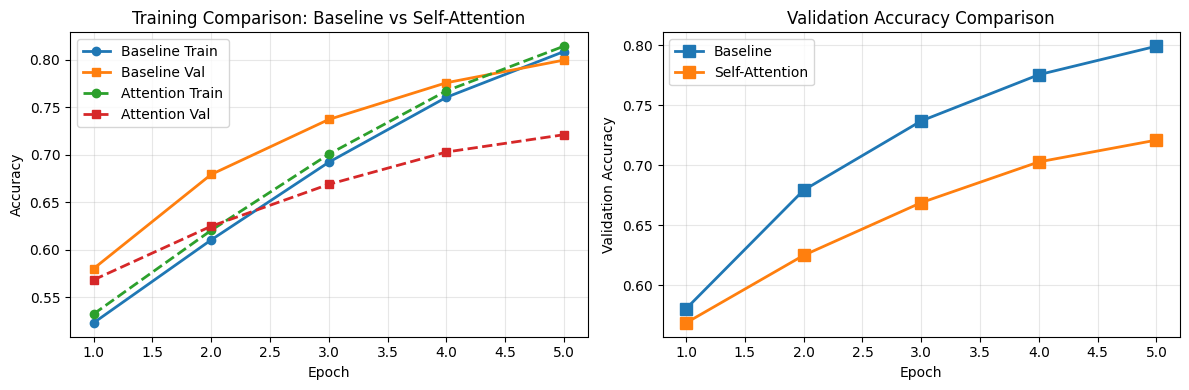

In [8]:
import torch.optim as optim
from tqdm import tqdm

# Training hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 5

print("="*60)
print("TRAINING COMPARISON: Baseline vs Simple Self-Attention")
print("="*60)

# Train Simple Classifier (Baseline)
print("\n" + "="*60)
print("1. TRAINING SIMPLE CLASSIFIER (BASELINE - NO ATTENTION)")
print("="*60)

# Reinitialize the baseline model
baseline_model = SimpleClassifier(vocab_size, emb_size, num_classes, pooling="max")
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=learning_rate)

baseline_train_accs = []
baseline_val_accs = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train_epoch(baseline_model, x_train, y_train, batch_size, w2i, baseline_optimizer)
    val_loss, val_acc = evaluate(baseline_model, x_val, y_val, batch_size, w2i)
    
    baseline_train_accs.append(train_acc)
    baseline_val_accs.append(val_acc)
    
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

print(f"\nFinal Baseline Results:")
print(f"  Train Accuracy: {baseline_train_accs[-1]:.4f}")
print(f"  Val Accuracy:   {baseline_val_accs[-1]:.4f}")

# Train Simple Self-Attention Classifier
print("\n" + "="*60)
print("2. TRAINING SIMPLE SELF-ATTENTION CLASSIFIER")
print("="*60)

# Reinitialize the attention model
attn_model = SimpleSelfAttentionClassifier(vocab_size, emb_size, num_classes, max_length=256)
attn_optimizer = optim.Adam(attn_model.parameters(), lr=learning_rate)

attn_train_accs = []
attn_val_accs = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train_epoch(attn_model, x_train, y_train, batch_size, w2i, attn_optimizer)
    val_loss, val_acc = evaluate(attn_model, x_val, y_val, batch_size, w2i)
    
    attn_train_accs.append(train_acc)
    attn_val_accs.append(val_acc)
    
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

print(f"\nFinal Attention Model Results:")
print(f"  Train Accuracy: {attn_train_accs[-1]:.4f}")
print(f"  Val Accuracy:   {attn_val_accs[-1]:.4f}")

# Summary comparison
print("\n" + "="*60)
print("FINAL COMPARISON")
print("="*60)
print(f"\nBaseline (No Attention):")
print(f"  Train Accuracy: {baseline_train_accs[-1]:.4f}")
print(f"  Val Accuracy:   {baseline_val_accs[-1]:.4f}")

print(f"\nSimple Self-Attention:")
print(f"  Train Accuracy: {attn_train_accs[-1]:.4f}")
print(f"  Val Accuracy:   {attn_val_accs[-1]:.4f}")

print(f"\nImprovement:")
improvement = (attn_val_accs[-1] - baseline_val_accs[-1]) * 100
print(f"  Validation Accuracy: {improvement:+.2f}%")

# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), baseline_train_accs, 'o-', label='Baseline Train', linewidth=2)
plt.plot(range(1, num_epochs + 1), baseline_val_accs, 's-', label='Baseline Val', linewidth=2)
plt.plot(range(1, num_epochs + 1), attn_train_accs, 'o--', label='Attention Train', linewidth=2)
plt.plot(range(1, num_epochs + 1), attn_val_accs, 's--', label='Attention Val', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Comparison: Baseline vs Self-Attention')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), baseline_val_accs, 's-', label='Baseline', linewidth=2, markersize=8)
plt.plot(range(1, num_epochs + 1), attn_val_accs, 's-', label='Self-Attention', linewidth=2, markersize=8)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)